In [25]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tkinter as tk
from tkinter import Label
import cv2
from PIL import Image, ImageTk

# Get the current directory of the script
current_dir = os.getcwd()

# Path to the HDF5 file
file_path = os.path.join(current_dir, 'bdd100k', 'videos')

# Function to extract video metadata
def get_video_metadata(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = frame_count / fps if fps else 0
    cap.release()
    return {
        'frame_count': frame_count,
        'width': frame_width,
        'height': frame_height,
        'fps': fps,
        'duration': duration
    }

# Load all .mov files into a pandas dataset with metadata
all_files = [f for f in os.listdir(file_path) if f.endswith('.mov')]
metadata = []
for filename in all_files:
    video_path = os.path.join(file_path, filename)
    meta = get_video_metadata(video_path)
    if meta:
        meta['filename'] = filename
        metadata.append(meta)

# Create the DataFrame with metadata
data = pd.DataFrame(metadata)

# Split the dataset into 70% training, 15% validation, and 15% testing
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Function to play video in a tkinter GUI
def display_video_in_gui(video_path):
    def play_video():
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("Error: Could not open video.")
            return

        def update_frame():
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                img = Image.fromarray(frame)
                imgtk = ImageTk.PhotoImage(image=img)
                lbl_video.imgtk = imgtk
                lbl_video.configure(image=imgtk)
                lbl_video.after(10, update_frame)  # Update the frame every 10ms
            else:
                cap.release()
                lbl_video.config(text="Video playback finished.")
        
        update_frame()

    # Create a tkinter window
    window = tk.Tk()
    window.title("Video Player")

    lbl_video = Label(window)
    lbl_video.pack()

    play_video()

    window.mainloop()

# Function to display a random video from a dataset
def display_random_video(dataset, base_path):
    if dataset.empty:
        print("The dataset is empty!")
        return

    random_file = dataset.sample(1)['filename'].values[0]
    video_path = os.path.join(base_path, random_file)

    print(f"Displaying video in GUI: {random_file}")
    display_video_in_gui(video_path)

# Save datasets to CSV files
train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

# Display a random video from each dataset (optional)
# Uncomment to test
# print("Training Dataset:")
# display_random_video(train_data, file_path)

# print("Validation Dataset:")
# display_random_video(val_data, file_path)

# print("Test Dataset:")
# display_random_video(test_data, file_path)


# GANs 01/21/2025

Number of training samples: 700
Number of testing samples: 150
Starting Training...
[Epoch 1/500 | Batch 0/175] D_Loss: 1.5232, G_Loss: 10.7703
[Epoch 1/500 | Batch 20/175] D_Loss: 0.9534, G_Loss: 8.1530
[Epoch 1/500 | Batch 40/175] D_Loss: 0.6183, G_Loss: 4.3320
[Epoch 1/500 | Batch 60/175] D_Loss: 1.0910, G_Loss: 2.3517
[Epoch 1/500 | Batch 80/175] D_Loss: 1.9516, G_Loss: 3.8388
[Epoch 1/500 | Batch 100/175] D_Loss: 1.7002, G_Loss: 3.2933
[Epoch 1/500 | Batch 120/175] D_Loss: 1.2195, G_Loss: 1.9801
[Epoch 1/500 | Batch 140/175] D_Loss: 0.7862, G_Loss: 3.0492
[Epoch 1/500 | Batch 160/175] D_Loss: 1.3049, G_Loss: 2.0631
==> End of Epoch 1/500, Avg D_Loss: 1.1390, Avg G_Loss: 3.7414
[Epoch 2/500 | Batch 0/175] D_Loss: 1.0819, G_Loss: 2.5473
[Epoch 2/500 | Batch 20/175] D_Loss: 1.0436, G_Loss: 1.9374
[Epoch 2/500 | Batch 40/175] D_Loss: 1.1028, G_Loss: 2.6433
[Epoch 2/500 | Batch 60/175] D_Loss: 0.7582, G_Loss: 2.4728
[Epoch 2/500 | Batch 80/175] D_Loss: 0.8199, G_Loss: 2.8393
[Epoch 2/5

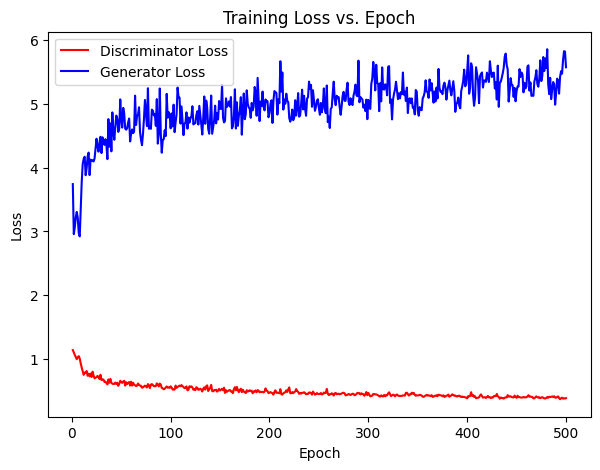

In [4]:
import os
import cv2
import numpy as np
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# For final plotting of losses at the end:
%matplotlib inline
import matplotlib.pyplot as plt

##############################################
# 1) Configuration & Paths
##############################################

current_dir = os.getcwd()
csv_train   = os.path.join(current_dir, "train_data.csv")
csv_test    = os.path.join(current_dir, "test_data.csv")
video_dir   = os.path.join(current_dir, "bdd100k", "videos")

# Basic hyperparameters
BATCH_SIZE    = 4
IMAGE_SIZE    = 64
EPOCHS        = 500
LEARNING_RATE = 2e-4

# We use a single scalar average as our label, 
# but replicate that scalar to fill EMBED_DIM=32.
EMBED_DIM = 32

NGF = 64
NDF = 64
NC  = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##############################################
# 2) Dataset (Downscaled-average -> Embedding Vec)
##############################################

class HashFrameDataset(Dataset):
    """
    For each CSV row:
      - Reads the first frame from the video.
      - Downscales the frame to a small resolution.
      - Takes the average of that downscaled frame (scalar).
      - Replicates that average to create a float embedding vector of length EMBED_DIM.
      - Returns (embed_vec, transformed_frame).
    """
    def __init__(self, csv_file, video_root, transform=None, downscale_size=8):
        super().__init__()
        self.data = pd.read_csv(csv_file)
        self.video_root = video_root
        self.transform = transform
        self.downscale_size = downscale_size
        self.samples = []
        
        for _, row in self.data.iterrows():
            fname = row['filename']
            video_path = os.path.join(self.video_root, fname)

            cap = cv2.VideoCapture(video_path)
            ret, frame = cap.read()
            cap.release()
            if not ret:
                continue  # skip if no frame read

            # Convert BGR -> RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # ------------------------------------
            # 1) Downscale the frame to e.g. 8×8
            # ------------------------------------
            frame_small = cv2.resize(
                frame_rgb, 
                (self.downscale_size, self.downscale_size), 
                interpolation=cv2.INTER_AREA
            )
            
            # ------------------------------------
            # 2) Take the average across all pixels and channels
            #    => a single scalar
            # ------------------------------------
            avg_val = frame_small.mean() / 255.0  # scale into [0, 1]
            
            # ------------------------------------
            # 3) Replicate that scalar to create
            #    a vector of length EMBED_DIM
            # ------------------------------------
            embed_array = np.full((EMBED_DIM,), avg_val, dtype=np.float32)
            embed_vec   = torch.tensor(embed_array)

            # Transform the original full-size frame for the final image input
            pil_image = Image.fromarray(frame_rgb)
            if self.transform:
                pil_image = self.transform(pil_image)

            # Store
            self.samples.append((embed_vec, pil_image))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]


# Transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # => shape [3, 64, 64]
])

# Create datasets & loaders
train_dataset = HashFrameDataset(csv_train, video_dir, transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# (We won't actually use the test dataset for anything in this example)
test_dataset  = HashFrameDataset(csv_test, video_dir, transform=transform)
test_loader   = DataLoader(test_dataset, batch_size=1, shuffle=False)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

##############################################
# 3) Generator & Discriminator (DCGAN style)
##############################################

class Generator(nn.Module):
    """
    Takes a conditional embedding of size EMBED_DIM,
    and outputs a 64x64 image with 3 channels.
    """
    def __init__(self, embed_dim=32, ngf=64, nc=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, ngf * 8 * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(ngf * 8, 4, 4)),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z)


class Discriminator(nn.Module):
    """
    Takes an image (3x64x64) and outputs
    a single scalar (real vs. fake).
    """
    def __init__(self, nc=3, ndf=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1)


# Instantiate models
netG = Generator(embed_dim=EMBED_DIM, ngf=NGF, nc=NC).to(device)
netD = Discriminator(nc=NC, ndf=NDF).to(device)

criterion  = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

##############################################
# 4) Training Loop with Live Text + Final Plot
##############################################

epoch_d_losses = []
epoch_g_losses = []

print("Starting Training...")

for epoch in range(EPOCHS):
    netD.train()
    netG.train()

    total_lossD = 0.0
    total_lossG = 0.0
    batches_this_epoch = 0

    for i, (embed_vec, real_imgs) in enumerate(train_loader):
        b_size = embed_vec.size(0)
        batches_this_epoch += 1

        # Move data to device
        embed_vec = embed_vec.to(device)
        real_imgs = real_imgs.to(device)

        # Labels
        real_label = torch.ones(b_size, device=device)
        fake_label = torch.zeros(b_size, device=device)

        ###################################
        # (1) Update Discriminator
        ###################################
        netD.zero_grad()

        # Real images
        out_real   = netD(real_imgs)
        real_label_smooth = 0.9
        lossD_real = criterion(out_real, torch.full_like(out_real, real_label_smooth))

        # Fake images
        fake_imgs   = netG(embed_vec)
        out_fake    = netD(fake_imgs.detach())  # detach => no G gradient
        lossD_fake  = criterion(out_fake, fake_label)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        ###################################
        # (2) Update Generator
        ###################################
        netG.zero_grad()

        fake_imgs_for_G = netG(embed_vec)
        out_fake_for_G  = netD(fake_imgs_for_G)
        lossG = criterion(out_fake_for_G, real_label)
        lossG.backward()
        optimizerG.step()

        total_lossD += lossD.item()
        total_lossG += lossG.item()

        if i % 20 == 0:
            print(f"[Epoch {epoch+1}/{EPOCHS} | Batch {i}/{len(train_loader)}] "
                  f"D_Loss: {lossD.item():.4f}, G_Loss: {lossG.item():.4f}")

    avg_lossD = total_lossD / batches_this_epoch
    avg_lossG = total_lossG / batches_this_epoch

    epoch_d_losses.append(avg_lossD)
    epoch_g_losses.append(avg_lossG)

    print(f"==> End of Epoch {epoch+1}/{EPOCHS}, "
          f"Avg D_Loss: {avg_lossD:.4f}, Avg G_Loss: {avg_lossG:.4f}")

print("Training complete!")

##############################################
# 5) Plot Loss vs. Epoch
##############################################

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs_range, epoch_d_losses, label='Discriminator Loss', color='red')
plt.plot(epochs_range, epoch_g_losses, label='Generator Loss',    color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()
plt.show()


# Plotting of Inference 01/21/2025

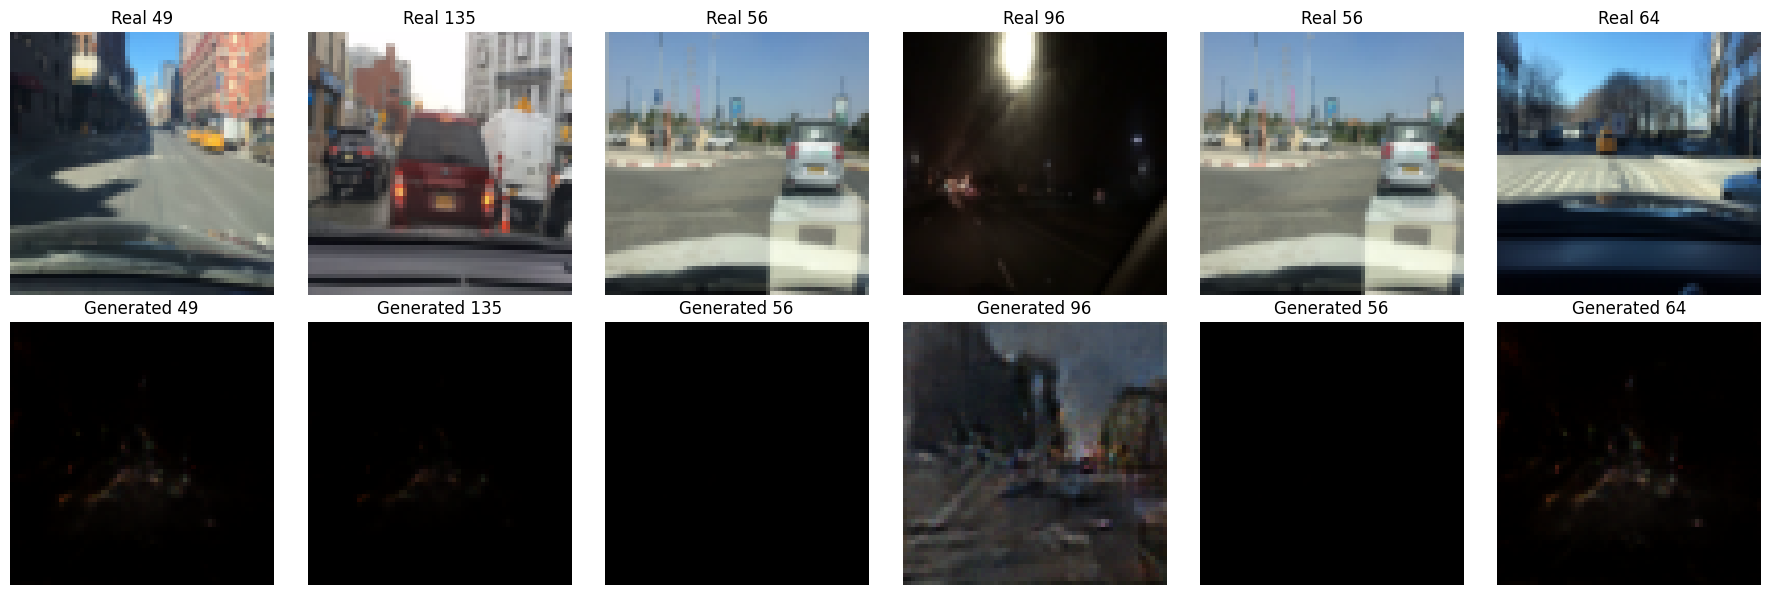

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Ensure test dataset has enough samples
num_samples = min(6, len(test_dataset))  # Pick up to 6 samples

if num_samples > 0:
    fig, axs = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))  # 2 rows, 6 columns

    netG.eval()  # Ensure the generator is in eval mode

    for i in range(num_samples):
        # Choose a random index
        idx = np.random.randint(0, len(test_dataset))

        # Retrieve stored noise vector and real image
        noise_vec, real_img = test_dataset[idx]
        noise_vec = noise_vec.unsqueeze(0).to(device)  # Add batch dim and move to device

        with torch.no_grad():
            gen_out = netG(noise_vec)  # Generate an image

        # Convert Generator output to NumPy
        gen_out_np = gen_out.squeeze(0).cpu().numpy()  # Shape [3, H, W]
        gen_out_np = np.transpose(gen_out_np, (1, 2, 0))  # Shape [H, W, 3]

        # Convert real image to NumPy
        real_np = real_img.numpy().transpose(1, 2, 0)  # Shape [H, W, 3]

        # Display real images in first row
        axs[0, i].imshow(real_np)
        axs[0, i].set_title(f"Real {idx}")
        axs[0, i].axis("off")

        # Display generated images in second row
        axs[1, i].imshow(gen_out_np)
        axs[1, i].set_title(f"Generated {idx}")
        axs[1, i].axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("No test samples to visualize.")


# 01 / 22 / 2025 

In [15]:
import os
import cv2
import numpy as np
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# For final plotting of losses at the end:
import matplotlib.pyplot as plt

##############################################
# 1) Configuration & Paths
##############################################

current_dir = os.getcwd()
csv_train   = os.path.join(current_dir, "train_data.csv")
csv_test    = os.path.join(current_dir, "test_data.csv")
video_dir   = os.path.join(current_dir, "bdd100k", "videos")

# Basic hyperparameters
BATCH_SIZE    = 4
IMAGE_SIZE    = 64
EPOCHS        = 20
LEARNING_RATE = 2e-4

# Embedding and noise dimensions
EMBED_DIM = 32
NZ = 100  # Size of the random noise vector

NGF = 64
NDF = 64
NC  = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##############################################
# 2) Dataset (Downscaled-average -> Embedding Vec)
##############################################

class HashFrameDataset(Dataset):
    """
    For each CSV row:
      - Reads the first frame from the video.
      - Downscales the frame to a small resolution.
      - Takes the average of that downscaled frame (scalar).
      - Replicates that average to create a float embedding vector of length EMBED_DIM.
      - Returns (embed_vec, transformed_frame).
    """
    def __init__(self, csv_file, video_root, transform=None, downscale_size=8):
        super().__init__()
        self.data = pd.read_csv(csv_file)
        self.video_root = video_root
        self.transform = transform
        self.downscale_size = downscale_size
        self.samples = []
        
        for _, row in self.data.iterrows():
            fname = row['filename']
            video_path = os.path.join(self.video_root, fname)

            cap = cv2.VideoCapture(video_path)
            ret, frame = cap.read()
            cap.release()
            if not ret:
                continue  # skip if no frame read

            # Convert BGR -> RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # ------------------------------------
            # 1) Downscale the frame to e.g. 8×8
            # ------------------------------------
            frame_small = cv2.resize(
                frame_rgb, 
                (self.downscale_size, self.downscale_size), 
                interpolation=cv2.INTER_AREA
            )
            
            # ------------------------------------
            # 2) Take the average across all pixels and channels
            #    => a single scalar
            # ------------------------------------
            avg_val = frame_small.mean() / 255.0  # scale into [0, 1]
            
            # ------------------------------------
            # 3) Replicate that scalar to create
            #    a vector of length EMBED_DIM
            # ------------------------------------
            embed_array = np.full((EMBED_DIM,), avg_val, dtype=np.float32)
            embed_vec   = torch.tensor(embed_array)

            # Transform the original full-size frame for the final image input
            pil_image = Image.fromarray(frame_rgb)
            if self.transform:
                pil_image = self.transform(pil_image)

            # Store
            self.samples.append((embed_vec, pil_image))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]


# Transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # => shape [3, 64, 64]
])

# Create datasets & loaders
train_dataset = HashFrameDataset(csv_train, video_dir, transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# (We won't actually use the test dataset for anything in this example)
test_dataset  = HashFrameDataset(csv_test, video_dir, transform=transform)
test_loader   = DataLoader(test_dataset, batch_size=1, shuffle=False)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

##############################################
# 3) Generator & Discriminator (DCGAN style)
##############################################

class Generator(nn.Module):
    """
    Takes a random noise vector z and a conditional embedding y,
    concatenates them, and outputs a 64x64 image with 3 channels.
    """
    def __init__(self, nz=100, embed_dim=32, ngf=64, nc=3):
        super().__init__()
        self.nz = nz
        self.embed_dim = embed_dim
        self.net = nn.Sequential(
            nn.Linear(nz + embed_dim, ngf * 8 * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(ngf * 8, 4, 4)),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, z, y):
        # Concatenate noise and embedding vectors
        combined_input = torch.cat((z, y), dim=1)
        return self.net(combined_input)


class Discriminator(nn.Module):
    """
    Takes an image (3x64x64) and a conditional embedding y,
    concatenates them, and outputs a single scalar (real vs. fake).
    """
    def __init__(self, embed_dim=32, nc=3, ndf=64):
        super().__init__()
        self.embed_dim = embed_dim
        self.nc = nc
        self.ndf = ndf

        # Project and reshape y to match image spatial dimensions
        self.embed_to_image = nn.Sequential(
            nn.Linear(embed_dim, IMAGE_SIZE * IMAGE_SIZE),
            nn.Unflatten(1, (1, IMAGE_SIZE, IMAGE_SIZE))
        )

        self.net = nn.Sequential(
            # Input channels: image channels + 1 (from y)
            nn.Conv2d(nc + 1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        # Project y and reshape
        y_proj = self.embed_to_image(y)  # Shape: [batch_size, 1, 64, 64]
        
        # Concatenate image and y_proj
        combined = torch.cat((x, y_proj), dim=1)  # Shape: [batch_size, 4, 64, 64]
        return self.net(combined).view(-1)


# Instantiate models with the updated dimensions
netG = Generator(nz=NZ, embed_dim=EMBED_DIM, ngf=NGF, nc=NC).to(device)
netD = Discriminator(embed_dim=EMBED_DIM, nc=NC, ndf=NDF).to(device)

# Initialize weights (optional but recommended)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('ConvTranspose') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

criterion  = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

##############################################
# 4) Training Loop with Live Text + Final Plot
##############################################

epoch_d_losses = []
epoch_g_losses = []

print("Starting Training...")

for epoch in range(EPOCHS):
    netD.train()
    netG.train()

    total_lossD = 0.0
    total_lossG = 0.0
    batches_this_epoch = 0

    for i, (embed_vec, real_imgs) in enumerate(train_loader):
        b_size = embed_vec.size(0)
        batches_this_epoch += 1

        # Move data to device
        embed_vec = embed_vec.to(device)
        real_imgs = real_imgs.to(device)

        # Generate random noise
        z = torch.randn(b_size, NZ, device=device)

        # Labels
        real_label = torch.ones(b_size, device=device)
        fake_label = torch.zeros(b_size, device=device)

        ###################################
        # (1) Update Discriminator
        ###################################
        netD.zero_grad()

        # Real images with y
        out_real = netD(real_imgs, embed_vec)
        real_label_smooth = 0.9
        lossD_real = criterion(out_real, torch.full_like(out_real, real_label_smooth))

        # Fake images with y
        fake_imgs = netG(z, embed_vec)
        out_fake = netD(fake_imgs.detach(), embed_vec)  # detach => no G gradient
        lossD_fake = criterion(out_fake, fake_label)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        ###################################
        # (2) Update Generator
        ###################################
        netG.zero_grad()

        fake_imgs_for_G = netG(z, embed_vec)
        out_fake_for_G = netD(fake_imgs_for_G, embed_vec)
        lossG = criterion(out_fake_for_G, real_label)
        lossG.backward()
        optimizerG.step()

        total_lossD += lossD.item()
        total_lossG += lossG.item()

        if i % 20 == 0:
            print(f"[Epoch {epoch+1}/{EPOCHS} | Batch {i}/{len(train_loader)}] "
                  f"D_Loss: {lossD.item():.4f}, G_Loss: {lossG.item():.4f}")

    avg_lossD = total_lossD / batches_this_epoch
    avg_lossG = total_lossG / batches_this_epoch

    epoch_d_losses.append(avg_lossD)
    epoch_g_losses.append(avg_lossG)

    print(f"==> End of Epoch {epoch+1}/{EPOCHS}, "
          f"Avg D_Loss: {avg_lossD:.4f}, Avg G_Loss: {avg_lossG:.4f}")

print("Training complete!")

##############################################
# 5) Plot Loss vs. Epoch
##############################################

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs_range, epoch_d_losses, label='Discriminator Loss', color='red')
plt.plot(epochs_range, epoch_g_losses, label='Generator Loss',    color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()
plt.show()

Number of training samples: 700
Number of testing samples: 150
Starting Training...


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

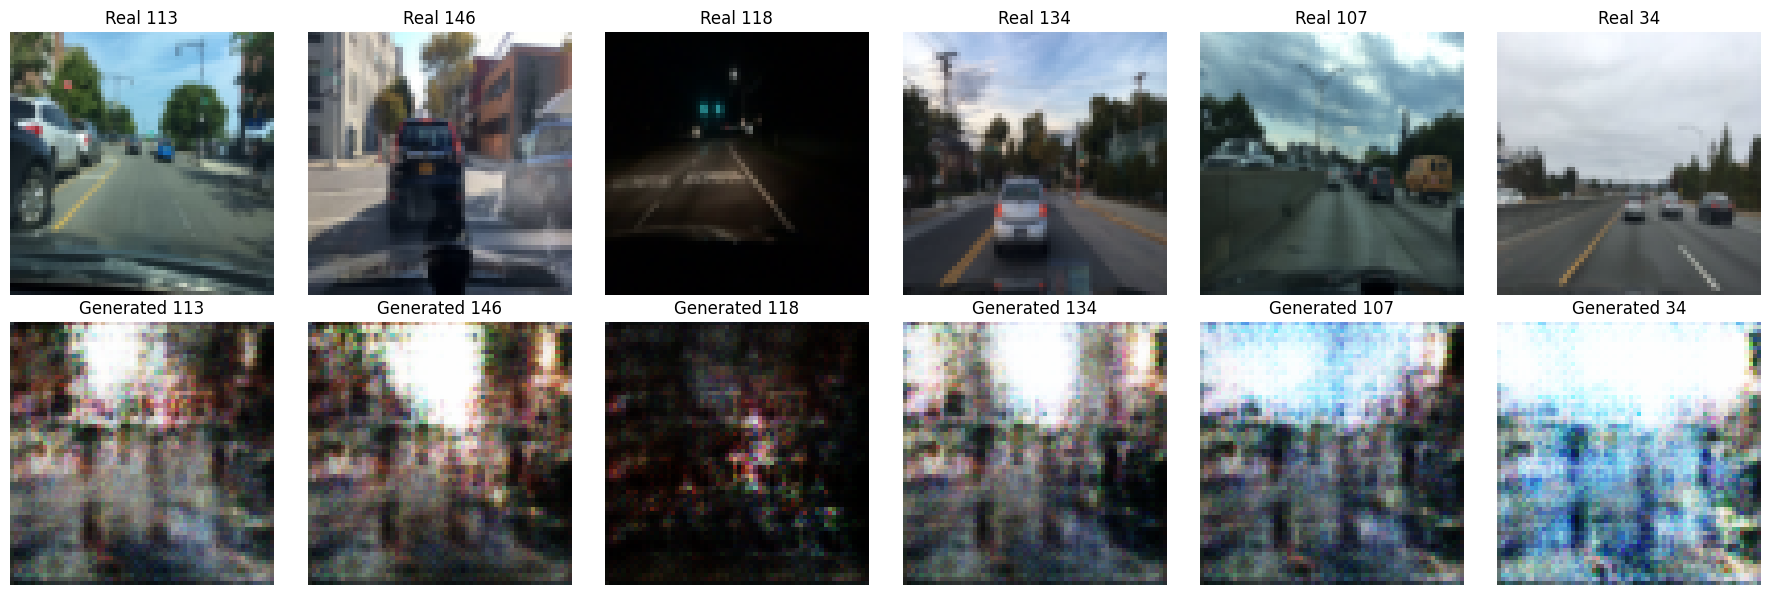

In [11]:
# Ensure test dataset has enough samples
num_samples = min(6, len(test_dataset))  # Pick up to 6 samples

if num_samples > 0:
    fig, axs = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))  # 2 rows, 'num_samples' columns

    netG.eval()  # Ensure the generator is in evaluation mode

    for i in range(num_samples):
        # Choose a random index
        idx = np.random.randint(0, len(test_dataset))

        # Retrieve stored embedding vector (y) and real image
        embed_vec, real_img = test_dataset[idx]
        embed_vec = embed_vec.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Generate a random noise vector (z) for this sample
        z = torch.randn(1, NZ, device=device)  # 'NZ' should match the noise dimension used during training

        with torch.no_grad():
            # Generate an image using both z and y
            gen_out = netG(z, embed_vec)  # Updated to pass both z and y

        # Convert Generator output to NumPy format for visualization
        gen_out_np = gen_out.squeeze(0).cpu().numpy()  # Shape: [3, H, W]
        gen_out_np = np.transpose(gen_out_np, (1, 2, 0))  # Shape: [H, W, 3]

        # Convert real image to NumPy format for visualization
        real_np = real_img.numpy().transpose(1, 2, 0)  # Shape: [H, W, 3]

        # Display real images in the first row
        axs[0, i].imshow(real_np)
        axs[0, i].set_title(f"Real {idx}")
        axs[0, i].axis("off")

        # Display generated images in the second row
        axs[1, i].imshow(gen_out_np)
        axs[1, i].set_title(f"Generated {idx}")
        axs[1, i].axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("No test samples to visualize.")


# Round 2

Using device: cuda
Number of training samples: 700
Number of testing samples: 150
Starting Training...


Epoch 1/500: 100%|██████████| 175/175 [00:01<00:00, 156.23it/s]


==> Epoch 1/500 Average loss: 771.3014


Epoch 2/500: 100%|██████████| 175/175 [00:00<00:00, 177.78it/s]


==> Epoch 2/500 Average loss: 477.6508


Epoch 3/500: 100%|██████████| 175/175 [00:00<00:00, 182.70it/s]


==> Epoch 3/500 Average loss: 422.7426


Epoch 4/500: 100%|██████████| 175/175 [00:01<00:00, 168.60it/s]


==> Epoch 4/500 Average loss: 387.0775


Epoch 5/500: 100%|██████████| 175/175 [00:01<00:00, 165.48it/s]


==> Epoch 5/500 Average loss: 371.3547


Epoch 6/500: 100%|██████████| 175/175 [00:01<00:00, 163.09it/s]


==> Epoch 6/500 Average loss: 338.7502


Epoch 7/500: 100%|██████████| 175/175 [00:01<00:00, 163.13it/s]


==> Epoch 7/500 Average loss: 327.4777


Epoch 8/500: 100%|██████████| 175/175 [00:01<00:00, 163.22it/s]


==> Epoch 8/500 Average loss: 298.2711


Epoch 9/500: 100%|██████████| 175/175 [00:01<00:00, 164.09it/s]


==> Epoch 9/500 Average loss: 296.2622


Epoch 10/500: 100%|██████████| 175/175 [00:01<00:00, 136.78it/s]


==> Epoch 10/500 Average loss: 284.3111


Epoch 11/500: 100%|██████████| 175/175 [00:01<00:00, 121.81it/s]


==> Epoch 11/500 Average loss: 280.0341


Epoch 12/500: 100%|██████████| 175/175 [00:01<00:00, 144.50it/s]


==> Epoch 12/500 Average loss: 272.2937


Epoch 13/500: 100%|██████████| 175/175 [00:01<00:00, 148.31it/s]


==> Epoch 13/500 Average loss: 255.1790


Epoch 14/500: 100%|██████████| 175/175 [00:01<00:00, 169.51it/s]


==> Epoch 14/500 Average loss: 249.9310


Epoch 15/500: 100%|██████████| 175/175 [00:01<00:00, 161.40it/s]


==> Epoch 15/500 Average loss: 245.6405


Epoch 16/500: 100%|██████████| 175/175 [00:01<00:00, 156.34it/s]


==> Epoch 16/500 Average loss: 240.5985


Epoch 17/500: 100%|██████████| 175/175 [00:01<00:00, 157.05it/s]


==> Epoch 17/500 Average loss: 241.6488


Epoch 18/500: 100%|██████████| 175/175 [00:01<00:00, 157.06it/s]


==> Epoch 18/500 Average loss: 238.5843


Epoch 19/500: 100%|██████████| 175/175 [00:01<00:00, 144.65it/s]


==> Epoch 19/500 Average loss: 234.5692


Epoch 20/500: 100%|██████████| 175/175 [00:01<00:00, 168.86it/s]


==> Epoch 20/500 Average loss: 229.5526


Epoch 21/500: 100%|██████████| 175/175 [00:01<00:00, 166.94it/s]


==> Epoch 21/500 Average loss: 224.9963


Epoch 22/500: 100%|██████████| 175/175 [00:01<00:00, 163.55it/s]


==> Epoch 22/500 Average loss: 224.3472


Epoch 23/500: 100%|██████████| 175/175 [00:01<00:00, 166.49it/s]


==> Epoch 23/500 Average loss: 219.5682


Epoch 24/500: 100%|██████████| 175/175 [00:01<00:00, 161.87it/s]


==> Epoch 24/500 Average loss: 218.2043


Epoch 25/500: 100%|██████████| 175/175 [00:01<00:00, 168.10it/s]


==> Epoch 25/500 Average loss: 215.3238


Epoch 26/500: 100%|██████████| 175/175 [00:01<00:00, 162.20it/s]


==> Epoch 26/500 Average loss: 212.2827


Epoch 27/500: 100%|██████████| 175/175 [00:01<00:00, 162.22it/s]


==> Epoch 27/500 Average loss: 213.0175


Epoch 28/500: 100%|██████████| 175/175 [00:01<00:00, 164.50it/s]


==> Epoch 28/500 Average loss: 210.0819


Epoch 29/500: 100%|██████████| 175/175 [00:01<00:00, 170.09it/s]


==> Epoch 29/500 Average loss: 207.7607


Epoch 30/500: 100%|██████████| 175/175 [00:01<00:00, 151.31it/s]


==> Epoch 30/500 Average loss: 205.1395


Epoch 31/500: 100%|██████████| 175/175 [00:01<00:00, 166.94it/s]


==> Epoch 31/500 Average loss: 203.2720


Epoch 32/500: 100%|██████████| 175/175 [00:01<00:00, 155.87it/s]


==> Epoch 32/500 Average loss: 200.4196


Epoch 33/500: 100%|██████████| 175/175 [00:01<00:00, 172.08it/s]


==> Epoch 33/500 Average loss: 202.4389


Epoch 34/500: 100%|██████████| 175/175 [00:01<00:00, 166.08it/s]


==> Epoch 34/500 Average loss: 197.1408


Epoch 35/500: 100%|██████████| 175/175 [00:01<00:00, 163.68it/s]


==> Epoch 35/500 Average loss: 194.6021


Epoch 36/500: 100%|██████████| 175/175 [00:01<00:00, 161.44it/s]


==> Epoch 36/500 Average loss: 195.5664


Epoch 37/500: 100%|██████████| 175/175 [00:01<00:00, 166.94it/s]


==> Epoch 37/500 Average loss: 193.7776


Epoch 38/500: 100%|██████████| 175/175 [00:01<00:00, 170.08it/s]


==> Epoch 38/500 Average loss: 192.0097


Epoch 39/500: 100%|██████████| 175/175 [00:01<00:00, 173.27it/s]


==> Epoch 39/500 Average loss: 190.1071


Epoch 40/500: 100%|██████████| 175/175 [00:01<00:00, 164.79it/s]


==> Epoch 40/500 Average loss: 188.0384


Epoch 41/500: 100%|██████████| 175/175 [00:01<00:00, 160.79it/s]


==> Epoch 41/500 Average loss: 187.9029


Epoch 42/500: 100%|██████████| 175/175 [00:01<00:00, 170.01it/s]


==> Epoch 42/500 Average loss: 185.8499


Epoch 43/500: 100%|██████████| 175/175 [00:00<00:00, 175.18it/s]


==> Epoch 43/500 Average loss: 186.5883


Epoch 44/500: 100%|██████████| 175/175 [00:01<00:00, 167.50it/s]


==> Epoch 44/500 Average loss: 182.5502


Epoch 45/500: 100%|██████████| 175/175 [00:01<00:00, 171.20it/s]


==> Epoch 45/500 Average loss: 179.0885


Epoch 46/500: 100%|██████████| 175/175 [00:01<00:00, 173.06it/s]


==> Epoch 46/500 Average loss: 178.5983


Epoch 47/500: 100%|██████████| 175/175 [00:01<00:00, 159.58it/s]


==> Epoch 47/500 Average loss: 179.0359


Epoch 48/500: 100%|██████████| 175/175 [00:01<00:00, 165.98it/s]


==> Epoch 48/500 Average loss: 176.9545


Epoch 49/500: 100%|██████████| 175/175 [00:01<00:00, 171.61it/s]


==> Epoch 49/500 Average loss: 176.8035


Epoch 50/500: 100%|██████████| 175/175 [00:01<00:00, 171.13it/s]


==> Epoch 50/500 Average loss: 176.0722


Epoch 51/500: 100%|██████████| 175/175 [00:01<00:00, 169.29it/s]


==> Epoch 51/500 Average loss: 172.3044


Epoch 52/500: 100%|██████████| 175/175 [00:01<00:00, 169.43it/s]


==> Epoch 52/500 Average loss: 170.5409


Epoch 53/500: 100%|██████████| 175/175 [00:01<00:00, 170.91it/s]


==> Epoch 53/500 Average loss: 169.0395


Epoch 54/500: 100%|██████████| 175/175 [00:01<00:00, 166.15it/s]


==> Epoch 54/500 Average loss: 168.2037


Epoch 55/500: 100%|██████████| 175/175 [00:01<00:00, 163.58it/s]


==> Epoch 55/500 Average loss: 167.0515


Epoch 56/500: 100%|██████████| 175/175 [00:01<00:00, 165.23it/s]


==> Epoch 56/500 Average loss: 169.1074


Epoch 57/500: 100%|██████████| 175/175 [00:01<00:00, 165.01it/s]


==> Epoch 57/500 Average loss: 167.0492


Epoch 58/500: 100%|██████████| 175/175 [00:01<00:00, 155.63it/s]


==> Epoch 58/500 Average loss: 162.3125


Epoch 59/500: 100%|██████████| 175/175 [00:01<00:00, 173.23it/s]


==> Epoch 59/500 Average loss: 163.0651


Epoch 60/500: 100%|██████████| 175/175 [00:01<00:00, 174.52it/s]


==> Epoch 60/500 Average loss: 160.5311


Epoch 61/500: 100%|██████████| 175/175 [00:01<00:00, 168.42it/s]


==> Epoch 61/500 Average loss: 160.6745


Epoch 62/500: 100%|██████████| 175/175 [00:01<00:00, 158.39it/s]


==> Epoch 62/500 Average loss: 157.6559


Epoch 63/500: 100%|██████████| 175/175 [00:01<00:00, 171.04it/s]


==> Epoch 63/500 Average loss: 157.6202


Epoch 64/500: 100%|██████████| 175/175 [00:01<00:00, 172.57it/s]


==> Epoch 64/500 Average loss: 156.0813


Epoch 65/500: 100%|██████████| 175/175 [00:01<00:00, 166.02it/s]


==> Epoch 65/500 Average loss: 155.0725


Epoch 66/500: 100%|██████████| 175/175 [00:01<00:00, 174.86it/s]


==> Epoch 66/500 Average loss: 155.7139


Epoch 67/500: 100%|██████████| 175/175 [00:01<00:00, 163.68it/s]


==> Epoch 67/500 Average loss: 150.8956


Epoch 68/500: 100%|██████████| 175/175 [00:01<00:00, 168.79it/s]


==> Epoch 68/500 Average loss: 151.7618


Epoch 69/500: 100%|██████████| 175/175 [00:01<00:00, 160.28it/s]


==> Epoch 69/500 Average loss: 151.1086


Epoch 70/500: 100%|██████████| 175/175 [00:01<00:00, 166.51it/s]


==> Epoch 70/500 Average loss: 150.2150


Epoch 71/500: 100%|██████████| 175/175 [00:01<00:00, 168.40it/s]


==> Epoch 71/500 Average loss: 148.4329


Epoch 72/500: 100%|██████████| 175/175 [00:01<00:00, 162.98it/s]


==> Epoch 72/500 Average loss: 148.3160


Epoch 73/500: 100%|██████████| 175/175 [00:01<00:00, 172.68it/s]


==> Epoch 73/500 Average loss: 147.6066


Epoch 74/500: 100%|██████████| 175/175 [00:01<00:00, 165.45it/s]


==> Epoch 74/500 Average loss: 146.1813


Epoch 75/500: 100%|██████████| 175/175 [00:01<00:00, 164.60it/s]


==> Epoch 75/500 Average loss: 145.8347


Epoch 76/500: 100%|██████████| 175/175 [00:01<00:00, 162.05it/s]


==> Epoch 76/500 Average loss: 144.1114


Epoch 77/500: 100%|██████████| 175/175 [00:01<00:00, 164.32it/s]


==> Epoch 77/500 Average loss: 143.0755


Epoch 78/500: 100%|██████████| 175/175 [00:01<00:00, 170.72it/s]


==> Epoch 78/500 Average loss: 140.8418


Epoch 79/500: 100%|██████████| 175/175 [00:01<00:00, 164.32it/s]


==> Epoch 79/500 Average loss: 140.1723


Epoch 80/500: 100%|██████████| 175/175 [00:01<00:00, 167.16it/s]


==> Epoch 80/500 Average loss: 140.8958


Epoch 81/500: 100%|██████████| 175/175 [00:01<00:00, 167.07it/s]


==> Epoch 81/500 Average loss: 138.8370


Epoch 82/500: 100%|██████████| 175/175 [00:01<00:00, 172.46it/s]


==> Epoch 82/500 Average loss: 139.5666


Epoch 83/500: 100%|██████████| 175/175 [00:01<00:00, 156.35it/s]


==> Epoch 83/500 Average loss: 137.6145


Epoch 84/500: 100%|██████████| 175/175 [00:01<00:00, 167.89it/s]


==> Epoch 84/500 Average loss: 136.3388


Epoch 85/500: 100%|██████████| 175/175 [00:01<00:00, 164.96it/s]


==> Epoch 85/500 Average loss: 134.4981


Epoch 86/500: 100%|██████████| 175/175 [00:01<00:00, 162.03it/s]


==> Epoch 86/500 Average loss: 134.6024


Epoch 87/500: 100%|██████████| 175/175 [00:01<00:00, 167.72it/s]


==> Epoch 87/500 Average loss: 134.4479


Epoch 88/500: 100%|██████████| 175/175 [00:01<00:00, 169.09it/s]


==> Epoch 88/500 Average loss: 133.2892


Epoch 89/500: 100%|██████████| 175/175 [00:01<00:00, 166.27it/s]


==> Epoch 89/500 Average loss: 131.3397


Epoch 90/500: 100%|██████████| 175/175 [00:01<00:00, 166.74it/s]


==> Epoch 90/500 Average loss: 131.8888


Epoch 91/500: 100%|██████████| 175/175 [00:01<00:00, 164.81it/s]


==> Epoch 91/500 Average loss: 131.5950


Epoch 92/500: 100%|██████████| 175/175 [00:01<00:00, 165.41it/s]


==> Epoch 92/500 Average loss: 130.6108


Epoch 93/500: 100%|██████████| 175/175 [00:01<00:00, 174.25it/s]


==> Epoch 93/500 Average loss: 128.8118


Epoch 94/500: 100%|██████████| 175/175 [00:01<00:00, 163.71it/s]


==> Epoch 94/500 Average loss: 128.1036


Epoch 95/500: 100%|██████████| 175/175 [00:01<00:00, 166.97it/s]


==> Epoch 95/500 Average loss: 126.9924


Epoch 96/500: 100%|██████████| 175/175 [00:01<00:00, 165.30it/s]


==> Epoch 96/500 Average loss: 127.9308


Epoch 97/500: 100%|██████████| 175/175 [00:01<00:00, 158.16it/s]


==> Epoch 97/500 Average loss: 126.3571


Epoch 98/500: 100%|██████████| 175/175 [00:01<00:00, 162.16it/s]


==> Epoch 98/500 Average loss: 125.9041


Epoch 99/500: 100%|██████████| 175/175 [00:01<00:00, 162.14it/s]


==> Epoch 99/500 Average loss: 125.5892


Epoch 100/500: 100%|██████████| 175/175 [00:01<00:00, 163.16it/s]


==> Epoch 100/500 Average loss: 124.8910


Epoch 101/500: 100%|██████████| 175/175 [00:01<00:00, 165.65it/s]


==> Epoch 101/500 Average loss: 123.2585


Epoch 102/500: 100%|██████████| 175/175 [00:01<00:00, 172.93it/s]


==> Epoch 102/500 Average loss: 122.5877


Epoch 103/500: 100%|██████████| 175/175 [00:01<00:00, 168.26it/s]


==> Epoch 103/500 Average loss: 121.2844


Epoch 104/500: 100%|██████████| 175/175 [00:01<00:00, 167.25it/s]


==> Epoch 104/500 Average loss: 121.2943


Epoch 105/500: 100%|██████████| 175/175 [00:01<00:00, 170.18it/s]


==> Epoch 105/500 Average loss: 120.5274


Epoch 106/500: 100%|██████████| 175/175 [00:01<00:00, 163.80it/s]


==> Epoch 106/500 Average loss: 120.3031


Epoch 107/500: 100%|██████████| 175/175 [00:01<00:00, 158.08it/s]


==> Epoch 107/500 Average loss: 120.1528


Epoch 108/500: 100%|██████████| 175/175 [00:01<00:00, 171.72it/s]


==> Epoch 108/500 Average loss: 119.4772


Epoch 109/500: 100%|██████████| 175/175 [00:01<00:00, 165.27it/s]


==> Epoch 109/500 Average loss: 119.1724


Epoch 110/500: 100%|██████████| 175/175 [00:01<00:00, 169.23it/s]


==> Epoch 110/500 Average loss: 117.5948


Epoch 111/500: 100%|██████████| 175/175 [00:01<00:00, 167.59it/s]


==> Epoch 111/500 Average loss: 117.4802


Epoch 112/500: 100%|██████████| 175/175 [00:01<00:00, 168.68it/s]


==> Epoch 112/500 Average loss: 116.6707


Epoch 113/500: 100%|██████████| 175/175 [00:01<00:00, 169.99it/s]


==> Epoch 113/500 Average loss: 117.2919


Epoch 114/500: 100%|██████████| 175/175 [00:01<00:00, 161.80it/s]


==> Epoch 114/500 Average loss: 115.4183


Epoch 115/500: 100%|██████████| 175/175 [00:01<00:00, 161.58it/s]


==> Epoch 115/500 Average loss: 115.0654


Epoch 116/500: 100%|██████████| 175/175 [00:01<00:00, 172.42it/s]


==> Epoch 116/500 Average loss: 114.9560


Epoch 117/500: 100%|██████████| 175/175 [00:01<00:00, 170.22it/s]


==> Epoch 117/500 Average loss: 113.7911


Epoch 118/500: 100%|██████████| 175/175 [00:01<00:00, 164.22it/s]


==> Epoch 118/500 Average loss: 112.9548


Epoch 119/500: 100%|██████████| 175/175 [00:01<00:00, 173.78it/s]


==> Epoch 119/500 Average loss: 112.3999


Epoch 120/500: 100%|██████████| 175/175 [00:01<00:00, 165.69it/s]


==> Epoch 120/500 Average loss: 111.8438


Epoch 121/500: 100%|██████████| 175/175 [00:01<00:00, 164.21it/s]


==> Epoch 121/500 Average loss: 111.9651


Epoch 122/500: 100%|██████████| 175/175 [00:01<00:00, 166.52it/s]


==> Epoch 122/500 Average loss: 111.8486


Epoch 123/500: 100%|██████████| 175/175 [00:01<00:00, 168.05it/s]


==> Epoch 123/500 Average loss: 112.3065


Epoch 124/500: 100%|██████████| 175/175 [00:00<00:00, 180.07it/s]


==> Epoch 124/500 Average loss: 110.0934


Epoch 125/500: 100%|██████████| 175/175 [00:01<00:00, 170.38it/s]


==> Epoch 125/500 Average loss: 110.6771


Epoch 126/500: 100%|██████████| 175/175 [00:01<00:00, 167.49it/s]


==> Epoch 126/500 Average loss: 108.8585


Epoch 127/500: 100%|██████████| 175/175 [00:01<00:00, 168.14it/s]


==> Epoch 127/500 Average loss: 107.6958


Epoch 128/500: 100%|██████████| 175/175 [00:01<00:00, 173.79it/s]


==> Epoch 128/500 Average loss: 107.9906


Epoch 129/500: 100%|██████████| 175/175 [00:01<00:00, 169.91it/s]


==> Epoch 129/500 Average loss: 107.2406


Epoch 130/500: 100%|██████████| 175/175 [00:00<00:00, 176.06it/s]


==> Epoch 130/500 Average loss: 107.8745


Epoch 131/500: 100%|██████████| 175/175 [00:01<00:00, 164.69it/s]


==> Epoch 131/500 Average loss: 107.5219


Epoch 132/500: 100%|██████████| 175/175 [00:01<00:00, 174.84it/s]


==> Epoch 132/500 Average loss: 106.9257


Epoch 133/500: 100%|██████████| 175/175 [00:01<00:00, 169.39it/s]


==> Epoch 133/500 Average loss: 105.9010


Epoch 134/500: 100%|██████████| 175/175 [00:01<00:00, 169.79it/s]


==> Epoch 134/500 Average loss: 106.0072


Epoch 135/500: 100%|██████████| 175/175 [00:01<00:00, 162.31it/s]


==> Epoch 135/500 Average loss: 105.9337


Epoch 136/500: 100%|██████████| 175/175 [00:01<00:00, 156.59it/s]


==> Epoch 136/500 Average loss: 105.2061


Epoch 137/500: 100%|██████████| 175/175 [00:01<00:00, 159.46it/s]


==> Epoch 137/500 Average loss: 104.2949


Epoch 138/500: 100%|██████████| 175/175 [00:01<00:00, 163.14it/s]


==> Epoch 138/500 Average loss: 103.9047


Epoch 139/500: 100%|██████████| 175/175 [00:01<00:00, 161.98it/s]


==> Epoch 139/500 Average loss: 104.0909


Epoch 140/500: 100%|██████████| 175/175 [00:01<00:00, 165.69it/s]


==> Epoch 140/500 Average loss: 102.9444


Epoch 141/500: 100%|██████████| 175/175 [00:01<00:00, 156.76it/s]


==> Epoch 141/500 Average loss: 102.4631


Epoch 142/500: 100%|██████████| 175/175 [00:01<00:00, 165.70it/s]


==> Epoch 142/500 Average loss: 102.2033


Epoch 143/500: 100%|██████████| 175/175 [00:01<00:00, 160.51it/s]


==> Epoch 143/500 Average loss: 101.5585


Epoch 144/500: 100%|██████████| 175/175 [00:01<00:00, 152.59it/s]


==> Epoch 144/500 Average loss: 101.1014


Epoch 145/500: 100%|██████████| 175/175 [00:01<00:00, 155.14it/s]


==> Epoch 145/500 Average loss: 101.2197


Epoch 146/500: 100%|██████████| 175/175 [00:01<00:00, 149.84it/s]


==> Epoch 146/500 Average loss: 101.5990


Epoch 147/500: 100%|██████████| 175/175 [00:01<00:00, 146.54it/s]


==> Epoch 147/500 Average loss: 100.2901


Epoch 148/500: 100%|██████████| 175/175 [00:01<00:00, 163.66it/s]


==> Epoch 148/500 Average loss: 100.3555


Epoch 149/500: 100%|██████████| 175/175 [00:01<00:00, 168.72it/s]


==> Epoch 149/500 Average loss: 99.4676


Epoch 150/500: 100%|██████████| 175/175 [00:01<00:00, 164.20it/s]


==> Epoch 150/500 Average loss: 99.2959


Epoch 151/500: 100%|██████████| 175/175 [00:01<00:00, 163.09it/s]


==> Epoch 151/500 Average loss: 98.0036


Epoch 152/500: 100%|██████████| 175/175 [00:01<00:00, 166.64it/s]


==> Epoch 152/500 Average loss: 98.9648


Epoch 153/500: 100%|██████████| 175/175 [00:01<00:00, 143.78it/s]


==> Epoch 153/500 Average loss: 98.8755


Epoch 154/500: 100%|██████████| 175/175 [00:01<00:00, 143.98it/s]


==> Epoch 154/500 Average loss: 98.2066


Epoch 155/500: 100%|██████████| 175/175 [00:01<00:00, 158.40it/s]


==> Epoch 155/500 Average loss: 97.9180


Epoch 156/500: 100%|██████████| 175/175 [00:00<00:00, 176.95it/s]


==> Epoch 156/500 Average loss: 96.7753


Epoch 157/500: 100%|██████████| 175/175 [00:01<00:00, 167.54it/s]


==> Epoch 157/500 Average loss: 96.5523


Epoch 158/500: 100%|██████████| 175/175 [00:01<00:00, 172.11it/s]


==> Epoch 158/500 Average loss: 96.3598


Epoch 159/500: 100%|██████████| 175/175 [00:01<00:00, 171.26it/s]


==> Epoch 159/500 Average loss: 95.2719


Epoch 160/500: 100%|██████████| 175/175 [00:01<00:00, 168.13it/s]


==> Epoch 160/500 Average loss: 96.5219


Epoch 161/500: 100%|██████████| 175/175 [00:01<00:00, 166.59it/s]


==> Epoch 161/500 Average loss: 95.4651


Epoch 162/500: 100%|██████████| 175/175 [00:01<00:00, 163.46it/s]


==> Epoch 162/500 Average loss: 95.5464


Epoch 163/500: 100%|██████████| 175/175 [00:01<00:00, 164.23it/s]


==> Epoch 163/500 Average loss: 95.5909


Epoch 164/500: 100%|██████████| 175/175 [00:01<00:00, 142.17it/s]


==> Epoch 164/500 Average loss: 94.5665


Epoch 165/500: 100%|██████████| 175/175 [00:01<00:00, 154.74it/s]


==> Epoch 165/500 Average loss: 94.1486


Epoch 166/500: 100%|██████████| 175/175 [00:01<00:00, 163.21it/s]


==> Epoch 166/500 Average loss: 93.6307


Epoch 167/500: 100%|██████████| 175/175 [00:01<00:00, 164.41it/s]


==> Epoch 167/500 Average loss: 93.6388


Epoch 168/500: 100%|██████████| 175/175 [00:01<00:00, 163.93it/s]


==> Epoch 168/500 Average loss: 92.8445


Epoch 169/500: 100%|██████████| 175/175 [00:01<00:00, 165.67it/s]


==> Epoch 169/500 Average loss: 93.5252


Epoch 170/500: 100%|██████████| 175/175 [00:01<00:00, 163.62it/s]


==> Epoch 170/500 Average loss: 92.1034


Epoch 171/500: 100%|██████████| 175/175 [00:01<00:00, 167.96it/s]


==> Epoch 171/500 Average loss: 92.6023


Epoch 172/500: 100%|██████████| 175/175 [00:01<00:00, 173.79it/s]


==> Epoch 172/500 Average loss: 92.3063


Epoch 173/500: 100%|██████████| 175/175 [00:01<00:00, 169.22it/s]


==> Epoch 173/500 Average loss: 91.3671


Epoch 174/500: 100%|██████████| 175/175 [00:01<00:00, 171.72it/s]


==> Epoch 174/500 Average loss: 91.5253


Epoch 175/500: 100%|██████████| 175/175 [00:01<00:00, 169.24it/s]


==> Epoch 175/500 Average loss: 90.8689


Epoch 176/500: 100%|██████████| 175/175 [00:01<00:00, 166.67it/s]


==> Epoch 176/500 Average loss: 90.5228


Epoch 177/500: 100%|██████████| 175/175 [00:01<00:00, 167.97it/s]


==> Epoch 177/500 Average loss: 90.8733


Epoch 178/500: 100%|██████████| 175/175 [00:01<00:00, 159.27it/s]


==> Epoch 178/500 Average loss: 90.4817


Epoch 179/500: 100%|██████████| 175/175 [00:01<00:00, 146.80it/s]


==> Epoch 179/500 Average loss: 89.1421


Epoch 180/500: 100%|██████████| 175/175 [00:01<00:00, 140.05it/s]


==> Epoch 180/500 Average loss: 88.6918


Epoch 181/500: 100%|██████████| 175/175 [00:01<00:00, 160.70it/s]


==> Epoch 181/500 Average loss: 89.4361


Epoch 182/500: 100%|██████████| 175/175 [00:01<00:00, 156.97it/s]


==> Epoch 182/500 Average loss: 89.2762


Epoch 183/500: 100%|██████████| 175/175 [00:01<00:00, 159.07it/s]


==> Epoch 183/500 Average loss: 88.6467


Epoch 184/500: 100%|██████████| 175/175 [00:01<00:00, 166.78it/s]


==> Epoch 184/500 Average loss: 87.7112


Epoch 185/500: 100%|██████████| 175/175 [00:00<00:00, 178.19it/s]


==> Epoch 185/500 Average loss: 87.8910


Epoch 186/500: 100%|██████████| 175/175 [00:01<00:00, 172.05it/s]


==> Epoch 186/500 Average loss: 87.9507


Epoch 187/500: 100%|██████████| 175/175 [00:01<00:00, 163.77it/s]


==> Epoch 187/500 Average loss: 88.1106


Epoch 188/500: 100%|██████████| 175/175 [00:01<00:00, 137.90it/s]


==> Epoch 188/500 Average loss: 87.7024


Epoch 189/500: 100%|██████████| 175/175 [00:01<00:00, 148.79it/s]


==> Epoch 189/500 Average loss: 87.2654


Epoch 190/500: 100%|██████████| 175/175 [00:01<00:00, 157.36it/s]


==> Epoch 190/500 Average loss: 86.6407


Epoch 191/500: 100%|██████████| 175/175 [00:01<00:00, 150.45it/s]


==> Epoch 191/500 Average loss: 86.7496


Epoch 192/500: 100%|██████████| 175/175 [00:01<00:00, 138.75it/s]


==> Epoch 192/500 Average loss: 86.5751


Epoch 193/500: 100%|██████████| 175/175 [00:01<00:00, 161.21it/s]


==> Epoch 193/500 Average loss: 86.0897


Epoch 194/500: 100%|██████████| 175/175 [00:01<00:00, 157.73it/s]


==> Epoch 194/500 Average loss: 85.4832


Epoch 195/500: 100%|██████████| 175/175 [00:01<00:00, 166.39it/s]


==> Epoch 195/500 Average loss: 86.0952


Epoch 196/500: 100%|██████████| 175/175 [00:00<00:00, 177.69it/s]


==> Epoch 196/500 Average loss: 85.0899


Epoch 197/500: 100%|██████████| 175/175 [00:01<00:00, 172.75it/s]


==> Epoch 197/500 Average loss: 85.3633


Epoch 198/500: 100%|██████████| 175/175 [00:01<00:00, 169.89it/s]


==> Epoch 198/500 Average loss: 85.1200


Epoch 199/500: 100%|██████████| 175/175 [00:01<00:00, 174.56it/s]


==> Epoch 199/500 Average loss: 84.3883


Epoch 200/500: 100%|██████████| 175/175 [00:01<00:00, 174.02it/s]


==> Epoch 200/500 Average loss: 83.5031


Epoch 201/500: 100%|██████████| 175/175 [00:01<00:00, 174.69it/s]


==> Epoch 201/500 Average loss: 84.5361


Epoch 202/500: 100%|██████████| 175/175 [00:01<00:00, 172.58it/s]


==> Epoch 202/500 Average loss: 83.8694


Epoch 203/500: 100%|██████████| 175/175 [00:01<00:00, 163.93it/s]


==> Epoch 203/500 Average loss: 83.8206


Epoch 204/500: 100%|██████████| 175/175 [00:01<00:00, 152.23it/s]


==> Epoch 204/500 Average loss: 82.9784


Epoch 205/500: 100%|██████████| 175/175 [00:01<00:00, 139.65it/s]


==> Epoch 205/500 Average loss: 82.4404


Epoch 206/500: 100%|██████████| 175/175 [00:01<00:00, 121.26it/s]


==> Epoch 206/500 Average loss: 83.1015


Epoch 207/500: 100%|██████████| 175/175 [00:01<00:00, 144.62it/s]


==> Epoch 207/500 Average loss: 82.8241


Epoch 208/500: 100%|██████████| 175/175 [00:01<00:00, 148.55it/s]


==> Epoch 208/500 Average loss: 82.3253


Epoch 209/500: 100%|██████████| 175/175 [00:01<00:00, 169.63it/s]


==> Epoch 209/500 Average loss: 82.8914


Epoch 210/500: 100%|██████████| 175/175 [00:01<00:00, 131.99it/s]


==> Epoch 210/500 Average loss: 81.8473


Epoch 211/500: 100%|██████████| 175/175 [00:01<00:00, 169.49it/s]


==> Epoch 211/500 Average loss: 81.6232


Epoch 212/500: 100%|██████████| 175/175 [00:01<00:00, 168.78it/s]


==> Epoch 212/500 Average loss: 80.7451


Epoch 213/500: 100%|██████████| 175/175 [00:01<00:00, 152.18it/s]


==> Epoch 213/500 Average loss: 81.0445


Epoch 214/500: 100%|██████████| 175/175 [00:01<00:00, 169.39it/s]


==> Epoch 214/500 Average loss: 82.0326


Epoch 215/500: 100%|██████████| 175/175 [00:01<00:00, 167.50it/s]


==> Epoch 215/500 Average loss: 81.6562


Epoch 216/500: 100%|██████████| 175/175 [00:01<00:00, 167.01it/s]


==> Epoch 216/500 Average loss: 80.6244


Epoch 217/500: 100%|██████████| 175/175 [00:01<00:00, 156.22it/s]


==> Epoch 217/500 Average loss: 80.7840


Epoch 218/500: 100%|██████████| 175/175 [00:01<00:00, 165.05it/s]


==> Epoch 218/500 Average loss: 81.1463


Epoch 219/500: 100%|██████████| 175/175 [00:01<00:00, 155.17it/s]


==> Epoch 219/500 Average loss: 80.2361


Epoch 220/500: 100%|██████████| 175/175 [00:01<00:00, 140.59it/s]


==> Epoch 220/500 Average loss: 80.0689


Epoch 221/500: 100%|██████████| 175/175 [00:01<00:00, 168.76it/s]


==> Epoch 221/500 Average loss: 80.1492


Epoch 222/500: 100%|██████████| 175/175 [00:01<00:00, 169.72it/s]


==> Epoch 222/500 Average loss: 79.4111


Epoch 223/500: 100%|██████████| 175/175 [00:01<00:00, 166.40it/s]


==> Epoch 223/500 Average loss: 78.8238


Epoch 224/500: 100%|██████████| 175/175 [00:01<00:00, 157.51it/s]


==> Epoch 224/500 Average loss: 78.9101


Epoch 225/500: 100%|██████████| 175/175 [00:01<00:00, 157.93it/s]


==> Epoch 225/500 Average loss: 79.1575


Epoch 226/500: 100%|██████████| 175/175 [00:01<00:00, 168.91it/s]


==> Epoch 226/500 Average loss: 78.4013


Epoch 227/500: 100%|██████████| 175/175 [00:01<00:00, 165.75it/s]


==> Epoch 227/500 Average loss: 78.5557


Epoch 228/500: 100%|██████████| 175/175 [00:01<00:00, 163.23it/s]


==> Epoch 228/500 Average loss: 78.0768


Epoch 229/500: 100%|██████████| 175/175 [00:01<00:00, 171.86it/s]


==> Epoch 229/500 Average loss: 78.2540


Epoch 230/500: 100%|██████████| 175/175 [00:01<00:00, 167.48it/s]


==> Epoch 230/500 Average loss: 78.8254


Epoch 231/500: 100%|██████████| 175/175 [00:01<00:00, 174.02it/s]


==> Epoch 231/500 Average loss: 77.6657


Epoch 232/500: 100%|██████████| 175/175 [00:01<00:00, 166.09it/s]


==> Epoch 232/500 Average loss: 77.2329


Epoch 233/500: 100%|██████████| 175/175 [00:01<00:00, 173.11it/s]


==> Epoch 233/500 Average loss: 77.3053


Epoch 234/500: 100%|██████████| 175/175 [00:01<00:00, 171.56it/s]


==> Epoch 234/500 Average loss: 77.2462


Epoch 235/500: 100%|██████████| 175/175 [00:01<00:00, 171.91it/s]


==> Epoch 235/500 Average loss: 77.1104


Epoch 236/500: 100%|██████████| 175/175 [00:01<00:00, 168.64it/s]


==> Epoch 236/500 Average loss: 76.9399


Epoch 237/500: 100%|██████████| 175/175 [00:01<00:00, 168.93it/s]


==> Epoch 237/500 Average loss: 76.6703


Epoch 238/500: 100%|██████████| 175/175 [00:01<00:00, 173.92it/s]


==> Epoch 238/500 Average loss: 76.4771


Epoch 239/500: 100%|██████████| 175/175 [00:00<00:00, 178.48it/s]


==> Epoch 239/500 Average loss: 76.1874


Epoch 240/500: 100%|██████████| 175/175 [00:01<00:00, 165.70it/s]


==> Epoch 240/500 Average loss: 75.6247


Epoch 241/500: 100%|██████████| 175/175 [00:01<00:00, 170.73it/s]


==> Epoch 241/500 Average loss: 76.0833


Epoch 242/500: 100%|██████████| 175/175 [00:01<00:00, 158.68it/s]


==> Epoch 242/500 Average loss: 75.9548


Epoch 243/500: 100%|██████████| 175/175 [00:00<00:00, 176.53it/s]


==> Epoch 243/500 Average loss: 75.7807


Epoch 244/500: 100%|██████████| 175/175 [00:00<00:00, 177.63it/s]


==> Epoch 244/500 Average loss: 75.8737


Epoch 245/500: 100%|██████████| 175/175 [00:01<00:00, 172.05it/s]


==> Epoch 245/500 Average loss: 75.3847


Epoch 246/500: 100%|██████████| 175/175 [00:00<00:00, 179.42it/s]


==> Epoch 246/500 Average loss: 75.1929


Epoch 247/500: 100%|██████████| 175/175 [00:01<00:00, 164.45it/s]


==> Epoch 247/500 Average loss: 75.2208


Epoch 248/500: 100%|██████████| 175/175 [00:01<00:00, 153.22it/s]


==> Epoch 248/500 Average loss: 75.2291


Epoch 249/500: 100%|██████████| 175/175 [00:01<00:00, 166.51it/s]


==> Epoch 249/500 Average loss: 75.2062


Epoch 250/500: 100%|██████████| 175/175 [00:01<00:00, 164.58it/s]


==> Epoch 250/500 Average loss: 74.9690


Epoch 251/500: 100%|██████████| 175/175 [00:01<00:00, 170.56it/s]


==> Epoch 251/500 Average loss: 74.6154


Epoch 252/500: 100%|██████████| 175/175 [00:01<00:00, 165.87it/s]


==> Epoch 252/500 Average loss: 74.4826


Epoch 253/500: 100%|██████████| 175/175 [00:01<00:00, 169.59it/s]


==> Epoch 253/500 Average loss: 74.0928


Epoch 254/500: 100%|██████████| 175/175 [00:01<00:00, 160.55it/s]


==> Epoch 254/500 Average loss: 74.5737


Epoch 255/500: 100%|██████████| 175/175 [00:01<00:00, 147.94it/s]


==> Epoch 255/500 Average loss: 74.0801


Epoch 256/500: 100%|██████████| 175/175 [00:01<00:00, 158.72it/s]


==> Epoch 256/500 Average loss: 73.7253


Epoch 257/500: 100%|██████████| 175/175 [00:01<00:00, 144.65it/s]


==> Epoch 257/500 Average loss: 73.5175


Epoch 258/500: 100%|██████████| 175/175 [00:01<00:00, 162.49it/s]


==> Epoch 258/500 Average loss: 73.5468


Epoch 259/500: 100%|██████████| 175/175 [00:01<00:00, 170.74it/s]


==> Epoch 259/500 Average loss: 73.2578


Epoch 260/500: 100%|██████████| 175/175 [00:01<00:00, 160.42it/s]


==> Epoch 260/500 Average loss: 73.1683


Epoch 261/500: 100%|██████████| 175/175 [00:01<00:00, 157.94it/s]


==> Epoch 261/500 Average loss: 72.4459


Epoch 262/500: 100%|██████████| 175/175 [00:01<00:00, 151.84it/s]


==> Epoch 262/500 Average loss: 72.6087


Epoch 263/500: 100%|██████████| 175/175 [00:01<00:00, 159.45it/s]


==> Epoch 263/500 Average loss: 72.4371


Epoch 264/500: 100%|██████████| 175/175 [00:01<00:00, 163.39it/s]


==> Epoch 264/500 Average loss: 72.6043


Epoch 265/500: 100%|██████████| 175/175 [00:01<00:00, 146.60it/s]


==> Epoch 265/500 Average loss: 72.6404


Epoch 266/500: 100%|██████████| 175/175 [00:01<00:00, 149.91it/s]


==> Epoch 266/500 Average loss: 71.9451


Epoch 267/500: 100%|██████████| 175/175 [00:01<00:00, 170.75it/s]


==> Epoch 267/500 Average loss: 72.1796


Epoch 268/500: 100%|██████████| 175/175 [00:01<00:00, 169.64it/s]


==> Epoch 268/500 Average loss: 71.9606


Epoch 269/500: 100%|██████████| 175/175 [00:01<00:00, 165.06it/s]


==> Epoch 269/500 Average loss: 72.0775


Epoch 270/500: 100%|██████████| 175/175 [00:01<00:00, 169.37it/s]


==> Epoch 270/500 Average loss: 71.8269


Epoch 271/500: 100%|██████████| 175/175 [00:01<00:00, 169.90it/s]


==> Epoch 271/500 Average loss: 71.8589


Epoch 272/500: 100%|██████████| 175/175 [00:00<00:00, 175.16it/s]


==> Epoch 272/500 Average loss: 71.2555


Epoch 273/500: 100%|██████████| 175/175 [00:01<00:00, 166.07it/s]


==> Epoch 273/500 Average loss: 71.2753


Epoch 274/500: 100%|██████████| 175/175 [00:01<00:00, 172.01it/s]


==> Epoch 274/500 Average loss: 71.3728


Epoch 275/500: 100%|██████████| 175/175 [00:01<00:00, 167.25it/s]


==> Epoch 275/500 Average loss: 70.9843


Epoch 276/500: 100%|██████████| 175/175 [00:01<00:00, 171.37it/s]


==> Epoch 276/500 Average loss: 70.7746


Epoch 277/500: 100%|██████████| 175/175 [00:01<00:00, 169.85it/s]


==> Epoch 277/500 Average loss: 70.9995


Epoch 278/500: 100%|██████████| 175/175 [00:01<00:00, 173.96it/s]


==> Epoch 278/500 Average loss: 70.8295


Epoch 279/500: 100%|██████████| 175/175 [00:01<00:00, 170.58it/s]


==> Epoch 279/500 Average loss: 70.4695


Epoch 280/500: 100%|██████████| 175/175 [00:01<00:00, 168.99it/s]


==> Epoch 280/500 Average loss: 70.3235


Epoch 281/500: 100%|██████████| 175/175 [00:01<00:00, 164.40it/s]


==> Epoch 281/500 Average loss: 70.3625


Epoch 282/500: 100%|██████████| 175/175 [00:01<00:00, 165.16it/s]


==> Epoch 282/500 Average loss: 69.9327


Epoch 283/500: 100%|██████████| 175/175 [00:01<00:00, 169.12it/s]


==> Epoch 283/500 Average loss: 69.5341


Epoch 284/500: 100%|██████████| 175/175 [00:01<00:00, 167.20it/s]


==> Epoch 284/500 Average loss: 70.0440


Epoch 285/500: 100%|██████████| 175/175 [00:01<00:00, 167.37it/s]


==> Epoch 285/500 Average loss: 70.0633


Epoch 286/500: 100%|██████████| 175/175 [00:01<00:00, 170.97it/s]


==> Epoch 286/500 Average loss: 70.1505


Epoch 287/500: 100%|██████████| 175/175 [00:01<00:00, 168.98it/s]


==> Epoch 287/500 Average loss: 70.6512


Epoch 288/500: 100%|██████████| 175/175 [00:01<00:00, 161.38it/s]


==> Epoch 288/500 Average loss: 69.3625


Epoch 289/500: 100%|██████████| 175/175 [00:01<00:00, 162.21it/s]


==> Epoch 289/500 Average loss: 69.6526


Epoch 290/500: 100%|██████████| 175/175 [00:01<00:00, 162.43it/s]


==> Epoch 290/500 Average loss: 69.4108


Epoch 291/500: 100%|██████████| 175/175 [00:01<00:00, 165.00it/s]


==> Epoch 291/500 Average loss: 68.9540


Epoch 292/500: 100%|██████████| 175/175 [00:01<00:00, 149.73it/s]


==> Epoch 292/500 Average loss: 69.5750


Epoch 293/500: 100%|██████████| 175/175 [00:01<00:00, 160.95it/s]


==> Epoch 293/500 Average loss: 69.2232


Epoch 294/500: 100%|██████████| 175/175 [00:01<00:00, 167.19it/s]


==> Epoch 294/500 Average loss: 69.0105


Epoch 295/500: 100%|██████████| 175/175 [00:01<00:00, 166.98it/s]


==> Epoch 295/500 Average loss: 68.6823


Epoch 296/500: 100%|██████████| 175/175 [00:01<00:00, 157.55it/s]


==> Epoch 296/500 Average loss: 68.3590


Epoch 297/500: 100%|██████████| 175/175 [00:01<00:00, 160.88it/s]


==> Epoch 297/500 Average loss: 68.0026


Epoch 298/500: 100%|██████████| 175/175 [00:01<00:00, 161.77it/s]


==> Epoch 298/500 Average loss: 68.5448


Epoch 299/500: 100%|██████████| 175/175 [00:01<00:00, 167.47it/s]


==> Epoch 299/500 Average loss: 68.2452


Epoch 300/500: 100%|██████████| 175/175 [00:01<00:00, 145.83it/s]


==> Epoch 300/500 Average loss: 67.8367


Epoch 301/500: 100%|██████████| 175/175 [00:01<00:00, 166.88it/s]


==> Epoch 301/500 Average loss: 67.8591


Epoch 302/500: 100%|██████████| 175/175 [00:01<00:00, 163.23it/s]


==> Epoch 302/500 Average loss: 68.0385


Epoch 303/500: 100%|██████████| 175/175 [00:01<00:00, 161.23it/s]


==> Epoch 303/500 Average loss: 67.6954


Epoch 304/500: 100%|██████████| 175/175 [00:01<00:00, 168.26it/s]


==> Epoch 304/500 Average loss: 67.2931


Epoch 305/500: 100%|██████████| 175/175 [00:01<00:00, 165.98it/s]


==> Epoch 305/500 Average loss: 67.1585


Epoch 306/500: 100%|██████████| 175/175 [00:01<00:00, 165.76it/s]


==> Epoch 306/500 Average loss: 67.5833


Epoch 307/500: 100%|██████████| 175/175 [00:01<00:00, 159.27it/s]


==> Epoch 307/500 Average loss: 67.2816


Epoch 308/500: 100%|██████████| 175/175 [00:01<00:00, 163.14it/s]


==> Epoch 308/500 Average loss: 66.8095


Epoch 309/500: 100%|██████████| 175/175 [00:01<00:00, 153.06it/s]


==> Epoch 309/500 Average loss: 67.0445


Epoch 310/500: 100%|██████████| 175/175 [00:01<00:00, 156.19it/s]


==> Epoch 310/500 Average loss: 67.0539


Epoch 311/500: 100%|██████████| 175/175 [00:01<00:00, 157.65it/s]


==> Epoch 311/500 Average loss: 66.8040


Epoch 312/500: 100%|██████████| 175/175 [00:01<00:00, 153.73it/s]


==> Epoch 312/500 Average loss: 66.5840


Epoch 313/500: 100%|██████████| 175/175 [00:01<00:00, 159.26it/s]


==> Epoch 313/500 Average loss: 66.6710


Epoch 314/500: 100%|██████████| 175/175 [00:01<00:00, 163.02it/s]


==> Epoch 314/500 Average loss: 67.1970


Epoch 315/500: 100%|██████████| 175/175 [00:01<00:00, 162.04it/s]


==> Epoch 315/500 Average loss: 67.2822


Epoch 316/500: 100%|██████████| 175/175 [00:01<00:00, 161.93it/s]


==> Epoch 316/500 Average loss: 66.3822


Epoch 317/500: 100%|██████████| 175/175 [00:01<00:00, 168.57it/s]


==> Epoch 317/500 Average loss: 66.2687


Epoch 318/500: 100%|██████████| 175/175 [00:01<00:00, 166.13it/s]


==> Epoch 318/500 Average loss: 66.3301


Epoch 319/500: 100%|██████████| 175/175 [00:01<00:00, 162.74it/s]


==> Epoch 319/500 Average loss: 66.3245


Epoch 320/500: 100%|██████████| 175/175 [00:01<00:00, 167.07it/s]


==> Epoch 320/500 Average loss: 66.7595


Epoch 321/500: 100%|██████████| 175/175 [00:01<00:00, 162.62it/s]


==> Epoch 321/500 Average loss: 66.2825


Epoch 322/500: 100%|██████████| 175/175 [00:01<00:00, 165.06it/s]


==> Epoch 322/500 Average loss: 66.0266


Epoch 323/500: 100%|██████████| 175/175 [00:01<00:00, 163.36it/s]


==> Epoch 323/500 Average loss: 65.4550


Epoch 324/500: 100%|██████████| 175/175 [00:01<00:00, 163.78it/s]


==> Epoch 324/500 Average loss: 65.6912


Epoch 325/500: 100%|██████████| 175/175 [00:01<00:00, 163.72it/s]


==> Epoch 325/500 Average loss: 65.7297


Epoch 326/500: 100%|██████████| 175/175 [00:01<00:00, 154.94it/s]


==> Epoch 326/500 Average loss: 65.7894


Epoch 327/500: 100%|██████████| 175/175 [00:01<00:00, 160.88it/s]


==> Epoch 327/500 Average loss: 65.6776


Epoch 328/500: 100%|██████████| 175/175 [00:01<00:00, 171.03it/s]


==> Epoch 328/500 Average loss: 65.1125


Epoch 329/500: 100%|██████████| 175/175 [00:01<00:00, 167.92it/s]


==> Epoch 329/500 Average loss: 65.4366


Epoch 330/500: 100%|██████████| 175/175 [00:01<00:00, 163.23it/s]


==> Epoch 330/500 Average loss: 65.5517


Epoch 331/500: 100%|██████████| 175/175 [00:00<00:00, 178.00it/s]


==> Epoch 331/500 Average loss: 64.3167


Epoch 332/500: 100%|██████████| 175/175 [00:01<00:00, 166.80it/s]


==> Epoch 332/500 Average loss: 64.6181


Epoch 333/500: 100%|██████████| 175/175 [00:01<00:00, 160.96it/s]


==> Epoch 333/500 Average loss: 64.9139


Epoch 334/500: 100%|██████████| 175/175 [00:01<00:00, 173.26it/s]


==> Epoch 334/500 Average loss: 64.8490


Epoch 335/500: 100%|██████████| 175/175 [00:01<00:00, 167.99it/s]


==> Epoch 335/500 Average loss: 64.9360


Epoch 336/500: 100%|██████████| 175/175 [00:00<00:00, 179.19it/s]


==> Epoch 336/500 Average loss: 64.5951


Epoch 337/500: 100%|██████████| 175/175 [00:00<00:00, 179.60it/s]


==> Epoch 337/500 Average loss: 64.4675


Epoch 338/500: 100%|██████████| 175/175 [00:01<00:00, 169.27it/s]


==> Epoch 338/500 Average loss: 65.0533


Epoch 339/500: 100%|██████████| 175/175 [00:01<00:00, 172.02it/s]


==> Epoch 339/500 Average loss: 64.3036


Epoch 340/500: 100%|██████████| 175/175 [00:01<00:00, 149.39it/s]


==> Epoch 340/500 Average loss: 64.6417


Epoch 341/500: 100%|██████████| 175/175 [00:01<00:00, 162.35it/s]


==> Epoch 341/500 Average loss: 64.4977


Epoch 342/500: 100%|██████████| 175/175 [00:01<00:00, 171.94it/s]


==> Epoch 342/500 Average loss: 64.0367


Epoch 343/500: 100%|██████████| 175/175 [00:01<00:00, 166.55it/s]


==> Epoch 343/500 Average loss: 63.9703


Epoch 344/500: 100%|██████████| 175/175 [00:01<00:00, 168.38it/s]


==> Epoch 344/500 Average loss: 64.2435


Epoch 345/500: 100%|██████████| 175/175 [00:01<00:00, 159.22it/s]


==> Epoch 345/500 Average loss: 64.0142


Epoch 346/500: 100%|██████████| 175/175 [00:01<00:00, 170.31it/s]


==> Epoch 346/500 Average loss: 63.7984


Epoch 347/500: 100%|██████████| 175/175 [00:01<00:00, 163.93it/s]


==> Epoch 347/500 Average loss: 63.7053


Epoch 348/500: 100%|██████████| 175/175 [00:01<00:00, 165.99it/s]


==> Epoch 348/500 Average loss: 63.7592


Epoch 349/500: 100%|██████████| 175/175 [00:01<00:00, 165.73it/s]


==> Epoch 349/500 Average loss: 62.9445


Epoch 350/500: 100%|██████████| 175/175 [00:01<00:00, 174.45it/s]


==> Epoch 350/500 Average loss: 63.5286


Epoch 351/500: 100%|██████████| 175/175 [00:01<00:00, 170.04it/s]


==> Epoch 351/500 Average loss: 62.8509


Epoch 352/500: 100%|██████████| 175/175 [00:01<00:00, 171.01it/s]


==> Epoch 352/500 Average loss: 63.3529


Epoch 353/500: 100%|██████████| 175/175 [00:01<00:00, 173.54it/s]


==> Epoch 353/500 Average loss: 63.0634


Epoch 354/500: 100%|██████████| 175/175 [00:00<00:00, 177.00it/s]


==> Epoch 354/500 Average loss: 62.9175


Epoch 355/500: 100%|██████████| 175/175 [00:01<00:00, 166.74it/s]


==> Epoch 355/500 Average loss: 62.8508


Epoch 356/500: 100%|██████████| 175/175 [00:00<00:00, 175.95it/s]


==> Epoch 356/500 Average loss: 63.1233


Epoch 357/500: 100%|██████████| 175/175 [00:01<00:00, 166.91it/s]


==> Epoch 357/500 Average loss: 63.0181


Epoch 358/500: 100%|██████████| 175/175 [00:01<00:00, 168.65it/s]


==> Epoch 358/500 Average loss: 62.8036


Epoch 359/500: 100%|██████████| 175/175 [00:01<00:00, 157.87it/s]


==> Epoch 359/500 Average loss: 62.8042


Epoch 360/500: 100%|██████████| 175/175 [00:01<00:00, 160.63it/s]


==> Epoch 360/500 Average loss: 62.3988


Epoch 361/500: 100%|██████████| 175/175 [00:01<00:00, 153.49it/s]


==> Epoch 361/500 Average loss: 62.6892


Epoch 362/500: 100%|██████████| 175/175 [00:01<00:00, 171.90it/s]


==> Epoch 362/500 Average loss: 62.3499


Epoch 363/500: 100%|██████████| 175/175 [00:01<00:00, 167.56it/s]


==> Epoch 363/500 Average loss: 61.8894


Epoch 364/500: 100%|██████████| 175/175 [00:00<00:00, 175.29it/s]


==> Epoch 364/500 Average loss: 62.3436


Epoch 365/500: 100%|██████████| 175/175 [00:01<00:00, 165.17it/s]


==> Epoch 365/500 Average loss: 62.1528


Epoch 366/500: 100%|██████████| 175/175 [00:01<00:00, 163.83it/s]


==> Epoch 366/500 Average loss: 62.0636


Epoch 367/500: 100%|██████████| 175/175 [00:01<00:00, 170.02it/s]


==> Epoch 367/500 Average loss: 62.2314


Epoch 368/500: 100%|██████████| 175/175 [00:01<00:00, 170.10it/s]


==> Epoch 368/500 Average loss: 61.8582


Epoch 369/500: 100%|██████████| 175/175 [00:01<00:00, 157.66it/s]


==> Epoch 369/500 Average loss: 62.4303


Epoch 370/500: 100%|██████████| 175/175 [00:01<00:00, 170.93it/s]


==> Epoch 370/500 Average loss: 61.9137


Epoch 371/500: 100%|██████████| 175/175 [00:01<00:00, 164.79it/s]


==> Epoch 371/500 Average loss: 61.7566


Epoch 372/500: 100%|██████████| 175/175 [00:00<00:00, 177.30it/s]


==> Epoch 372/500 Average loss: 61.4966


Epoch 373/500: 100%|██████████| 175/175 [00:00<00:00, 179.93it/s]


==> Epoch 373/500 Average loss: 61.8134


Epoch 374/500: 100%|██████████| 175/175 [00:01<00:00, 170.91it/s]


==> Epoch 374/500 Average loss: 61.2106


Epoch 375/500: 100%|██████████| 175/175 [00:00<00:00, 179.52it/s]


==> Epoch 375/500 Average loss: 61.1727


Epoch 376/500: 100%|██████████| 175/175 [00:00<00:00, 179.78it/s]


==> Epoch 376/500 Average loss: 61.2462


Epoch 377/500: 100%|██████████| 175/175 [00:01<00:00, 171.08it/s]


==> Epoch 377/500 Average loss: 61.2517


Epoch 378/500: 100%|██████████| 175/175 [00:01<00:00, 174.48it/s]


==> Epoch 378/500 Average loss: 61.1137


Epoch 379/500: 100%|██████████| 175/175 [00:01<00:00, 170.40it/s]


==> Epoch 379/500 Average loss: 61.0933


Epoch 380/500: 100%|██████████| 175/175 [00:01<00:00, 166.82it/s]


==> Epoch 380/500 Average loss: 61.0510


Epoch 381/500: 100%|██████████| 175/175 [00:00<00:00, 182.73it/s]


==> Epoch 381/500 Average loss: 61.3871


Epoch 382/500: 100%|██████████| 175/175 [00:01<00:00, 174.24it/s]


==> Epoch 382/500 Average loss: 60.6171


Epoch 383/500: 100%|██████████| 175/175 [00:00<00:00, 177.79it/s]


==> Epoch 383/500 Average loss: 60.7798


Epoch 384/500: 100%|██████████| 175/175 [00:01<00:00, 159.05it/s]


==> Epoch 384/500 Average loss: 60.9130


Epoch 385/500: 100%|██████████| 175/175 [00:01<00:00, 165.23it/s]


==> Epoch 385/500 Average loss: 60.9513


Epoch 386/500: 100%|██████████| 175/175 [00:00<00:00, 175.09it/s]


==> Epoch 386/500 Average loss: 60.4989


Epoch 387/500: 100%|██████████| 175/175 [00:01<00:00, 159.54it/s]


==> Epoch 387/500 Average loss: 60.5078


Epoch 388/500: 100%|██████████| 175/175 [00:01<00:00, 166.57it/s]


==> Epoch 388/500 Average loss: 60.8605


Epoch 389/500: 100%|██████████| 175/175 [00:01<00:00, 164.55it/s]


==> Epoch 389/500 Average loss: 60.6049


Epoch 390/500: 100%|██████████| 175/175 [00:01<00:00, 165.31it/s]


==> Epoch 390/500 Average loss: 60.1554


Epoch 391/500: 100%|██████████| 175/175 [00:01<00:00, 170.16it/s]


==> Epoch 391/500 Average loss: 60.2059


Epoch 392/500: 100%|██████████| 175/175 [00:01<00:00, 170.46it/s]


==> Epoch 392/500 Average loss: 59.9420


Epoch 393/500: 100%|██████████| 175/175 [00:01<00:00, 171.47it/s]


==> Epoch 393/500 Average loss: 60.8733


Epoch 394/500: 100%|██████████| 175/175 [00:01<00:00, 172.48it/s]


==> Epoch 394/500 Average loss: 60.1991


Epoch 395/500: 100%|██████████| 175/175 [00:01<00:00, 166.38it/s]


==> Epoch 395/500 Average loss: 59.6368


Epoch 396/500: 100%|██████████| 175/175 [00:01<00:00, 164.87it/s]


==> Epoch 396/500 Average loss: 60.0291


Epoch 397/500: 100%|██████████| 175/175 [00:01<00:00, 168.55it/s]


==> Epoch 397/500 Average loss: 59.9898


Epoch 398/500: 100%|██████████| 175/175 [00:01<00:00, 164.73it/s]


==> Epoch 398/500 Average loss: 59.9177


Epoch 399/500: 100%|██████████| 175/175 [00:01<00:00, 168.79it/s]


==> Epoch 399/500 Average loss: 59.7898


Epoch 400/500: 100%|██████████| 175/175 [00:01<00:00, 167.30it/s]


==> Epoch 400/500 Average loss: 59.3738


Epoch 401/500: 100%|██████████| 175/175 [00:01<00:00, 172.81it/s]


==> Epoch 401/500 Average loss: 59.4853


Epoch 402/500: 100%|██████████| 175/175 [00:00<00:00, 177.38it/s]


==> Epoch 402/500 Average loss: 59.2072


Epoch 403/500: 100%|██████████| 175/175 [00:00<00:00, 177.94it/s]


==> Epoch 403/500 Average loss: 59.8447


Epoch 404/500: 100%|██████████| 175/175 [00:01<00:00, 173.27it/s]


==> Epoch 404/500 Average loss: 59.4368


Epoch 405/500: 100%|██████████| 175/175 [00:01<00:00, 165.81it/s]


==> Epoch 405/500 Average loss: 59.6592


Epoch 406/500: 100%|██████████| 175/175 [00:01<00:00, 160.60it/s]


==> Epoch 406/500 Average loss: 59.2433


Epoch 407/500: 100%|██████████| 175/175 [00:01<00:00, 168.43it/s]


==> Epoch 407/500 Average loss: 59.2115


Epoch 408/500: 100%|██████████| 175/175 [00:01<00:00, 163.42it/s]


==> Epoch 408/500 Average loss: 60.1775


Epoch 409/500: 100%|██████████| 175/175 [00:01<00:00, 158.40it/s]


==> Epoch 409/500 Average loss: 59.3611


Epoch 410/500: 100%|██████████| 175/175 [00:01<00:00, 155.19it/s]


==> Epoch 410/500 Average loss: 59.2503


Epoch 411/500: 100%|██████████| 175/175 [00:01<00:00, 166.05it/s]


==> Epoch 411/500 Average loss: 59.1249


Epoch 412/500: 100%|██████████| 175/175 [00:01<00:00, 167.44it/s]


==> Epoch 412/500 Average loss: 58.9035


Epoch 413/500: 100%|██████████| 175/175 [00:01<00:00, 166.02it/s]


==> Epoch 413/500 Average loss: 59.2485


Epoch 414/500: 100%|██████████| 175/175 [00:01<00:00, 162.34it/s]


==> Epoch 414/500 Average loss: 58.9655


Epoch 415/500: 100%|██████████| 175/175 [00:01<00:00, 163.24it/s]


==> Epoch 415/500 Average loss: 58.9727


Epoch 416/500: 100%|██████████| 175/175 [00:01<00:00, 153.00it/s]


==> Epoch 416/500 Average loss: 58.9326


Epoch 417/500: 100%|██████████| 175/175 [00:01<00:00, 166.51it/s]


==> Epoch 417/500 Average loss: 58.7997


Epoch 418/500: 100%|██████████| 175/175 [00:01<00:00, 159.43it/s]


==> Epoch 418/500 Average loss: 58.6157


Epoch 419/500: 100%|██████████| 175/175 [00:01<00:00, 168.56it/s]


==> Epoch 419/500 Average loss: 58.8533


Epoch 420/500: 100%|██████████| 175/175 [00:01<00:00, 174.78it/s]


==> Epoch 420/500 Average loss: 58.4569


Epoch 421/500: 100%|██████████| 175/175 [00:01<00:00, 166.15it/s]


==> Epoch 421/500 Average loss: 58.7585


Epoch 422/500: 100%|██████████| 175/175 [00:01<00:00, 168.41it/s]


==> Epoch 422/500 Average loss: 58.4922


Epoch 423/500: 100%|██████████| 175/175 [00:01<00:00, 174.72it/s]


==> Epoch 423/500 Average loss: 58.3446


Epoch 424/500: 100%|██████████| 175/175 [00:01<00:00, 159.95it/s]


==> Epoch 424/500 Average loss: 58.1424


Epoch 425/500: 100%|██████████| 175/175 [00:01<00:00, 166.73it/s]


==> Epoch 425/500 Average loss: 57.9573


Epoch 426/500: 100%|██████████| 175/175 [00:01<00:00, 174.36it/s]


==> Epoch 426/500 Average loss: 58.2377


Epoch 427/500: 100%|██████████| 175/175 [00:01<00:00, 167.48it/s]


==> Epoch 427/500 Average loss: 58.4705


Epoch 428/500: 100%|██████████| 175/175 [00:01<00:00, 172.61it/s]


==> Epoch 428/500 Average loss: 58.2038


Epoch 429/500: 100%|██████████| 175/175 [00:01<00:00, 171.34it/s]


==> Epoch 429/500 Average loss: 57.9836


Epoch 430/500: 100%|██████████| 175/175 [00:01<00:00, 171.66it/s]


==> Epoch 430/500 Average loss: 57.7531


Epoch 431/500: 100%|██████████| 175/175 [00:01<00:00, 166.69it/s]


==> Epoch 431/500 Average loss: 58.1930


Epoch 432/500: 100%|██████████| 175/175 [00:01<00:00, 168.93it/s]


==> Epoch 432/500 Average loss: 57.6886


Epoch 433/500: 100%|██████████| 175/175 [00:01<00:00, 169.01it/s]


==> Epoch 433/500 Average loss: 58.3545


Epoch 434/500: 100%|██████████| 175/175 [00:01<00:00, 166.30it/s]


==> Epoch 434/500 Average loss: 57.7777


Epoch 435/500: 100%|██████████| 175/175 [00:01<00:00, 168.27it/s]


==> Epoch 435/500 Average loss: 57.5768


Epoch 436/500: 100%|██████████| 175/175 [00:00<00:00, 175.15it/s]


==> Epoch 436/500 Average loss: 57.6972


Epoch 437/500: 100%|██████████| 175/175 [00:01<00:00, 159.86it/s]


==> Epoch 437/500 Average loss: 57.8056


Epoch 438/500: 100%|██████████| 175/175 [00:01<00:00, 145.62it/s]


==> Epoch 438/500 Average loss: 57.6980


Epoch 439/500: 100%|██████████| 175/175 [00:01<00:00, 164.10it/s]


==> Epoch 439/500 Average loss: 57.3237


Epoch 440/500: 100%|██████████| 175/175 [00:01<00:00, 161.53it/s]


==> Epoch 440/500 Average loss: 57.1633


Epoch 441/500: 100%|██████████| 175/175 [00:01<00:00, 166.03it/s]


==> Epoch 441/500 Average loss: 57.3021


Epoch 442/500: 100%|██████████| 175/175 [00:01<00:00, 152.06it/s]


==> Epoch 442/500 Average loss: 57.2321


Epoch 443/500: 100%|██████████| 175/175 [00:01<00:00, 165.32it/s]


==> Epoch 443/500 Average loss: 57.3791


Epoch 444/500: 100%|██████████| 175/175 [00:01<00:00, 139.67it/s]


==> Epoch 444/500 Average loss: 57.3091


Epoch 445/500: 100%|██████████| 175/175 [00:03<00:00, 47.69it/s]


==> Epoch 445/500 Average loss: 57.2260


Epoch 446/500: 100%|██████████| 175/175 [00:01<00:00, 148.41it/s]


==> Epoch 446/500 Average loss: 57.5016


Epoch 447/500: 100%|██████████| 175/175 [00:01<00:00, 140.22it/s]


==> Epoch 447/500 Average loss: 57.1860


Epoch 448/500: 100%|██████████| 175/175 [00:01<00:00, 164.74it/s]


==> Epoch 448/500 Average loss: 57.4945


Epoch 449/500: 100%|██████████| 175/175 [00:01<00:00, 162.22it/s]


==> Epoch 449/500 Average loss: 57.0029


Epoch 450/500: 100%|██████████| 175/175 [00:01<00:00, 155.13it/s]


==> Epoch 450/500 Average loss: 56.7232


Epoch 451/500: 100%|██████████| 175/175 [00:01<00:00, 165.94it/s]


==> Epoch 451/500 Average loss: 57.3324


Epoch 452/500: 100%|██████████| 175/175 [00:01<00:00, 149.41it/s]


==> Epoch 452/500 Average loss: 57.4614


Epoch 453/500: 100%|██████████| 175/175 [00:01<00:00, 164.25it/s]


==> Epoch 453/500 Average loss: 56.7613


Epoch 454/500: 100%|██████████| 175/175 [00:01<00:00, 160.23it/s]


==> Epoch 454/500 Average loss: 56.5372


Epoch 455/500: 100%|██████████| 175/175 [00:01<00:00, 161.42it/s]


==> Epoch 455/500 Average loss: 56.3856


Epoch 456/500: 100%|██████████| 175/175 [00:01<00:00, 171.62it/s]


==> Epoch 456/500 Average loss: 56.6405


Epoch 457/500: 100%|██████████| 175/175 [00:01<00:00, 169.40it/s]


==> Epoch 457/500 Average loss: 56.7398


Epoch 458/500: 100%|██████████| 175/175 [00:01<00:00, 168.10it/s]


==> Epoch 458/500 Average loss: 56.7026


Epoch 459/500: 100%|██████████| 175/175 [00:01<00:00, 170.42it/s]


==> Epoch 459/500 Average loss: 56.2514


Epoch 460/500: 100%|██████████| 175/175 [00:01<00:00, 156.45it/s]


==> Epoch 460/500 Average loss: 56.1798


Epoch 461/500: 100%|██████████| 175/175 [00:01<00:00, 139.77it/s]


==> Epoch 461/500 Average loss: 56.3017


Epoch 462/500: 100%|██████████| 175/175 [00:01<00:00, 151.24it/s]


==> Epoch 462/500 Average loss: 56.6837


Epoch 463/500: 100%|██████████| 175/175 [00:01<00:00, 153.19it/s]


==> Epoch 463/500 Average loss: 56.3683


Epoch 464/500: 100%|██████████| 175/175 [00:01<00:00, 118.31it/s]


==> Epoch 464/500 Average loss: 56.2793


Epoch 465/500: 100%|██████████| 175/175 [00:01<00:00, 128.85it/s]


==> Epoch 465/500 Average loss: 56.2212


Epoch 466/500: 100%|██████████| 175/175 [00:01<00:00, 146.35it/s]


==> Epoch 466/500 Average loss: 56.4438


Epoch 467/500: 100%|██████████| 175/175 [00:01<00:00, 115.92it/s]


==> Epoch 467/500 Average loss: 56.0578


Epoch 468/500: 100%|██████████| 175/175 [00:01<00:00, 109.56it/s]


==> Epoch 468/500 Average loss: 56.2003


Epoch 469/500: 100%|██████████| 175/175 [00:01<00:00, 107.65it/s]


==> Epoch 469/500 Average loss: 56.0748


Epoch 470/500: 100%|██████████| 175/175 [00:01<00:00, 125.19it/s]


==> Epoch 470/500 Average loss: 55.4639


Epoch 471/500: 100%|██████████| 175/175 [00:01<00:00, 89.57it/s] 


==> Epoch 471/500 Average loss: 56.2326


Epoch 472/500: 100%|██████████| 175/175 [00:01<00:00, 148.05it/s]


==> Epoch 472/500 Average loss: 56.0706


Epoch 473/500: 100%|██████████| 175/175 [00:01<00:00, 145.91it/s]


==> Epoch 473/500 Average loss: 56.0948


Epoch 474/500: 100%|██████████| 175/175 [00:01<00:00, 154.44it/s]


==> Epoch 474/500 Average loss: 56.0575


Epoch 475/500: 100%|██████████| 175/175 [00:01<00:00, 128.36it/s]


==> Epoch 475/500 Average loss: 55.8043


Epoch 476/500: 100%|██████████| 175/175 [00:01<00:00, 131.74it/s]


==> Epoch 476/500 Average loss: 56.0101


Epoch 477/500: 100%|██████████| 175/175 [00:01<00:00, 151.52it/s]


==> Epoch 477/500 Average loss: 55.4083


Epoch 478/500: 100%|██████████| 175/175 [00:01<00:00, 157.16it/s]


==> Epoch 478/500 Average loss: 55.8645


Epoch 479/500: 100%|██████████| 175/175 [00:01<00:00, 170.85it/s]


==> Epoch 479/500 Average loss: 55.2568


Epoch 480/500: 100%|██████████| 175/175 [00:01<00:00, 157.50it/s]


==> Epoch 480/500 Average loss: 55.3312


Epoch 481/500: 100%|██████████| 175/175 [00:01<00:00, 159.89it/s]


==> Epoch 481/500 Average loss: 55.8005


Epoch 482/500: 100%|██████████| 175/175 [00:01<00:00, 165.24it/s]


==> Epoch 482/500 Average loss: 55.3661


Epoch 483/500: 100%|██████████| 175/175 [00:01<00:00, 162.32it/s]


==> Epoch 483/500 Average loss: 55.2612


Epoch 484/500: 100%|██████████| 175/175 [00:01<00:00, 156.93it/s]


==> Epoch 484/500 Average loss: 55.3248


Epoch 485/500: 100%|██████████| 175/175 [00:01<00:00, 165.37it/s]


==> Epoch 485/500 Average loss: 55.2543


Epoch 486/500: 100%|██████████| 175/175 [00:01<00:00, 166.99it/s]


==> Epoch 486/500 Average loss: 55.2507


Epoch 487/500: 100%|██████████| 175/175 [00:01<00:00, 165.18it/s]


==> Epoch 487/500 Average loss: 54.8163


Epoch 488/500: 100%|██████████| 175/175 [00:01<00:00, 164.35it/s]


==> Epoch 488/500 Average loss: 55.0343


Epoch 489/500: 100%|██████████| 175/175 [00:01<00:00, 165.34it/s]


==> Epoch 489/500 Average loss: 55.2723


Epoch 490/500: 100%|██████████| 175/175 [00:01<00:00, 163.47it/s]


==> Epoch 490/500 Average loss: 55.0802


Epoch 491/500: 100%|██████████| 175/175 [00:01<00:00, 163.48it/s]


==> Epoch 491/500 Average loss: 55.4426


Epoch 492/500: 100%|██████████| 175/175 [00:01<00:00, 164.36it/s]


==> Epoch 492/500 Average loss: 54.9867


Epoch 493/500: 100%|██████████| 175/175 [00:01<00:00, 154.31it/s]


==> Epoch 493/500 Average loss: 54.7602


Epoch 494/500: 100%|██████████| 175/175 [00:01<00:00, 165.81it/s]


==> Epoch 494/500 Average loss: 54.7991


Epoch 495/500: 100%|██████████| 175/175 [00:01<00:00, 170.96it/s]


==> Epoch 495/500 Average loss: 55.0669


Epoch 496/500: 100%|██████████| 175/175 [00:01<00:00, 162.29it/s]


==> Epoch 496/500 Average loss: 55.1207


Epoch 497/500: 100%|██████████| 175/175 [00:01<00:00, 166.27it/s]


==> Epoch 497/500 Average loss: 54.9217


Epoch 498/500: 100%|██████████| 175/175 [00:01<00:00, 169.38it/s]


==> Epoch 498/500 Average loss: 55.0558


Epoch 499/500: 100%|██████████| 175/175 [00:01<00:00, 158.67it/s]


==> Epoch 499/500 Average loss: 54.6614


Epoch 500/500: 100%|██████████| 175/175 [00:01<00:00, 155.53it/s]


==> Epoch 500/500 Average loss: 54.8663
Training complete!


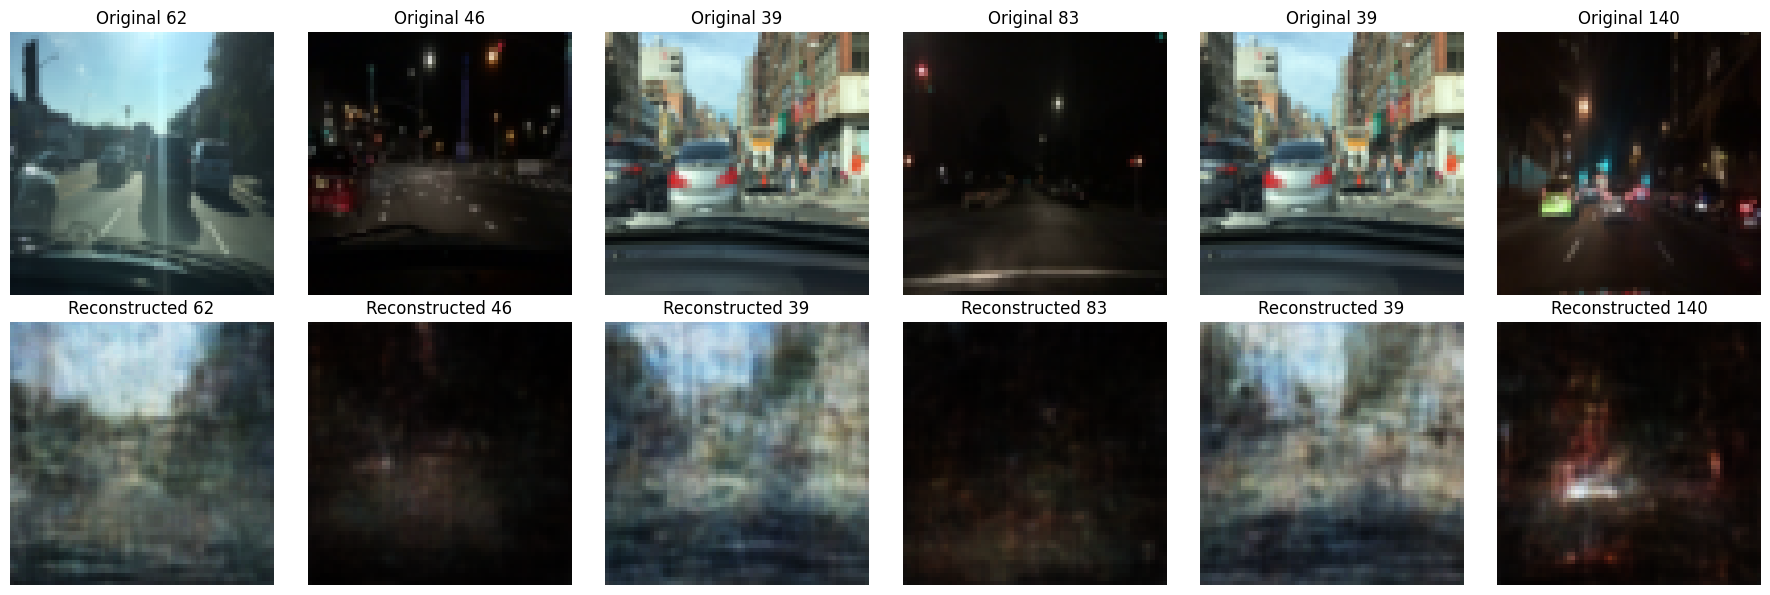

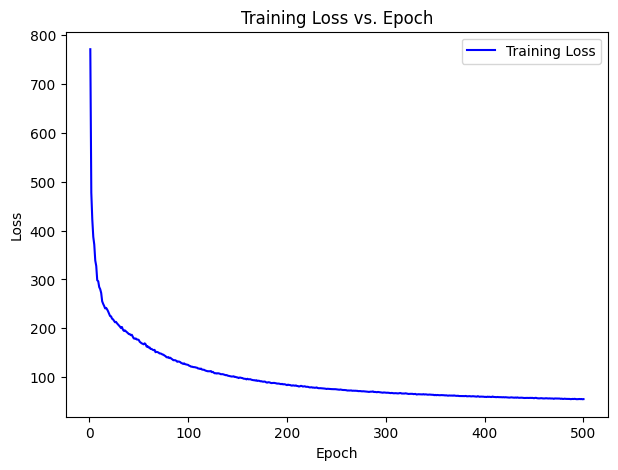

In [28]:
import os
import cv2
import numpy as np
import hashlib
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm

##############################################
# 1) Configuration & Paths
##############################################

current_dir = os.getcwd()
csv_train   = os.path.join(current_dir, "train_data.csv")
csv_test    = os.path.join(current_dir, "test_data.csv")
video_dir   = os.path.join(current_dir, "bdd100k", "videos")  # Update this path as needed

# Basic hyperparameters
BATCH_SIZE    = 4
IMAGE_SIZE    = 64
EPOCHS        = 500
LEARNING_RATE = 2e-4

# VAE hyperparameters
EMBED_DIM = 32
LATENT_DIM = 100  # Size of the latent vector (z)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

##############################################
# 2) Dataset (Downscaled-average -> Embedding Vec)
##############################################

class VAEFrameDataset(Dataset):
    """
    For each CSV row:
      - Reads the first frame from the video.
      - Downscales the frame to a small resolution.
      - Takes the average of that downscaled frame (scalar).
      - Replicates that average to create a float embedding vector of length EMBED_DIM.
      - Returns (embedding_vector, transformed_frame).
    """
    def __init__(self, csv_file, video_root, transform=None, downscale_size=8):
        super().__init__()
        self.data = pd.read_csv(csv_file)
        self.video_root = video_root
        self.transform = transform
        self.downscale_size = downscale_size
        self.samples = []
        
        for _, row in self.data.iterrows():
            fname = row['filename']
            video_path = os.path.join(self.video_root, fname)

            cap = cv2.VideoCapture(video_path)
            ret, frame = cap.read()
            cap.release()
            if not ret:
                continue  # skip if no frame read

            # Convert BGR -> RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # ------------------------------------
            # 1) Downscale the frame to e.g. 8×8
            # ------------------------------------
            frame_small = cv2.resize(
                frame_rgb, 
                (self.downscale_size, self.downscale_size), 
                interpolation=cv2.INTER_AREA
            )
            
            # ------------------------------------
            # 2) Take the average across all pixels and channels
            #    => a single scalar
            # ------------------------------------
            avg_val = frame_small.mean() / 255.0  # scale into [0, 1]
            
            # ------------------------------------
            # 3) Replicate that scalar to create
            #    a vector of length EMBED_DIM
            # ------------------------------------
            embed_array = np.full((EMBED_DIM,), avg_val, dtype=np.float32)
            embed_vec   = torch.tensor(embed_array)

            # Transform the original full-size frame for the final image input
            pil_image = Image.fromarray(frame_rgb)
            if self.transform:
                pil_image = self.transform(pil_image)

            # Store
            self.samples.append((embed_vec, pil_image))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]


# Transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # => shape [3, 64, 64]
])

# Create datasets & loaders
train_dataset = VAEFrameDataset(csv_train, video_dir, transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset  = VAEFrameDataset(csv_test, video_dir, transform=transform)
test_loader   = DataLoader(test_dataset, batch_size=1, shuffle=False)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

##############################################
# 3) VAE Architecture
##############################################

class Encoder(nn.Module):
    """
    Encoder of the VAE.
    Inputs:
        - x: [batch, 3, 64, 64] image
        - y: [batch, EMBED_DIM] embedding vector
    Outputs:
        - mu: [batch, LATENT_DIM]
        - logvar: [batch, LATENT_DIM]
    """
    def __init__(self, img_channels=3, embed_dim=32, latent_dim=100):
        super(Encoder, self).__init__()
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim

        # Process image
        self.image_conv = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1),  # [64,32,32]
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),          # [128,16,16]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),         # [256,8,8]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, 1),         # [512,4,4]
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # Process embedding
        self.embed_fc = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
        )

        # Combine and produce mu and logvar
        self.fc_mu = nn.Linear(512*4*4 + 256, latent_dim)
        self.fc_logvar = nn.Linear(512*4*4 + 256, latent_dim)

    def forward(self, x, y):
        x = self.image_conv(x)                  # [batch, 512,4,4]
        x = x.view(x.size(0), -1)              # [batch, 512*4*4]
        y = self.embed_fc(y)                    # [batch, 256]
        combined = torch.cat((x, y), dim=1)     # [batch, 512*4*4 + 256]
        mu = self.fc_mu(combined)               # [batch, latent_dim]
        logvar = self.fc_logvar(combined)       # [batch, latent_dim]
        return mu, logvar

class Decoder(nn.Module):
    """
    Decoder of the VAE.
    Inputs:
        - z: [batch, LATENT_DIM] latent vector
        - y: [batch, EMBED_DIM] embedding vector
    Outputs:
        - reconstructed_x: [batch, 3, 64, 64]
    """
    def __init__(self, img_channels=3, embed_dim=32, latent_dim=100):
        super(Decoder, self).__init__()
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim

        # Combine z and y
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + embed_dim, 512*4*4),
            nn.ReLU(),
        )

        # Deconvolution layers
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # [256,8,8]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # [128,16,16]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # [64,32,32]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1),  # [3,64,64]
            nn.Sigmoid(),
        )

    def forward(self, z, y):
        combined = torch.cat((z, y), dim=1)      # [batch, latent_dim + embed_dim]
        x = self.fc(combined)                    # [batch, 512*4*4]
        x = x.view(x.size(0), 512, 4, 4)         # [batch,512,4,4]
        reconstructed_x = self.deconv(x)         # [batch,3,64,64]
        return reconstructed_x

class VAE(nn.Module):
    """
    Variational Autoencoder combining Encoder and Decoder.
    """
    def __init__(self, img_channels=3, embed_dim=32, latent_dim=100):
        super(VAE, self).__init__()
        self.encoder = Encoder(img_channels, embed_dim, latent_dim)
        self.decoder = Decoder(img_channels, embed_dim, latent_dim)
    
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        """
        std = torch.exp(0.5 * logvar)            # [batch, latent_dim]
        eps = torch.randn_like(std)              # [batch, latent_dim]
        return mu + eps * std                    # [batch, latent_dim]
    
    def forward(self, x, y):
        mu, logvar = self.encoder(x, y)          # [batch, latent_dim], [batch, latent_dim]
        z = self.reparameterize(mu, logvar)      # [batch, latent_dim]
        reconstructed_x = self.decoder(z, y)     # [batch,3,64,64]
        return reconstructed_x, mu, logvar

##############################################
# 4) Instantiate Models and Optimizers
##############################################

# Instantiate the VAE
vae = VAE(img_channels=3, embed_dim=EMBED_DIM, latent_dim=LATENT_DIM).to(device)

# Initialize weights (optional but recommended)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('ConvTranspose') != -1:
        nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in', nonlinearity='relu')
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

vae.apply(weights_init)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

# Loss Function
# Reconstruction loss + KL Divergence
def loss_function(recon_x, x, mu, logvar):
    # BCE Loss
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    
    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD

##############################################
# 5) Training Loop for VAE
##############################################

# Initialize lists to store loss values
epoch_losses = []

print("Starting Training...")

for epoch in range(1, EPOCHS + 1):
    vae.train()
    train_loss = 0
    for batch_idx, (embed_vec, real_imgs) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")):
        real_imgs = real_imgs.to(device)                    # [batch,3,64,64]
        embed_vec = embed_vec.to(device)                    # [batch, EMBED_DIM]
        
        optimizer.zero_grad()
        recon_imgs, mu, logvar = vae(real_imgs, embed_vec)  # [batch,3,64,64], [batch, latent_dim], [batch, latent_dim]
        loss = loss_function(recon_imgs, real_imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_loss = train_loss / len(train_loader.dataset)
    epoch_losses.append(avg_loss)
    print(f"==> Epoch {epoch}/{EPOCHS} Average loss: {avg_loss:.4f}")

print("Training complete!")

##############################################
# 6) Sampling from the VAE
##############################################

def sample_vae(vae, embed_vec, device='cpu'):
    """
    Generates a sample image from the VAE given an embedding vector.
    """
    vae.eval()
    with torch.no_grad():
        embed_vec = embed_vec.to(device).unsqueeze(0)        # [1, EMBED_DIM]
        mu, logvar = vae.encoder(None, embed_vec)           # Since Encoder expects image input, need to adjust
        # Modify Encoder to handle cases where image input is None
        # Alternatively, directly sample z from standard normal
        z = torch.randn(1, LATENT_DIM).to(device)
        generated = vae.decoder(z, embed_vec)               # [1,3,64,64]
    return generated

##############################################
# 7) Visualization: Original vs. Reconstructed Images
##############################################

# Ensure test dataset has enough samples
num_samples = min(6, len(test_dataset))  # Pick up to 6 samples

if num_samples > 0:
    fig, axs = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))  # 2 rows, 'num_samples' columns

    vae.eval()  # Ensure the VAE is in evaluation mode

    for i in range(num_samples):
        # Choose a random index
        idx = np.random.randint(0, len(test_dataset))

        # Retrieve stored embedding vector and real image
        embed_vec, real_img = test_dataset[idx]
        real_img = real_img.unsqueeze(0).to(device)    # [1,3,64,64]
        embed_vec = embed_vec.unsqueeze(0).to(device)  # [1, EMBED_DIM]

        with torch.no_grad():
            reconstructed, mu, logvar = vae(real_img, embed_vec)  # [1,3,64,64]

        # Move tensors to CPU and convert to NumPy
        real_np = real_img.squeeze(0).cpu().numpy().transpose(1, 2, 0)         # [64,64,3]
        recon_np = reconstructed.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # [64,64,3]

        # Plot Original Image
        axs[0, i].imshow(real_np)
        axs[0, i].set_title(f"Original {idx}")
        axs[0, i].axis("off")

        # Plot Reconstructed Image
        axs[1, i].imshow(recon_np)
        axs[1, i].set_title(f"Reconstructed {idx}")
        axs[1, i].axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("No test samples to visualize.")

##############################################
# 8) Plotting Training Loss
##############################################

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs_range, epoch_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()
plt.show()


# VAE-Transformer Model for Semantics 01/22/2025

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

##############################################
# 1) Configuration & Paths
##############################################

current_dir = os.getcwd()
csv_train   = os.path.join(current_dir, "train_data.csv")
csv_test    = os.path.join(current_dir, "test_data.csv")
video_dir   = os.path.join(current_dir, "bdd100k", "videos")  # Update this path as needed

# Basic hyperparameters
BATCH_SIZE    = 32  # Increased batch size if GPU memory allows
IMAGE_SIZE    = 64
EPOCHS        = 50  # Adjust as needed
LEARNING_RATE = 2e-4

# Model hyperparameters
LATENT_DIM = 256  # Size of the latent vector produced by the Encoder
NUM_TRANSFORMER_LAYERS = 3  # Reduced from 6
NUM_HEADS = 4                # Reduced from 8
DIM_FEEDFORWARD = 512        # Reduced from 1024
DROPOUT = 0.1
PATCH_SIZE = 16              # Using 16x16 patches

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

##############################################
# 2) Dataset (Direct Image Input)
##############################################

class FrameAutoencoderDataset(Dataset):
    """
    For each CSV row:
      - Reads the first frame from the video.
      - Applies transformations to the frame.
      - Returns the transformed frame.
    """
    def __init__(self, csv_file, video_root, transform=None):
        super().__init__()
        self.data = pd.read_csv(csv_file)
        self.video_root = video_root
        self.transform = transform
        self.samples = []
        
        for _, row in self.data.iterrows():
            fname = row['filename']
            video_path = os.path.join(self.video_root, fname)

            cap = cv2.VideoCapture(video_path)
            ret, frame = cap.read()
            cap.release()
            if not ret:
                continue  # skip if no frame read

            # Convert BGR -> RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Transform the original full-size frame for the final image input
            pil_image = Image.fromarray(frame_rgb)
            if self.transform:
                pil_image = self.transform(pil_image)

            # Store
            self.samples.append(pil_image)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]

# Transforms with Data Augmentation
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),  # => shape [3, 64, 64]
])

# Create datasets & loaders
train_dataset = FrameAutoencoderDataset(csv_train, video_dir, transform=transform)
train_loader  = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,           # Increased number of workers
    pin_memory=True          # Enable pin_memory
)

test_dataset  = FrameAutoencoderDataset(csv_test, video_dir, transform=transform)
test_loader   = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True
)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

##############################################
# 3) Model Architectures
##############################################

class Encoder(nn.Module):
    """
    Encoder that processes images to produce latent vectors.
    Inputs:
        - x: [batch, 3, 64, 64] image
    Outputs:
        - latent: [batch, LATENT_DIM]
    """
    def __init__(self, img_channels=3, latent_dim=256):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim

        # Depthwise Separable Convolutional layers to reduce computation
        self.image_conv = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1, groups=1),  # [64,32,32]
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, groups=1),        # [128,16,16]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, groups=1),       # [256,8,8]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, groups=1),       # [512,4,4]
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # Fully connected layers to map to latent space
        self.fc = nn.Sequential(
            nn.Linear(512 * 4 * 4, latent_dim),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.image_conv(x)                  # [batch, 512,4,4]
        x = x.view(x.size(0), -1)              # [batch, 512*4*4]
        latent = self.fc(x)                     # [batch, latent_dim]
        return latent

class TransformerDecoder(nn.Module):
    """
    Transformer-based Decoder that reconstructs images from latent vectors using patches.
    Inputs:
        - latent: [batch, LATENT_DIM]
    Outputs:
        - reconstructed_x: [batch, 3, 64, 64]
    """
    def __init__(self, img_channels=3, latent_dim=256, image_size=64, patch_size=16, num_layers=3, num_heads=4, dim_feedforward=512, dropout=0.1, k=256):
        super(TransformerDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.image_size = image_size
        self.patch_size = patch_size
        self.img_channels = img_channels
        self.num_patches = (image_size // patch_size) ** 2
        self.dim_feedforward = dim_feedforward

        # Project latent vector to Transformer embedding dimension
        self.latent_proj = nn.Linear(latent_dim, dim_feedforward)

        # Positional Encoding (learnable)
        self.positional_encoding = nn.Parameter(torch.zeros(1, self.num_patches, dim_feedforward))
        nn.init.xavier_uniform_(self.positional_encoding)

        # Transformer Decoder using standard TransformerDecoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=dim_feedforward, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Final projection to image patches
        self.output_proj = nn.Linear(dim_feedforward, img_channels * patch_size * patch_size)

    def forward(self, latent):
        """
        latent: [batch, LATENT_DIM]
        """
        batch_size = latent.size(0)
        seq_length = self.num_patches  # Number of patches

        # Project latent vector
        memory = self.latent_proj(latent)  # [batch, dim_feedforward]

        # Expand memory to [batch, seq_length, dim_feedforward]
        memory = memory.unsqueeze(1).repeat(1, seq_length, 1)  # [batch, seq_length, dim_feedforward]

        # Prepare target sequence (learnable embeddings)
        target = torch.zeros(batch_size, seq_length, self.dim_feedforward).to(latent.device)  # [batch, seq_length, dim_feedforward]

        # Add positional encoding
        target = target + self.positional_encoding  # [batch, seq_length, dim_feedforward]

        # Transformer expects [seq_length, batch, dim]
        memory = memory.permute(1, 0, 2)  # [seq_length, batch, dim_feedforward]
        target = target.permute(1, 0, 2)  # [seq_length, batch, dim_feedforward]

        # Decode
        decoded = self.transformer_decoder(tgt=target, memory=memory)  # [seq_length, batch, dim_feedforward]

        # Permute back
        decoded = decoded.permute(1, 0, 2)  # [batch, seq_length, dim_feedforward]

        # Project to image patches
        decoded = self.output_proj(decoded)  # [batch, seq_length, img_channels * patch_size * patch_size]

        # Reshape to image patches
        decoded = decoded.view(batch_size, self.num_patches, self.img_channels, self.patch_size, self.patch_size)  # [batch, num_patches, 3, patch, patch]
        decoded = decoded.permute(0, 2, 3, 1, 4).contiguous()  # [batch, 3, patch, num_patches, patch]
        reconstructed_x = decoded.view(batch_size, self.img_channels, self.image_size, self.image_size)  # [batch, 3, 64, 64]

        # Apply activation
        reconstructed_x = torch.sigmoid(reconstructed_x)  # Ensure outputs are in [0,1]

        return reconstructed_x

class Autoencoder(nn.Module):
    """
    Autoencoder combining Encoder and Transformer-based Decoder.
    """
    def __init__(self, img_channels=3, latent_dim=256, image_size=64, patch_size=16, num_layers=3, num_heads=4, dim_feedforward=512, dropout=0.1):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(img_channels, latent_dim)
        self.decoder = TransformerDecoder(
            img_channels=img_channels, 
            latent_dim=latent_dim, 
            image_size=image_size, 
            patch_size=patch_size,
            num_layers=num_layers, 
            num_heads=num_heads, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
            k=256
        )
    
    def forward(self, x):
        latent = self.encoder(x)             # [batch, latent_dim]
        reconstructed_x = self.decoder(latent)  # [batch, 3, 64, 64]
        return reconstructed_x

##############################################
# 4) Instantiate Models and Optimizers
##############################################

# Instantiate the Autoencoder
autoencoder = Autoencoder(
    img_channels=3, 
    latent_dim=LATENT_DIM, 
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    num_layers=NUM_TRANSFORMER_LAYERS,
    num_heads=NUM_HEADS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT
).to(device)

# Initialize weights (optional but recommended)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('ConvTranspose') != -1 or classname.find('Linear') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in', nonlinearity='relu')
    if classname.find('BatchNorm') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.constant_(m.weight.data, 1)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

autoencoder.apply(weights_init)

# Optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)

# Loss Function
# Reconstruction loss (Mean Squared Error)
def loss_function(recon_x, x):
    """
    Computes the Mean Squared Error loss between reconstructed and original images.
    """
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    return MSE

##############################################
# 5) Training Loop for Autoencoder
##############################################

# Initialize lists to store loss values
epoch_losses = []

# Initialize GradScaler for mixed precision
scaler = GradScaler()

print("Starting Training...")

for epoch in range(1, EPOCHS + 1):
    autoencoder.train()
    train_loss = 0
    for batch_idx, real_imgs in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")):
        real_imgs = real_imgs.to(device)  # [batch,3,64,64]
        
        optimizer.zero_grad()
        
        with autocast():
            recon_imgs = autoencoder(real_imgs)  # [batch,3,64,64]
            loss = loss_function(recon_imgs, real_imgs)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
    
    avg_loss = train_loss / len(train_loader.dataset)
    epoch_losses.append(avg_loss)
    print(f"==> Epoch {epoch}/{EPOCHS} Average loss: {avg_loss:.6f}")

print("Training complete!")

##############################################
# 6) Visualization: Original vs. Reconstructed Images
##############################################

# Ensure test dataset has enough samples
num_samples = min(6, len(test_dataset))  # Pick up to 6 samples

if num_samples > 0:
    fig, axs = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))  # 2 rows, 'num_samples' columns

    autoencoder.eval()  # Ensure the Autoencoder is in evaluation mode

    with torch.no_grad():
        for i in range(num_samples):
            # Choose a random index
            idx = np.random.randint(0, len(test_dataset))

            # Retrieve the real image
            real_img = test_dataset[idx]             # [3,64,64]

            # Add a batch dimension and move to device
            real_img = real_img.unsqueeze(0).to(device)    # [1,3,64,64]

            # Pass through Autoencoder
            reconstructed = autoencoder(real_img)  # [1,3,64,64]

            # Move tensors to CPU and convert to NumPy
            real_np = real_img.squeeze(0).cpu().numpy().transpose(1, 2, 0)         # [64,64,3]
            recon_np = reconstructed.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # [64,64,3]

            # Ensure pixel values are in [0, 1]
            real_np = np.clip(real_np, 0, 1)
            recon_np = np.clip(recon_np, 0, 1)

            # Plot Original Image
            axs[0, i].imshow(real_np)
            axs[0, i].set_title(f"Original {idx}")
            axs[0, i].axis("off")

            # Plot Reconstructed Image
            axs[1, i].imshow(recon_np)
            axs[1, i].set_title(f"Reconstructed {idx}")
            axs[1, i].axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("No test samples to visualize.")

##############################################
# 7) Plotting Training Loss
##############################################

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10,5))
plt.plot(epochs_range, epoch_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()


Using device: cuda
Number of training samples: 700
Number of testing samples: 150
Starting Training...


Epoch 1/50:   0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Parameters
num_samples = min(6, len(test_dataset))  # Number of samples to visualize

if num_samples > 0:
    # Create a figure with 2 rows: one for original images, one for reconstructed images
    fig, axs = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))  # 2 rows, 'num_samples' columns

    autoencoder.eval()  # Set the autoencoder to evaluation mode

    with torch.no_grad():  # Disable gradient calculation
        for i in range(num_samples):
            # Choose a random index from the test dataset
            idx = np.random.randint(0, len(test_dataset))

            # Retrieve the embedding vector (y) and the real image (x) from the dataset
            embed_vec, real_img = test_dataset[idx]

            # Add a batch dimension and move tensors to the appropriate device
            real_img = real_img.unsqueeze(0).to(device)    # Shape: [1, 3, 64, 64]
            embed_vec = embed_vec.unsqueeze(0).to(device)  # Shape: [1, EMBED_DIM]

            # Pass the real image and embedding vector through the autoencoder to get the reconstructed image
            reconstructed_img = autoencoder(real_img, embed_vec)  # Shape: [1, 3, 64, 64]

            # Move tensors to CPU and convert to NumPy for visualization
            real_np = real_img.squeeze(0).cpu().numpy().transpose(1, 2, 0)          # Shape: [64, 64, 3]
            recon_np = reconstructed_img.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Shape: [64, 64, 3]

            # Ensure pixel values are in [0, 1]
            real_np = np.clip(real_np, 0, 1)
            recon_np = np.clip(recon_np, 0, 1)

            # Plot Original Image
            axs[0, i].imshow(real_np)
            axs[0, i].set_title(f"Original {idx}")
            axs[0, i].axis("off")

            # Plot Reconstructed Image
            axs[1, i].imshow(recon_np)
            axs[1, i].set_title(f"Reconstructed {idx}")
            axs[1, i].axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("No test samples to visualize.")


# Frame -> FFT -> Reconstruction

Using CuPy for Ultra-Fast FFT 🚀
🔥 Processing Time for 10 images: 0.0020 sec (~0.0002 sec per image)


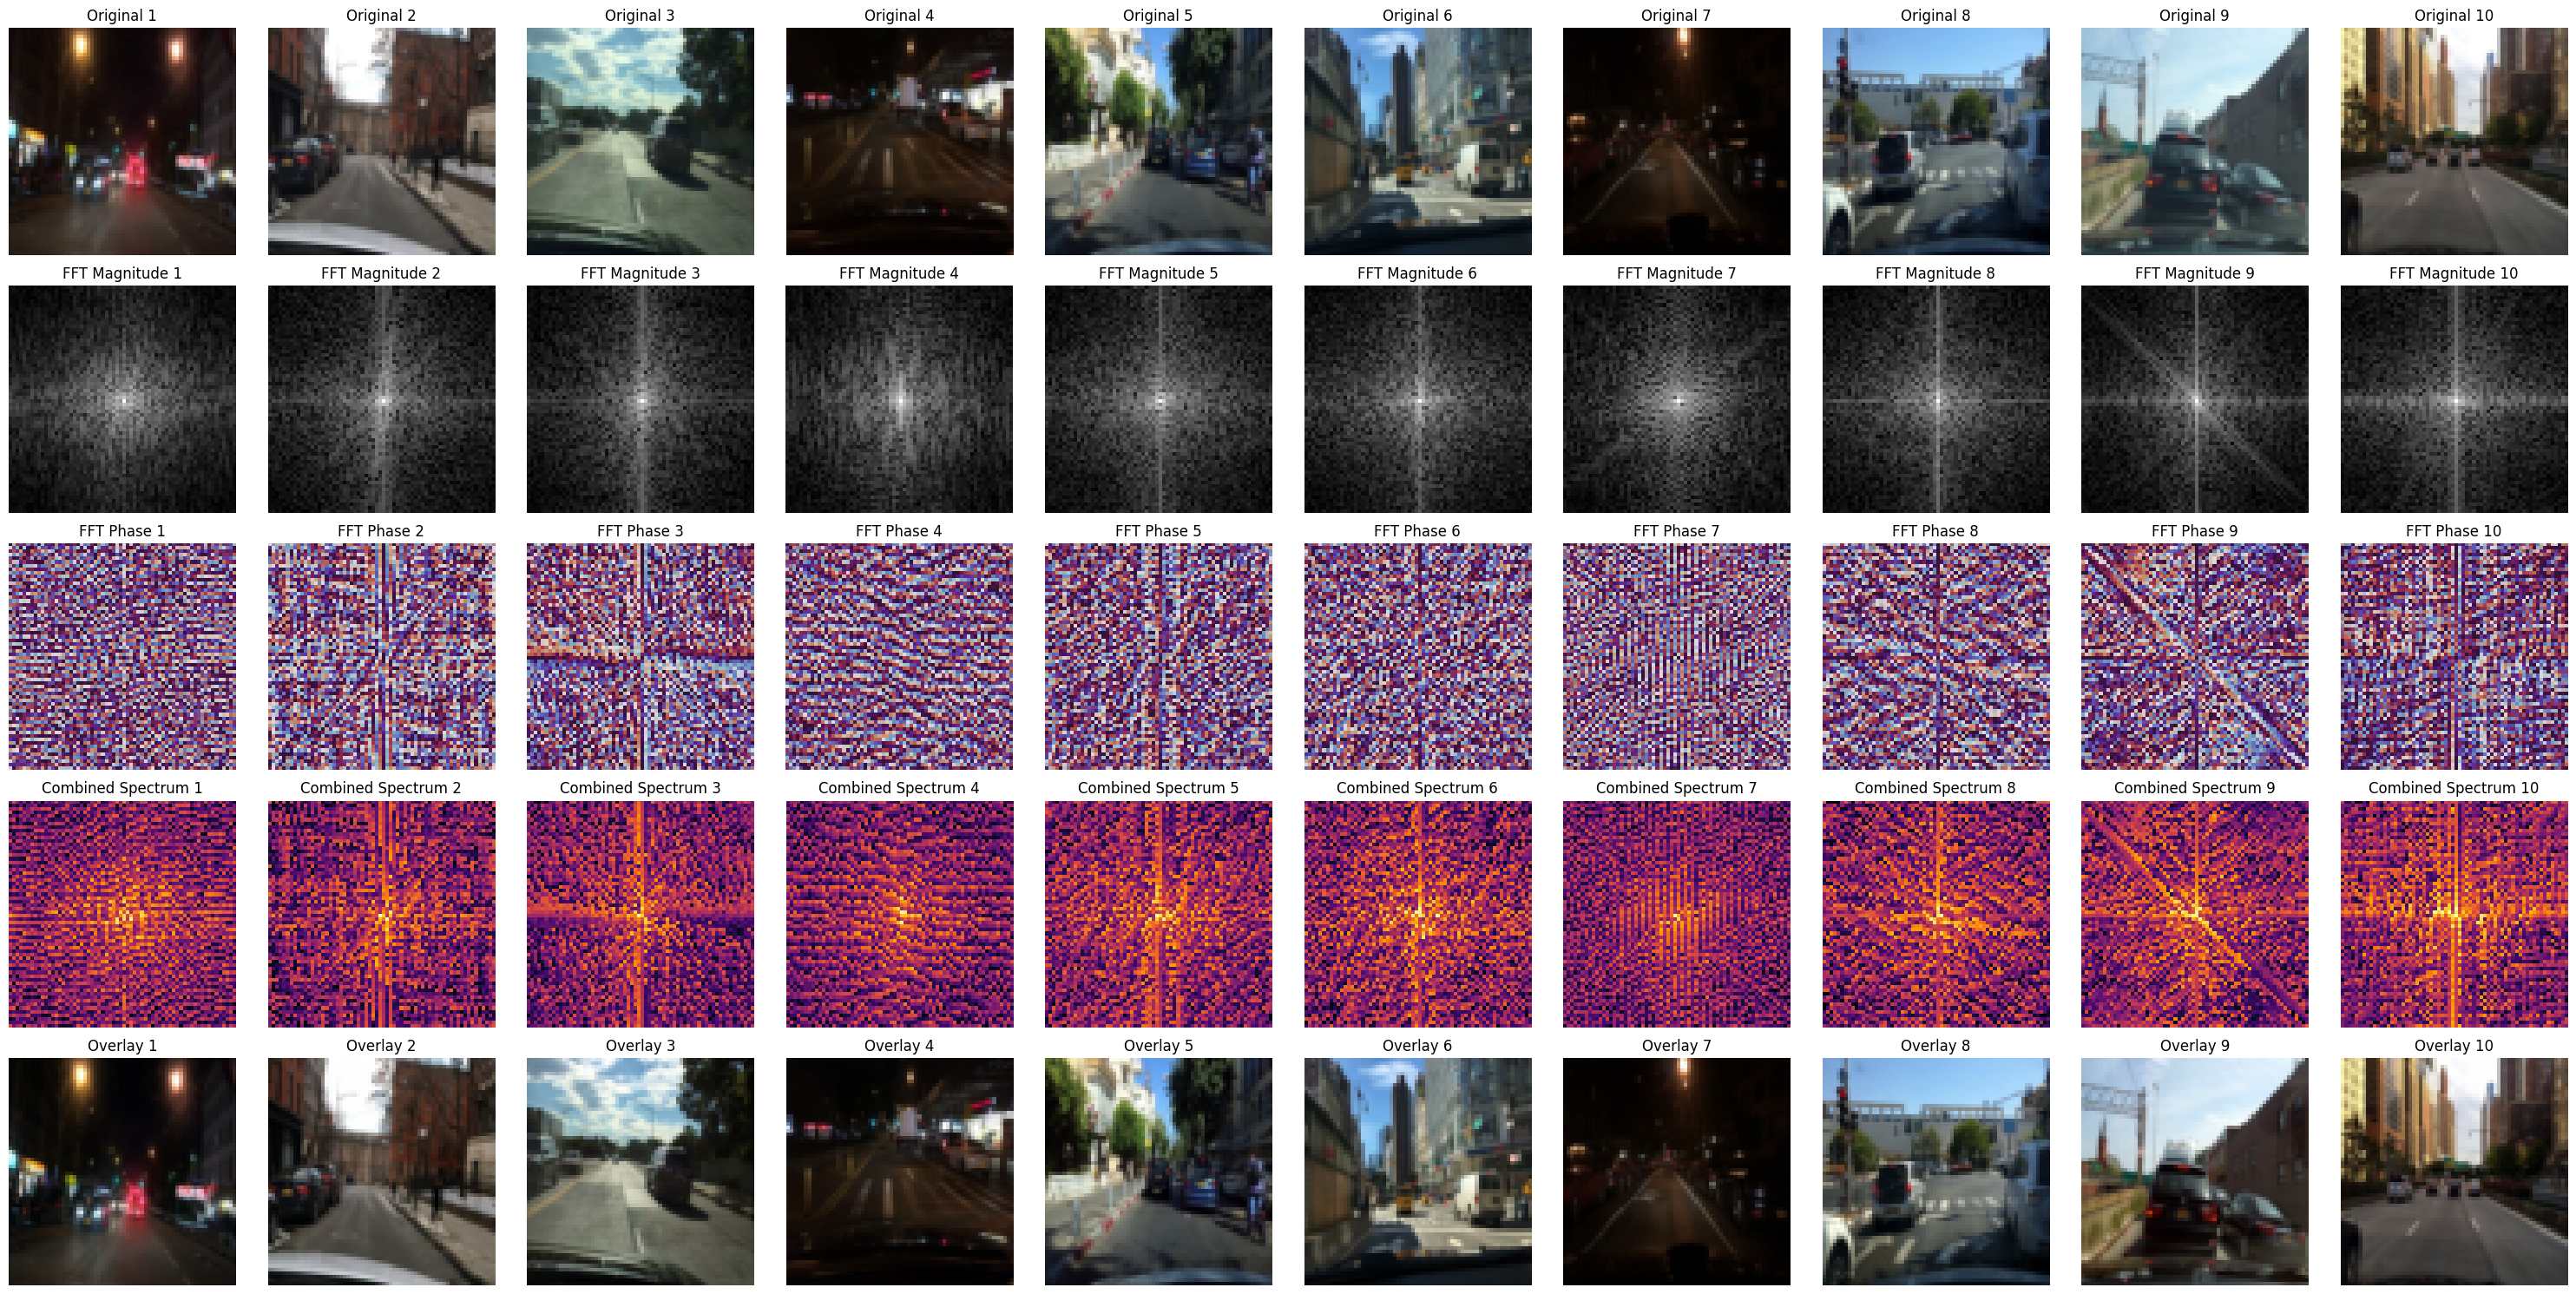

In [19]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import cupy as cp
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import time

##############################################
# 1) Configuration & Paths
##############################################

current_dir = os.getcwd()
csv_train   = os.path.join(current_dir, "train_data.csv")  # CSV containing .mov filenames
video_dir   = os.path.join(current_dir, "bdd100k", "videos")  # Directory where videos are stored

IMAGE_SIZE = 64  # Resize images for processing
print("Using CuPy for Ultra-Fast FFT 🚀")

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

##############################################
# 2) Dataset Class for Video Frames
##############################################

class VideoFrameDataset(Dataset):
    def __init__(self, csv_file, video_root, transform=None):
        super().__init__()
        self.data = pd.read_csv(csv_file)
        self.video_root = video_root
        self.transform = transform
        self.samples = []

        for _, row in self.data.iterrows():
            fname = row['filename']
            video_path = os.path.join(self.video_root, fname)
            cap = cv2.VideoCapture(video_path)
            ret, frame = cap.read()
            cap.release()
            if not ret:
                continue
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(frame_rgb)
            if self.transform:
                pil_image = self.transform(pil_image)
            self.samples.append(pil_image)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]

train_dataset = VideoFrameDataset(csv_train, video_dir, transform=transform)

##############################################
# 3) Ultra-Fast CuPy FFT Processing
##############################################

def image_to_fft_cupy_fast(images):
    images = images.numpy().astype(np.float32)
    images_cp = cp.asarray(images)
    fft_result = cp.fft.fftshift(cp.fft.fft2(images_cp), axes=(-2, -1))
    return fft_result

def fft_to_image_cupy_fast(fft_shifted):
    magnitude = cp.abs(fft_shifted)
    phase = cp.angle(fft_shifted)
    f_ishift = cp.fft.ifftshift(magnitude * cp.exp(1j * phase), axes=(-2, -1))
    img_reconstructed = cp.real(cp.fft.ifft2(f_ishift))
    img_reconstructed -= img_reconstructed.min(axis=(2,3), keepdims=True)
    img_reconstructed /= img_reconstructed.max(axis=(2,3), keepdims=True) + 1e-8
    return cp.asnumpy(img_reconstructed).astype(np.float32)

##############################################
# 4) Load and Process Multiple Frames
##############################################

def load_sample_frames(dataset, num_samples=10):
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    frames = torch.stack([dataset[i] for i in indices])
    return frames

num_samples = 10
if len(train_dataset) > num_samples:
    sample_frames = load_sample_frames(train_dataset, num_samples=num_samples)
    start_time = time.time()
    fft_shifted = image_to_fft_cupy_fast(sample_frames)
    reconstructed_images = fft_to_image_cupy_fast(fft_shifted)
    end_time = time.time()
    print(f"🔥 Processing Time for {num_samples} images: {end_time - start_time:.4f} sec (~{(end_time - start_time)/num_samples:.4f} sec per image)")

    fig, axs = plt.subplots(5, num_samples, figsize=(num_samples * 3, 15))

    for i in range(num_samples):
        axs[0, i].imshow(sample_frames[i].permute(1, 2, 0).numpy())
        axs[0, i].set_title(f"Original {i+1}")
        axs[0, i].axis("off")

        magnitude_spectrum = np.log(np.abs(cp.asnumpy(fft_shifted[i])) + 1).sum(axis=0)
        axs[1, i].imshow(magnitude_spectrum, cmap='gray')
        axs[1, i].set_title(f"FFT Magnitude {i+1}")
        axs[1, i].axis("off")

        phase_spectrum = np.angle(cp.asnumpy(fft_shifted[i])).sum(axis=0)
        axs[2, i].imshow(phase_spectrum, cmap='twilight')
        axs[2, i].set_title(f"FFT Phase {i+1}")
        axs[2, i].axis("off")

        magnitude_norm = (magnitude_spectrum - magnitude_spectrum.min()) / (magnitude_spectrum.max() - magnitude_spectrum.min())
        phase_norm = (phase_spectrum - phase_spectrum.min()) / (phase_spectrum.max() - phase_spectrum.min())
        combined_spectrum = magnitude_norm + phase_norm

        axs[3, i].imshow(combined_spectrum, cmap='inferno')
        axs[3, i].set_title(f"Combined Spectrum {i+1}")
        axs[3, i].axis("off")

        axs[4, i].imshow(reconstructed_images[i].transpose(1, 2, 0))
        axs[4, i].set_title(f"Overlay {i+1}")
        axs[4, i].axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("Not enough frames in dataset for visualization.")


In [ ]:
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import logging

########################################
# Logging Configuration
########################################

# Configure logging to display timestamps and log levels
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

########################################
# Custom Dataset Definition
########################################

class VideoFrameDataset(Dataset):
    """
    Custom Dataset to load frames from multiple videos listed in a CSV file.
    """

    def __init__(self, csv_path, video_dir, transform=None, max_frames_per_video=None):
        """
        Args:
            csv_path (str): Path to the CSV file containing video filenames.
            video_dir (str): Directory where video files are stored.
            transform (callable, optional): Optional transform to be applied on a frame.
            max_frames_per_video (int, optional): Maximum number of frames to load per video.
        """
        self.video_dir = video_dir
        self.transform = transform
        self.max_frames_per_video = max_frames_per_video

        # Read CSV file
        try:
            self.df = pd.read_csv(csv_path)
            if "filename" in self.df.columns:
                self.video_files = self.df["filename"].tolist()
            else:
                raise ValueError("CSV file must contain a 'filename' column.")
        except Exception as e:
            logging.error(f"Error reading CSV file: {e}")
            raise e

        if not self.video_files:
            raise ValueError("No video filenames found in the CSV file.")

        # Preload frame counts for all videos
        self.video_frame_counts = []
        logging.info("📦 Preloading video frame information...")
        for idx, video_file in enumerate(self.video_files):
            video_path = os.path.join(self.video_dir, video_file)
            if not os.path.exists(video_path):
                logging.warning(f"⚠️ Video file {video_path} does not exist. Skipping.")
                self.video_frame_counts.append(0)
                continue
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                logging.warning(f"⚠️ Failed to open video file {video_path}. Skipping.")
                self.video_frame_counts.append(0)
                continue
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if self.max_frames_per_video:
                frame_count = min(frame_count, self.max_frames_per_video)
            self.video_frame_counts.append(frame_count)
            cap.release()
            logging.info(f"✅ Loaded {frame_count} frames from {video_file} ({idx + 1}/{len(self.video_files)})")

        # Calculate total frames
        self.total_frames = sum(self.video_frame_counts)
        logging.info(f"🎥 Total frames loaded: {self.total_frames}")

    def __len__(self):
        return self.total_frames

    def __getitem__(self, idx):
        """
        Retrieve the frame corresponding to the global index.
        """
        try:
            # Determine which video and frame within the video corresponds to idx
            video_idx = 0
            while video_idx < len(self.video_frame_counts) and idx >= self.video_frame_counts[video_idx]:
                idx -= self.video_frame_counts[video_idx]
                video_idx += 1

            if video_idx >= len(self.video_files):
                raise IndexError("Index out of range in dataset.")

            video_file = self.video_files[video_idx]
            video_path = os.path.join(self.video_dir, video_file)

            # Open video and seek to the desired frame
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                raise ValueError(f"Failed to open video file {video_path}.")

            frame_number = idx
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
            ret, frame = cap.read()
            cap.release()

            if not ret:
                raise ValueError(f"Failed to read frame {frame_number} from {video_path}.")

            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Apply transformations if any
            if self.transform:
                frame = self.transform(frame)

            return frame
        except Exception as e:
            logging.error(f"Error in __getitem__ at index {idx}: {e}")
            # Option 1: Return a black image
            if self.transform:
                default_frame = np.zeros((64, 64, 3), dtype=np.uint8)
                default_frame = self.transform(default_frame)
                return default_frame
            else:
                return torch.zeros(3, 64, 64)

########################################
# Helper Functions
########################################

def image_to_fft(images):
    """
    Compute the FFT of images using PyTorch.
    Args:
        images: Tensor of shape [batch_size, channels, height, width]
    Returns:
        fft_real: Tensor of shape [batch_size, channels, height, width]
        fft_imag: Tensor of shape [batch_size, channels, height, width]
    """
    fft = torch.fft.fft2(images, norm='ortho')
    fft_shifted = torch.fft.fftshift(fft, dim=(-2, -1))
    fft_real = fft_shifted.real
    fft_imag = fft_shifted.imag
    return fft_real, fft_imag

def fft_to_image(fft_real, fft_imag):
    """
    Reconstruct images from FFT real and imaginary parts using PyTorch.
    Args:
        fft_real: Tensor of shape [batch_size, channels, height, width]
        fft_imag: Tensor of shape [batch_size, channels, height, width]
    Returns:
        images: Tensor of shape [batch_size, channels, height, width]
    """
    fft_shifted = torch.complex(fft_real, fft_imag)
    fft_unshifted = torch.fft.ifftshift(fft_shifted, dim=(-2, -1))
    images = torch.fft.ifft2(fft_unshifted, norm='ortho').real
    return images

def visualize_reconstructions(original, fft_real, fft_imag, reconstructed, num_samples=5):
    """
    Visualize original images, FFT magnitude spectra, and reconstructed images.
    Args:
        original: PyTorch tensor of shape [num_samples, channels, height, width]
        fft_real: PyTorch tensor of shape [num_samples, channels, height, width]
        fft_imag: PyTorch tensor of shape [num_samples, channels, height, width]
        reconstructed: PyTorch tensor of shape [num_samples, channels, height, width]
        num_samples: Number of samples to visualize
    """
    fig, axs = plt.subplots(3, num_samples, figsize=(num_samples * 3, 9))
    
    for i in range(num_samples):
        # Original Image
        img = original[i].cpu().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        axs[0, i].imshow(img)
        axs[0, i].set_title(f"Original {i+1}")
        axs[0, i].axis("off")
        
        # FFT Magnitude Spectrum (Sum over Channels)
        magnitude_spectrum = torch.log(torch.sqrt(fft_real[i]**2 + fft_imag[i]**2) + 1).sum(dim=0).cpu().numpy()
        axs[1, i].imshow(magnitude_spectrum, cmap='gray')
        axs[1, i].set_title(f"FFT Spectrum {i+1}")
        axs[1, i].axis("off")
        
        # Reconstructed Image
        recon = reconstructed[i].cpu().permute(1, 2, 0).numpy()
        recon = np.clip(recon, 0, 1)
        axs[2, i].imshow(recon)
        axs[2, i].set_title(f"Reconstructed {i+1}")
        axs[2, i].axis("off")
    
    plt.tight_layout()
    plt.show()

def load_sample_frames(dataset, num_samples=20):
    """
    Load a fixed number of sample frames from the dataset.
    Args:
        dataset: PyTorch dataset
        num_samples: Number of samples to load
    Returns:
        images: PyTorch tensor of shape [num_samples, channels, height, width]
    """
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True, num_workers=0)  # Set num_workers=0 for debugging
    try:
        data = next(iter(loader))
        return data[:num_samples]
    except Exception as e:
        logging.error(f"Error loading sample frames: {e}")
        raise e

########################################
# Model Definitions
########################################

# Generator for Magnitude
class GeneratorMagnitude(nn.Module):
    def __init__(self, latent_dim, feature_maps=64):
        super(GeneratorMagnitude, self).__init__()
        self.main = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(True),
            # State: (feature_maps*8) x 4 x 4
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),
            # State: (feature_maps*4) x 8 x 8
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),
            # State: (feature_maps*2) x 16 x 16
            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),
            # State: (feature_maps) x 32 x 32
            nn.ConvTranspose2d(feature_maps, 3, 4, 2, 1, bias=False),
            nn.Sigmoid()  # Output magnitude between 0 and 1
            # Output: 3 x 64 x 64
        )
    
    def forward(self, input):
        return self.main(input)

# Generator for Phase
class GeneratorPhase(nn.Module):
    def __init__(self, latent_dim, feature_maps=64):
        super(GeneratorPhase, self).__init__()
        self.main = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(True),
            # State: (feature_maps*8) x 4 x 4
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),
            # State: (feature_maps*4) x 8 x 8
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),
            # State: (feature_maps*2) x 16 x 16
            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),
            # State: (feature_maps) x 32 x 32
            nn.ConvTranspose2d(feature_maps, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # Output phase between -1 and 1 (will scale to [-pi, pi])
            # Output: 3 x 64 x 64
        )
    
    def forward(self, input):
        return self.main(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, feature_maps=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 6 x 64 x 64 (real and imaginary parts for 3 channels)
            nn.Conv2d(6, feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (feature_maps) x 32 x 32
            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (feature_maps*2) x 16 x 16
            nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (feature_maps*4) x 8 x 8
            nn.Conv2d(feature_maps * 4, feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (feature_maps*8) x 4 x 4
            nn.Conv2d(feature_maps * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output probability
        )
    
    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

########################################
# Initialization and Hyperparameters
########################################

def initialize_weights(m):
    """
    Initialize model weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('ConvTranspose') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Hyperparameters
latent_dim = 100
feature_maps = 64
batch_size = 32
num_epochs = 50
learning_rate = 0.0002
beta1 = 0.5

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

# Initialize generators and discriminator
netG_mag = GeneratorMagnitude(latent_dim, feature_maps).to(device)
netG_phase = GeneratorPhase(latent_dim, feature_maps).to(device)
netD = Discriminator(feature_maps).to(device)

# Apply weight initialization
netG_mag.apply(initialize_weights)
netG_phase.apply(initialize_weights)
netD.apply(initialize_weights)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG_mag = optim.Adam(netG_mag.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG_phase = optim.Adam(netG_phase.parameters(), lr=learning_rate, betas=(beta1, 0.999))

########################################
# Dataset and DataLoader Preparation
########################################

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),             # Convert numpy array to PIL Image
    transforms.Resize((64, 64)),         # Resize to 64x64
    transforms.ToTensor(),               # Convert PIL Image to Tensor
])

# Paths (Adjust these paths as needed)
current_dir = os.getcwd()
csv_path = os.path.join(current_dir, "train_data.csv")  # Change to test_data.csv if needed
video_dir = os.path.join(current_dir, "bdd100k", "videos")  # Directory where videos are stored

# Create dataset and dataloader
try:
    dataset = VideoFrameDataset(
        csv_path=csv_path,
        video_dir=video_dir,
        transform=transform,
        max_frames_per_video=1000  # Adjust as needed or set to None to load all frames
    )
except Exception as e:
    logging.error(f"Failed to create dataset: {e}")
    raise e

# Initialize DataLoader with num_workers=0 for debugging
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0  # Set to >0 for faster data loading once debugging is complete
)

########################################
# Training Loop
########################################

print("🚀 Starting Training...")

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):  # data contains only images
        ############################
        # (1) Update Discriminator
        ############################
        netD.zero_grad()
        batch_size_curr = data.size(0)
        
        # Real FFTs
        data = data.to(device)
        fft_real, fft_imag = image_to_fft(data)
        real_fft = torch.cat((fft_real, fft_imag), dim=1)  # [B, 6, H, W]
        label_real = torch.full((batch_size_curr,), 1.0, dtype=torch.float, device=device)  # Real label = 1
        output_real = netD(real_fft).view(-1)
        errD_real = criterion(output_real, label_real)
        errD_real.backward()
        D_x = output_real.mean().item()
        
        # Fake FFTs
        noise = torch.randn(batch_size_curr, latent_dim, 1, 1, device=device)
        fake_mag = netG_mag(noise)  # [B, 3, H, W], Sigmoid output
        fake_phase = netG_phase(noise)  # [B, 3, H, W], Tanh output between [-1,1]
        # Scale phase to [-pi, pi]
        fake_phase = fake_phase * np.pi
        # Construct fake FFT using polar coordinates
        fake_fft_real = fake_mag * torch.cos(fake_phase)
        fake_fft_imag = fake_mag * torch.sin(fake_phase)
        fake_fft = torch.cat((fake_fft_real, fake_fft_imag), dim=1)  # [B, 6, H, W]
        label_fake = torch.full((batch_size_curr,), 0.0, dtype=torch.float, device=device)  # Fake label = 0
        output_fake = netD(fake_fft.detach()).view(-1)
        errD_fake = criterion(output_fake, label_fake)
        errD_fake.backward()
        D_G_z1 = output_fake.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        ############################
        # (2) Update Generators
        ############################
        netG_mag.zero_grad()
        netG_phase.zero_grad()
        label_gen = torch.full((batch_size_curr,), 1.0, dtype=torch.float, device=device)  # Generator wants discriminator to believe fakes are real
        output_gen = netD(fake_fft).view(-1)
        errG = criterion(output_gen, label_gen)
        errG.backward()
        D_G_z2 = output_gen.mean().item()
        optimizerG_mag.step()
        optimizerG_phase.step()
        
        # Print statistics
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {i}/{len(dataloader)} \
                  Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} \
                  D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")
    
    # Optional: Visualize progress at each epoch
    with torch.no_grad():
        fixed_noise = torch.randn(5, latent_dim, 1, 1, device=device)
        fake_mag = netG_mag(fixed_noise)
        fake_phase = netG_phase(fixed_noise)
        fake_phase = fake_phase * np.pi
        fake_fft_real = fake_mag * torch.cos(fake_phase)
        fake_fft_imag = fake_mag * torch.sin(fake_phase)
        fake_fft = torch.cat((fake_fft_real, fake_fft_imag), dim=1)
        reconstructed = fft_to_image(fake_fft_real, fake_fft_imag)
        # Select a batch of real images for visualization
        real_images = data[:5]
        real_fft_real, real_fft_imag = image_to_fft(real_images)
        visualize_reconstructions(real_images, real_fft_real[:5], real_fft_imag[:5], reconstructed[:5], num_samples=5)
    
    print(f"🔥 Completed Epoch {epoch+1}/{num_epochs}")

print("🏁 Training Finished!")

########################################
# Final Visualization
########################################

def final_visualization(dataset, device, num_samples=20):
    """
    Perform final visualization of multiple reconstructions.
    Args:
        dataset: PyTorch dataset
        device: Computation device
        num_samples: Number of samples to visualize
    """
    try:
        sample_frames = load_sample_frames(dataset, num_samples=num_samples)
        sample_frames = sample_frames.to(device)
        
        # Measure time for FFT and IFFT
        start_time = time.time()
        
        # Compute FFT
        fft_real, fft_imag = image_to_fft(sample_frames)
        # Reconstruct images
        reconstructed_images = fft_to_image(fft_real, fft_imag)
        
        end_time = time.time()
        print(f"🔥 Processing Time for {num_samples} images: {end_time - start_time:.4f} sec (~{(end_time - start_time)/num_samples:.4f} sec per image)")
        
        ##############################################
        # Visualization of Multiple Reconstructions
        ##############################################
        
        visualize_reconstructions(sample_frames, fft_real, fft_imag, reconstructed_images, num_samples=num_samples)
    except Exception as e:
        logging.error(f"Error during final visualization: {e}")
        raise e

# Perform final visualization
print("🔍 Performing Final Visualization...")
final_visualization(dataset, device, num_samples=20)


2025-01-23 16:03:31,606 - INFO - Using device: cuda
2025-01-23 16:03:31,647 - INFO - 📦 Preloading video frame information...
2025-01-23 16:03:31,660 - INFO - ✅ Loaded 605 frames from 01705c36-8993db9f.mov (1/700)
2025-01-23 16:03:31,675 - INFO - ✅ Loaded 1000 frames from 012a9c41-cef5b320.mov (2/700)
2025-01-23 16:03:31,686 - INFO - ✅ Loaded 1000 frames from 0145b233-ee9c5b63.mov (3/700)
2025-01-23 16:03:31,696 - INFO - ✅ Loaded 1000 frames from 0124dfa6-30a430dc.mov (4/700)
2025-01-23 16:03:31,706 - INFO - ✅ Loaded 1000 frames from 021df36f-9dc059b8.mov (5/700)
2025-01-23 16:03:31,718 - INFO - ✅ Loaded 1000 frames from 029aad77-628b9c45.mov (6/700)
2025-01-23 16:03:31,727 - INFO - ✅ Loaded 1000 frames from 00e100a8-9c852617.mov (7/700)
2025-01-23 16:03:31,737 - INFO - ✅ Loaded 1000 frames from 019588c0-90390013.mov (8/700)
2025-01-23 16:03:31,747 - INFO - ✅ Loaded 1000 frames from 028daae4-27c30b20.mov (9/700)
2025-01-23 16:03:31,755 - INFO - ✅ Loaded 1000 frames from 018aca44-9a616a4

🚀 Starting Training...


2025-01-23 16:03:41,726 - ERROR - Error in __getitem__ at index 849: Failed to read frame 849 from c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\bdd100k\videos\021a0cdd-baff0e6d.mov.


Epoch [1/50] Batch 0/21452                   Loss_D: 1.4093 Loss_G: 7.0700                   D(x): 0.6032 D(G(z)): 0.4824/0.0010


2025-01-23 16:03:42,492 - ERROR - Error in __getitem__ at index 879: Failed to read frame 879 from c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\bdd100k\videos\0128cdde-1f72dcf1.mov.
2025-01-23 16:03:43,363 - ERROR - Error in __getitem__ at index 745: Failed to read frame 745 from c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\bdd100k\videos\000d35d3-41990aa4.mov.
2025-01-23 16:03:47,762 - ERROR - Error in __getitem__ at index 701: Failed to read frame 701 from c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\bdd100k\videos\01746216-8d8edd01.mov.
2025-01-23 16:03:48,121 - ERROR - Error in __getitem__ at index 712: Failed to read frame 712 from c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\bdd100k\videos\01460ec4-a1d65b66.mov.
2025-01-23 16:03:48,982 - ERROR - Error in __getitem__ at index 622: Failed to read frame 622 from c:\Users\keplarV4\Downloads\Githu

Epoch [1/50] Batch 100/21452                   Loss_D: 0.0050 Loss_G: 9.7942                   D(x): 0.9962 D(G(z)): 0.0011/0.0001


2025-01-23 16:07:13,106 - ERROR - Error in __getitem__ at index 817: Failed to read frame 817 from c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\bdd100k\videos\021c4a16-1c50e818.mov.
2025-01-23 16:07:14,932 - ERROR - Error in __getitem__ at index 445: Failed to read frame 445 from c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\bdd100k\videos\02a0f142-c9c4b7d5.mov.
2025-01-23 16:07:18,301 - ERROR - Error in __getitem__ at index 624: Failed to read frame 624 from c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\bdd100k\videos\0182320b-bb377e4e.mov.
2025-01-23 16:07:19,254 - ERROR - Error in __getitem__ at index 865: Failed to read frame 865 from c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\bdd100k\videos\01a6daec-e8c923a8.mov.


KeyboardInterrupt: 

🔥 Processing Time for 20 images: 0.0968 sec (~0.0048 sec per image)


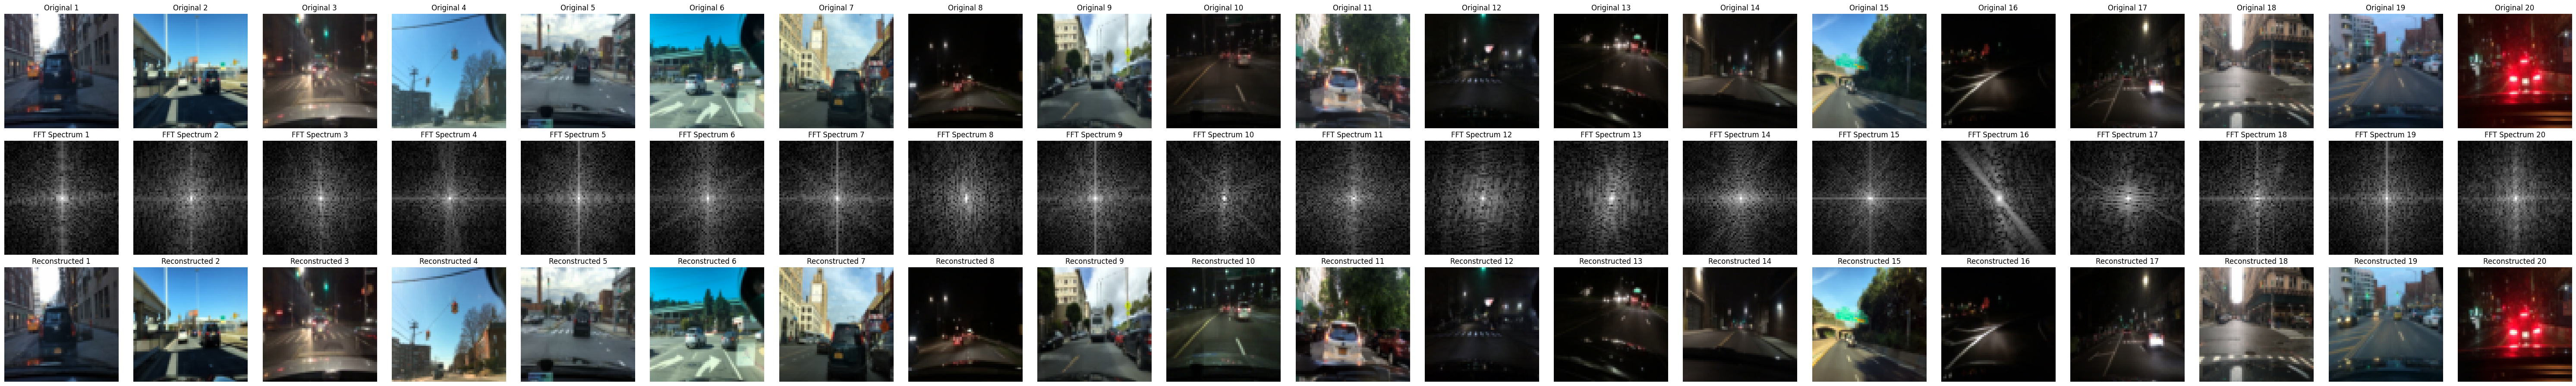

In [11]:
# Select multiple sample frames
num_samples = 20  # Number of different scenes for proof
if len(train_dataset) > num_samples:
    sample_frames = load_sample_frames(train_dataset, num_samples=num_samples)

    # Measure time for FFT and IFFT
    start_time = time.time()

    # Compute batched FFT and inverse FFT using CuPy
    fft_shifted = image_to_fft_cupy_fast(sample_frames)
    reconstructed_images = fft_to_image_cupy_fast(fft_shifted)

    end_time = time.time()
    print(f"🔥 Processing Time for {num_samples} images: {end_time - start_time:.4f} sec (~{(end_time - start_time)/num_samples:.4f} sec per image)")

    ##############################################
    # 5) Visualization of Multiple Reconstructions
    ##############################################

    fig, axs = plt.subplots(3, num_samples, figsize=(num_samples * 3, 9))

    for i in range(num_samples):
        axs[0, i].imshow(sample_frames[i].permute(1, 2, 0).numpy())
        axs[0, i].set_title(f"Original {i+1}")
        axs[0, i].axis("off")

        # FFT Magnitude Spectrum (Sum over RGB)
        magnitude_spectrum = np.log(np.abs(cp.asnumpy(fft_shifted[i])) + 1).sum(axis=0)
        axs[1, i].imshow(magnitude_spectrum, cmap='gray')
        axs[1, i].set_title(f"FFT Spectrum {i+1}")
        axs[1, i].axis("off")

        # Reconstructed Image
        axs[2, i].imshow(reconstructed_images[i].transpose(1, 2, 0))
        axs[2, i].set_title(f"Reconstructed {i+1}")
        axs[2, i].axis("off")

    plt.tight_layout()
    plt.show()

else:
    print("Not enough frames in dataset for visualization.")


In [12]:
import os
import cv2
import cupy as cp
import numpy as np
import pandas as pd
import tkinter as tk
from tkinter import Label, Button
from PIL import Image, ImageTk
import time

##############################################
# 1) Load Video Paths from CSV Dataset
##############################################

current_dir = os.getcwd()
csv_path = os.path.join(current_dir, "train_data.csv")  # Change to test_data.csv if needed
video_dir = os.path.join(current_dir, "bdd100k", "videos")  # Directory where videos are stored

# Read CSV file
df = pd.read_csv(csv_path)

# Get list of video files
video_files = df["filename"].tolist() if "filename" in df.columns else []

if not video_files:
    print("❌ No videos found in CSV!")
    exit()

video_index = 0  # Start with the first video
cap = None  # Placeholder for video capture object

IMAGE_SIZE = 256  # Resize video frame for better quality
fps = 30  # Default FPS
frame_delay = int(1000 / fps)  # Convert FPS to milliseconds

# Persistent references for images (Prevents Garbage Collection)
original_tk = None
fft_tk = None
reconstructed_tk = None

print(f"🎥 Found {len(video_files)} videos. Starting processing...")

##############################################
# 2) CuPy FFT Processing Functions
##############################################

def image_to_fft_cupy(image):
    """
    Computes FFT separately for each color channel using CuPy.

    Parameters:
        image (numpy.ndarray): Input frame (H, W, C).

    Returns:
        fft_rgb (numpy.ndarray): FFT magnitude spectrum as an RGB image.
        fft_result (cp.ndarray): FFT-transformed image (H, W, C) on GPU.
    """
    image_cp = cp.asarray(image).astype(cp.float32)  # Move image to GPU
    fft_result = cp.fft.fftshift(cp.fft.fft2(image_cp, axes=(0, 1)))  # Compute FFT

    # Compute log magnitude spectrum for each channel separately
    fft_magnitude_r = cp.log(cp.abs(fft_result[:, :, 0]) + 1)
    fft_magnitude_g = cp.log(cp.abs(fft_result[:, :, 1]) + 1)
    fft_magnitude_b = cp.log(cp.abs(fft_result[:, :, 2]) + 1)

    # Normalize each channel separately
    fft_magnitude_r /= fft_magnitude_r.max()
    fft_magnitude_g /= fft_magnitude_g.max()
    fft_magnitude_b /= fft_magnitude_b.max()

    # Stack into RGB format
    fft_rgb = cp.stack([fft_magnitude_r, fft_magnitude_g, fft_magnitude_b], axis=-1)

    return cp.asnumpy(fft_rgb * 255).astype(np.uint8), fft_result  # Return CPU RGB FFT + GPU FFT result

def fft_to_image_cupy(fft_result):
    """
    Computes inverse FFT for a single image using CuPy.

    Parameters:
        fft_result (cp.ndarray): FFT-transformed image (H, W, C).

    Returns:
        image_reconstructed (numpy.ndarray): Reconstructed image (H, W, C).
    """
    f_ishift = cp.fft.ifftshift(fft_result, axes=(0, 1))  # Inverse shift
    img_reconstructed = cp.real(cp.fft.ifft2(f_ishift, axes=(0, 1)))  # Inverse FFT

    # Normalize to 0-255
    img_reconstructed -= img_reconstructed.min()
    img_reconstructed /= img_reconstructed.max() + 1e-8
    img_reconstructed *= 255.0

    return cp.asnumpy(img_reconstructed).astype(np.uint8)  # Move back to CPU

##############################################
# 3) GUI Setup
##############################################

root = tk.Tk()
root.title("Real-Time FFT Video Processing")
root.geometry(f"{IMAGE_SIZE*3}x{IMAGE_SIZE+50}")

# Create labels to display video frames
original_label = Label(root)
original_label.grid(row=0, column=0)
fft_label = Label(root)
fft_label.grid(row=0, column=1)
reconstructed_label = Label(root)
reconstructed_label.grid(row=0, column=2)

# Create Video Title label
video_label = Label(root, text="Video: Loading...", font=("Helvetica", 14))
video_label.grid(row=1, column=0)

##############################################
# 4) Load Next Video
##############################################

def load_next_video():
    """
    Loads the next video from the list.
    If no more videos, exit the GUI.
    """
    global video_index, cap, fps, frame_delay

    if video_index >= len(video_files):
        print("✅ All videos processed. Exiting.")
        root.quit()
        return

    video_path = os.path.join(video_dir, video_files[video_index])

    if not os.path.exists(video_path):
        print(f"❌ Error: Video file '{video_path}' not found. Skipping...")
        video_index += 1
        load_next_video()
        return

    print(f"📹 Now processing: {video_files[video_index]} ({video_index+1}/{len(video_files)})")

    if cap is not None:
        cap.release()  # Release previous video

    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS)) if cap.get(cv2.CAP_PROP_FPS) > 0 else 30
    frame_delay = int(1000 / fps)

    video_label.config(text=f"Video: {video_files[video_index]}")
    video_index += 1

    process_frame()  # Start processing new video

##############################################
# 5) Video Processing & GUI Update Function
##############################################

def process_frame():
    """
    Processes one frame at a time and updates the GUI while maintaining the original frame rate.
    """
    global fft_rgb, original_tk, fft_tk, reconstructed_tk

    ret, frame = cap.read()

    if not ret:
        load_next_video()
        return

    # Resize for performance
    frame = cv2.resize(frame, (IMAGE_SIZE, IMAGE_SIZE))

    # Convert BGR -> RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Compute FFT & Inverse FFT
    fft_rgb, fft_result = image_to_fft_cupy(frame_rgb)
    reconstructed_frame = fft_to_image_cupy(fft_result)

    # Convert images for Tkinter and keep persistent references
    original_tk = ImageTk.PhotoImage(Image.fromarray(frame_rgb))
    fft_tk = ImageTk.PhotoImage(Image.fromarray(fft_rgb))
    reconstructed_tk = ImageTk.PhotoImage(Image.fromarray(reconstructed_frame))

    # Update GUI labels (keep references to prevent garbage collection)
    original_label.configure(image=original_tk)
    fft_label.configure(image=fft_tk)
    reconstructed_label.configure(image=reconstructed_tk)

    # Maintain original frame rate
    root.after(int(frame_delay), process_frame)

# Start processing first video
load_next_video()

# Run the GUI
root.mainloop()


🎥 Found 700 videos. Starting processing...
📹 Now processing: 01705c36-8993db9f.mov (1/700)
📹 Now processing: 012a9c41-cef5b320.mov (2/700)
📹 Now processing: 0145b233-ee9c5b63.mov (3/700)
📹 Now processing: 0124dfa6-30a430dc.mov (4/700)
📹 Now processing: 021df36f-9dc059b8.mov (5/700)
📹 Now processing: 029aad77-628b9c45.mov (6/700)


# FFT Combined Mangitude and Phase Transformer

In [79]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import cupy as cp
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import time
import warnings

##############################################
# 1) Configuration & Paths
##############################################

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

current_dir = os.getcwd()
csv_train   = os.path.join(current_dir, "train_data.csv")  # CSV containing .mov filenames
video_dir   = os.path.join(current_dir, "bdd100k", "videos")  # Directory where videos are stored

IMAGE_SIZE = 64  # Resize images for processing
PATCH_SIZE = 8   # Patch size for Transformer
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2  # Total patches
EMBED_DIM = 256  # Embedding size for Transformer
NUM_EPOCHS = 1000  # Number of epochs for training
BATCH_SIZE = 16   # Batch size for training
LEARNING_RATE = 0.5e-4  # Learning rate for optimizer
CHECKPOINT_PATH = os.path.join(current_dir, "transformer_epoch_300.pth")  # Path to save/load checkpoints
TRAIN_TEST_SPLIT = 0.8  # Ratio of data to be used for training

print("Using CuPy for Ultra-Fast FFT 🚀")

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

##############################################
# 2) Dataset Class for Video Frames
##############################################

class VideoFrameDataset(Dataset):
    def __init__(self, csv_file, video_root, transform=None):
        super().__init__()
        self.data = pd.read_csv(csv_file)
        self.video_root = video_root
        self.transform = transform
        self.filenames = self.data['filename'].tolist()
        print(f"Total videos found: {len(self.filenames)}")

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        fname = self.filenames[idx]
        video_path = os.path.join(self.video_root, fname)
        
        if not os.path.exists(video_path):
            print(f"[Warning] Video file {video_path} does not exist. Returning a black image.")
            # Return a black image or handle as needed
            black_image = torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE)
            return black_image
        
        cap = cv2.VideoCapture(video_path)
        ret, frame = cap.read()
        cap.release()
        
        if not ret:
            print(f"[Warning] Failed to read frame from {video_path}. Returning a black image.")
            # Return a black image or handle as needed
            black_image = torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE)
            return black_image
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)
        
        if self.transform:
            pil_image = self.transform(pil_image)
        
        return pil_image

# Initialize dataset
full_dataset = VideoFrameDataset(csv_train, video_dir, transform=transform)
print(f"Dataset initialized with {len(full_dataset)} samples.")

# Split dataset into training and testing
train_size = int(TRAIN_TEST_SPLIT * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")

# Initialize DataLoaders
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
dataloader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)
print("DataLoaders initialized.")

##############################################
# 3) Ultra-Fast CuPy FFT Processing
##############################################

def image_to_fft_cupy_fast(images):
    """
    Convert a batch of images to their FFT magnitude and phase using CuPy for speed.
    
    Args:
        images (torch.Tensor): Batch of images with shape [B, C, H, W].
    
    Returns:
        np.ndarray: Combined magnitude and phase with shape [B, 2, C, H, W].
    """
    # Debug: Check the shape of images
    # print(f"[FFT] Processing batch of shape: {images.shape}")
    
    # Move images to CPU and convert to NumPy
    images_np = images.cpu().numpy().astype(np.float32)
    
    # Transfer to CuPy
    images_cp = cp.asarray(images_np)
    
    # Perform FFT
    fft_result = cp.fft.fftshift(cp.fft.fft2(images_cp, axes=(-2, -1)), axes=(-2, -1))
    
    # Compute magnitude and phase
    magnitude = cp.log(cp.abs(fft_result) + 1)
    phase = cp.angle(fft_result)
    
    # Stack magnitude and phase along a new channel dimension
    combined = cp.stack([magnitude, phase], axis=1)  # [B, 2, C, H, W]
    
    # Transfer back to CPU
    combined_cpu = combined.get()
    
    # Debug: Check the shape after FFT
    # print(f"[FFT] Combined FFT shape: {combined_cpu.shape}")
    
    return combined_cpu

def fft_to_image_cupy_fast(fft_shifted):
    """
    Reconstruct images from their FFT magnitude and phase using CuPy.
    
    Args:
        fft_shifted (np.ndarray): Combined magnitude and phase with shape [B, 2, C, H, W].
    
    Returns:
        np.ndarray: Reconstructed images with shape [B, C, H, W].
    """
    magnitude, phase = fft_shifted[:, 0, :, :, :], fft_shifted[:, 1, :, :, :]
    
    # Reconstruct the FFT
    f_ishift = cp.fft.ifftshift(magnitude * cp.exp(1j * phase), axes=(-2, -1))
    
    # Perform inverse FFT
    img_reconstructed = cp.real(cp.fft.ifft2(f_ishift, axes=(-2, -1)))
    
    # Normalize the reconstructed images
    img_reconstructed -= img_reconstructed.min(axis=(2,3), keepdims=True)
    img_reconstructed /= img_reconstructed.max(axis=(2,3), keepdims=True) + 1e-8
    
    # Transfer back to CPU
    img_reconstructed_cpu = cp.asnumpy(img_reconstructed).astype(np.float32)
    
    return img_reconstructed_cpu

##############################################
# 4) Transformer Model
##############################################

class PatchEmbed(nn.Module):
    def __init__(self, img_size=IMAGE_SIZE, patch_size=PATCH_SIZE, in_chans=6, embed_dim=EMBED_DIM):
        """
        Patch Embedding layer that splits the image into patches and embeds them.
        
        Args:
            img_size (int): Size of the image (assumed square).
            patch_size (int): Size of each patch.
            in_chans (int): Number of input channels.
            embed_dim (int): Dimension of the embedding.
        """
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        """
        Forward pass for patch embedding.
        
        Args:
            x (torch.Tensor): Input tensor with shape [B, in_chans, H, W].
        
        Returns:
            torch.Tensor: Embedded patches with shape [B, N, D].
        """
        x = self.proj(x)  # [B, embed_dim, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)  # [B, N, D]
        return x

class TransformerModel(nn.Module):
    def __init__(self, num_patches=NUM_PATCHES, embed_dim=EMBED_DIM):
        """
        Transformer model for image reconstruction from FFT patches.
        
        Args:
            num_patches (int): Number of patches per image.
            embed_dim (int): Dimension of the embedding.
        """
        super().__init__()
        # Set batch_first=True to align with input tensor shape [B, N, D]
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.decoder = nn.Linear(embed_dim, PATCH_SIZE * PATCH_SIZE * 3)
    
    def forward(self, x):
        """
        Forward pass for the Transformer.
        
        Args:
            x (torch.Tensor): Embedded patches with shape [B, N, D].
        
        Returns:
            torch.Tensor: Reconstructed images with shape [B, 3, H, W].
        """
        x = self.transformer(x)  # [B, N, D]
        x = self.decoder(x)      # [B, N, 3*P*P]
        return x.view(-1, 3, IMAGE_SIZE, IMAGE_SIZE)  # [B, 3, H, W]

# Initialize model, criterion, optimizer
model = TransformerModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Instantiate PatchEmbed once and move to device
patch_embed = PatchEmbed().to(device)

##############################################
# 5) Checkpointing Functions
##############################################

def save_checkpoint(state, filename=CHECKPOINT_PATH):
    """
    Save the training state to a checkpoint file.
    
    Args:
        state (dict): State dictionary containing model, optimizer states, etc.
        filename (str): Path to the checkpoint file.
    """
    torch.save(state, filename)
    print(f"Checkpoint saved at {filename}")

def load_checkpoint(filename=CHECKPOINT_PATH):
    """
    Load the training state from a checkpoint file.
    
    Args:
        filename (str): Path to the checkpoint file.
    
    Returns:
        dict: Loaded state dictionary.
    """
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename, map_location=device)
        return checkpoint
    else:
        print(f"No checkpoint found at '{filename}'. Starting from scratch.")
        return None

##############################################
# 6) Training Loop
##############################################

def train_transformer(num_epochs=NUM_EPOCHS):
    """
    Training loop for the Transformer model.
    
    Args:
        num_epochs (int): Number of training epochs.
    """
    start_epoch = 0
    
    # Load checkpoint if available
    checkpoint = load_checkpoint()
    if checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        patch_embed.load_state_dict(checkpoint['patch_embed_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Resuming training from epoch {start_epoch}")
    else:
        print("Starting training from scratch.")
    
    model.train()
    for epoch in range(start_epoch, num_epochs):
        epoch_loss = 0.0
        start_time = time.time()
        for batch_idx, batch in enumerate(dataloader_train):
            # Debug: Print current batch index
            if batch_idx % 10 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {batch_idx+1}/{len(dataloader_train)}]")
            
            batch = batch.to(device)  # [B, C, H, W]
            
            # Convert images to FFT
            combined_fft = torch.tensor(image_to_fft_cupy_fast(batch), dtype=torch.float32).to(device)
            
            # Reshape combined_fft from [B, 2, 3, 64, 64] to [B, 6, 64, 64]
            batch_size = combined_fft.size(0)
            combined_fft = combined_fft.view(batch_size, 2 * 3, IMAGE_SIZE, IMAGE_SIZE)
            
            # Pass the reshaped tensor to PatchEmbed
            patches = patch_embed(combined_fft)  # [B, N, D]
            
            # Forward pass
            outputs = model(patches)  # [B, 3, H, W]
            loss = criterion(outputs, batch)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        end_time = time.time()
        avg_loss = epoch_loss / len(dataloader_train)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}, Time: {end_time - start_time:.2f}s")
        
        # Optional: Save model checkpoints
        if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
            checkpoint_path = os.path.join(current_dir, f"transformer_epoch_{epoch+1}.pth")
            save_checkpoint({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'patch_embed_state_dict': patch_embed.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, filename=checkpoint_path)
            print(f"Saved checkpoint: {checkpoint_path}")
        
        # Optional: Evaluate on test set after each epoch
        evaluate(model, patch_embed, dataloader_test, criterion)

##############################################
# 7) Evaluation Function
##############################################

def evaluate(model, patch_embed, dataloader_test, criterion):
    """
    Evaluate the model on the test set.
    
    Args:
        model (nn.Module): The Transformer model.
        patch_embed (nn.Module): The PatchEmbed module.
        dataloader_test (DataLoader): DataLoader for the test set.
        criterion (nn.Module): Loss function.
    """
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader_test):
            batch = batch.to(device)  # [B, C, H, W]
            
            # Convert images to FFT
            combined_fft = torch.tensor(image_to_fft_cupy_fast(batch), dtype=torch.float32).to(device)
            
            # Reshape combined_fft from [B, 2, 3, 64, 64] to [B, 6, 64, 64]
            batch_size = combined_fft.size(0)
            combined_fft = combined_fft.view(batch_size, 2 * 3, IMAGE_SIZE, IMAGE_SIZE)
            
            # Pass the reshaped tensor to PatchEmbed
            patches = patch_embed(combined_fft)  # [B, N, D]
            
            # Forward pass
            outputs = model(patches)  # [B, 3, H, W]
            loss = criterion(outputs, batch)
            
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader_test)
    print(f"Validation Loss: {avg_loss:.6f}")
    model.train()

##############################################
# 8) Testing on a Random Image
##############################################

def test_transformer():
    """
    Test the Transformer model on a random image from the test dataset.
    """
    model.eval()
    with torch.no_grad():
        test_idx = np.random.randint(0, len(test_dataset))
        test_img = test_dataset[test_idx].unsqueeze(0).to(device)  # [1, C, H, W]
        combined_fft = torch.tensor(image_to_fft_cupy_fast(test_img), dtype=torch.float32).to(device)
        
        # Reshape combined_fft from [1, 2, 3, 64, 64] to [1, 6, 64, 64]
        combined_fft = combined_fft.view(1, 2 * 3, IMAGE_SIZE, IMAGE_SIZE)
        
        # Pass the reshaped tensor to PatchEmbed
        patches = patch_embed(combined_fft)  # [1, N, D]
        
        # Forward pass
        reconstructed_img = model(patches)  # [1, 3, H, W]
        
        # Convert tensors to NumPy arrays for visualization
        original_np = test_img.cpu().squeeze(0).permute(1, 2, 0).numpy()
        reconstructed_np = reconstructed_img.cpu().squeeze(0).permute(1, 2, 0).numpy()
        
        # Clip values to [0,1] range for display
        original_np = np.clip(original_np, 0, 1)
        reconstructed_np = np.clip(reconstructed_np, 0, 1)
        
        # Plot original and reconstructed images
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(original_np)
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed_np)
        plt.title("Reconstructed by Transformer")
        plt.axis('off')
        
        plt.show()

##############################################
# 9) Main Execution
##############################################


train_transformer()

test_transformer()


Using device: cuda
Using CuPy for Ultra-Fast FFT 🚀
Total videos found: 700
Dataset initialized with 700 samples.
Training samples: 560, Testing samples: 140
DataLoaders initialized.
Loading checkpoint 'c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\transformer_epoch_300.pth'
Resuming training from epoch 300
[Epoch 301/1000] [Batch 1/35]
[Epoch 301/1000] [Batch 11/35]
[Epoch 301/1000] [Batch 21/35]
[Epoch 301/1000] [Batch 31/35]
Epoch [301/1000], Loss: 0.010110, Time: 16.66s
Validation Loss: 0.008386
[Epoch 302/1000] [Batch 1/35]
[Epoch 302/1000] [Batch 11/35]
[Epoch 302/1000] [Batch 21/35]
[Epoch 302/1000] [Batch 31/35]
Epoch [302/1000], Loss: 0.009849, Time: 17.20s
Validation Loss: 0.008668
[Epoch 303/1000] [Batch 1/35]
[Epoch 303/1000] [Batch 11/35]
[Epoch 303/1000] [Batch 21/35]
[Epoch 303/1000] [Batch 31/35]
Epoch [303/1000], Loss: 0.009803, Time: 17.22s
Validation Loss: 0.008506
[Epoch 304/1000] [Batch 1/35]
[Epoch 304/1000] [Batch 11/35]
[Epoch 30

KeyboardInterrupt: 

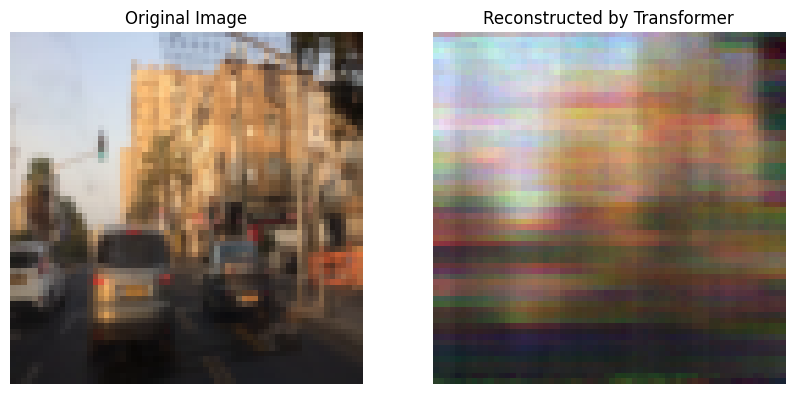

In [88]:
# Perform testing
test_transformer()

# Transformer Future Frame Predictor

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import IterableDataset, DataLoader
from PIL import Image
import time
import warnings
import tkinter as tk
from tkinter import messagebox
from PIL import ImageTk

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

##############################################
# 1) Configuration & Paths
##############################################

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
current_dir = os.getcwd()
csv_train = os.path.join(current_dir, "train_data.csv")  # CSV containing .mov filenames
video_dir = os.path.join(current_dir, "bdd100k", "videos")  # Directory where videos are stored

# Image and model configurations
IMAGE_SIZE = 256  # Increased for better visibility
EMBED_DIM = 256    # Embedding size for Transformer
NUM_HEADS = 8      # Number of attention heads
NUM_LAYERS = 3     # Number of layers in encoder and decoder
NUM_EPOCHS = 100   # Number of training epochs
BATCH_SIZE = 16    # Batch size for training
LEARNING_RATE = 5e-4  # Learning rate for optimizer
CHECKPOINT_DIR = os.path.join(current_dir, "checkpoints")  # Directory to save checkpoints
TRAIN_TEST_SPLIT = 0.8  # Ratio of data to be used for training

# Create checkpoint directory if it doesn't exist
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("Starting the Informer training process...")

# Define image transformations
transform_model = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

transform_display = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
])

##############################################
# 2) Iterable Dataset Class for Streaming Frame Pairs
##############################################

class StreamingVideoFrameDataset(IterableDataset):
    def __init__(self, video_filenames, video_root, transform=None, input_length=1, output_length=1):
        """
        Args:
            video_filenames (list): List of video filenames.
            video_root (str): Directory with all the videos.
            transform (callable, optional): Optional transform to be applied on a sample.
            input_length (int): Number of input frames.
            output_length (int): Number of output frames to predict.
        """
        super().__init__()
        self.video_filenames = video_filenames
        self.video_root = video_root
        self.transform = transform
        self.input_length = input_length
        self.output_length = output_length

    def __iter__(self):
        for fname in self.video_filenames:
            video_path = os.path.join(self.video_root, fname)
            if not os.path.exists(video_path):
                print(f"[Warning] Video file {video_path} does not exist. Skipping.")
                continue  # Skip non-existent videos

            cap = cv2.VideoCapture(video_path)
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frames.append(frame)
            cap.release()

            # Generate (input_frame, future_frame) pairs
            for i in range(len(frames) - self.output_length):
                input_frames = frames[i:i + self.input_length]
                output_frames = frames[i + self.input_length:i + self.input_length + self.output_length]

                # Apply transformations
                input_seq = []
                output_seq = []
                for input_frame in input_frames:
                    frame_rgb = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
                    pil_image = Image.fromarray(frame_rgb)
                    if self.transform:
                        pil_image = self.transform(pil_image)
                    input_seq.append(pil_image)
                input_seq = torch.stack(input_seq)  # [input_length, C, H, W]

                for output_frame in output_frames:
                    frame_rgb = cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB)
                    pil_image = Image.fromarray(frame_rgb)
                    if self.transform:
                        pil_image = self.transform(pil_image)
                    output_seq.append(pil_image)
                output_seq = torch.stack(output_seq)  # [output_length, C, H, W]

                yield input_seq, output_seq

##############################################
# 3) Informer Model with Proper Decoder
##############################################

# Implementing a proper Informer Decoder with Cross-Attention
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, src, src_mask=None):
        src2, _ = self.self_attn(src, src, src, attn_mask=src_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.cross_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        # Cross-attention
        tgt2, _ = self.cross_attn(tgt, memory, memory, attn_mask=memory_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        
        # Feed forward
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

class InformerEncoder(nn.Module):
    def __init__(self, input_size, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1):
        super(InformerEncoder, self).__init__()
        self.d_model = d_model
        self.input_projection = nn.Linear(input_size, d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        src = self.input_projection(src)  # [seq_len, batch_size, d_model]
        src = self.dropout(src)
        for layer in self.layers:
            src = layer(src, src_mask)
        return src  # [seq_len, batch_size, d_model]

class InformerDecoder(nn.Module):
    def __init__(self, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, output_size=3*IMAGE_SIZE*IMAGE_SIZE):
        super(InformerDecoder, self).__init__()
        self.d_model = d_model
        self.target_projection = nn.Linear(output_size, d_model)  # Added projection
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.output_layer = nn.Linear(d_model, output_size)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        tgt = self.target_projection(tgt)  # [seq_len, batch_size, d_model]
        for layer in self.layers:
            tgt = layer(tgt, memory, tgt_mask, memory_mask)
        output = self.output_layer(tgt)  # [seq_len, batch_size, output_size]
        return output

class Informer(nn.Module):
    def __init__(self, input_size=3*IMAGE_SIZE*IMAGE_SIZE, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, output_size=3*IMAGE_SIZE*IMAGE_SIZE):
        super(Informer, self).__init__()
        self.encoder = InformerEncoder(input_size, d_model, n_heads, d_ff, num_layers, dropout)
        self.decoder = InformerDecoder(d_model, n_heads, d_ff, num_layers, dropout, output_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None):
        memory = self.encoder(src, src_mask)  # [seq_len, batch_size, d_model]
        decoder_output = self.decoder(tgt, memory, tgt_mask, memory_mask)  # [seq_len, batch_size, output_size]
        return decoder_output

# Initialize Informer Model
model = Informer().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

##############################################
# 4) Checkpointing Functions
##############################################

def save_checkpoint(state, filename):
    """
    Save the training state to a checkpoint file.

    Args:
        state (dict): State dictionary containing model, optimizer states, etc.
        filename (str): Path to the checkpoint file.
    """
    torch.save(state, filename)
    print(f"Checkpoint saved at {filename}")

def load_checkpoint(filename):
    """
    Load the training state from a checkpoint file.

    Args:
        filename (str): Path to the checkpoint file.

    Returns:
        dict or None: Loaded state dictionary or None if file doesn't exist or is invalid.
    """
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename, map_location=device)
        required_keys = ['model_state_dict', 'optimizer_state_dict', 'epoch']
        if all(key in checkpoint for key in required_keys):
            return checkpoint
        else:
            print(f"Checkpoint '{filename}' is missing required keys. Skipping.")
            return None
    else:
        print(f"No checkpoint found at '{filename}'. Starting from scratch.")
        return None

##############################################
# 5) Training Loop with Optimizations
##############################################

def train_informer(num_epochs=NUM_EPOCHS, checkpoint_interval=10):
    """
    Training loop for the Informer model.

    Args:
        num_epochs (int): Number of training epochs.
        checkpoint_interval (int): Interval (in epochs) at which to save checkpoints.
    """
    start_epoch = 0
    
    # User-specified checkpoint path (relative)
    user_checkpoint_path = os.path.join(CHECKPOINT_DIR, "informer_epoch_10.pth")  # UPDATE: Set your desired checkpoint here
    
    if os.path.exists(user_checkpoint_path):
        checkpoint = load_checkpoint(user_checkpoint_path)
        if checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch']
            print(f"Resuming training from epoch {start_epoch}")
        else:
            print("Failed to load the specified checkpoint. Starting from scratch.")
    else:
        print(f"User-specified checkpoint '{user_checkpoint_path}' not found. Starting training from scratch.")

    # Read the CSV and get all training video filenames
    data = pd.read_csv(csv_train)
    all_filenames = data['filename'].tolist()
    print(f"Total videos to train on: {len(all_filenames)}")
    
    # Split into training and testing video filenames
    train_size = int(TRAIN_TEST_SPLIT * len(all_filenames))
    train_filenames = all_filenames[:train_size]
    test_filenames = all_filenames[train_size:]
    print(f"Training videos: {len(train_filenames)}, Testing videos: {len(test_filenames)}")

    # Initialize Streaming Dataset and DataLoader
    streaming_dataset = StreamingVideoFrameDataset(train_filenames, video_dir, transform=transform_model, input_length=1, output_length=1)
    dataloader = DataLoader(
        streaming_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False,  # Shuffle is False for IterableDataset
        num_workers=4,  # Adjust based on your CPU cores
        pin_memory=True if device.type == 'cuda' else False,
        prefetch_factor=2,  # Number of batches loaded in advance by each worker
        persistent_workers=True  # Keeps workers alive between epochs
    )

    # Initialize Mixed Precision scaler
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_loss = 0.0
        start_time = time.time()

        # Iterate over the DataLoader
        for batch_idx, (input_seq, output_seq) in enumerate(dataloader):
            input_seq = input_seq.to(device)   # [B, input_length, C, H, W]
            output_seq = output_seq.to(device) # [B, output_length, C, H, W]
            
            # Flatten the input frames
            input_seq = input_seq.view(input_seq.size(0), input_seq.size(1), -1)  # [B, input_length, C*H*W]
            output_seq = output_seq.view(output_seq.size(0), output_seq.size(1), -1)  # [B, output_length, C*H*W]
            
            # Prepare source and target sequences
            src = input_seq.permute(1, 0, 2)  # [input_length, B, C*H*W]
            tgt = output_seq.permute(1, 0, 2) # [output_length, B, C*H*W]
            
            optimizer.zero_grad()
            
            # Forward pass with mixed precision
            with torch.cuda.amp.autocast():
                outputs = model(src, tgt)
                loss = criterion(outputs, tgt)
            
            # Backward pass and optimization
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            epoch_loss += loss.item()

            # Logging at intervals (e.g., every 100 batches)
            if (batch_idx + 1) % 100 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {batch_idx+1}] Loss: {loss.item():.6f}")

        end_time = time.time()
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.6f}, Time: {end_time - start_time:.2f}s")
        
        # Save periodic checkpoints every 'checkpoint_interval' epochs
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(CHECKPOINT_DIR, f"informer_epoch_{epoch+1}.pth")
            save_checkpoint({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, checkpoint_path)
            print(f"Saved checkpoint: {checkpoint_path}")
        
        # Evaluate after each epoch
        val_loss = evaluate_informer(model, test_filenames, criterion)
        
    print("Training completed.")

##############################################
# 6) Evaluation Function
##############################################

def evaluate_informer(model, test_filenames, criterion):
    """
    Evaluate the model on the test set.

    Args:
        model (nn.Module): The Informer model.
        test_filenames (list): List of test video filenames.
        criterion (nn.Module): Loss function.

    Returns:
        float: Average loss on the test set.
    """
    model.eval()
    total_loss = 0.0
    total_batches = 0
    start_time = time.time()
    
    # Initialize Evaluation DataLoader
    eval_dataset = StreamingVideoFrameDataset(test_filenames, video_dir, transform=transform_model, input_length=1, output_length=1)
    eval_dataloader = DataLoader(
        eval_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False,  # Shuffle is False for evaluation
        num_workers=0,  # Adjust based on your CPU cores
        pin_memory=True if device.type == 'cuda' else False,
        prefetch_factor=2,
        persistent_workers=True
    )
    
    with torch.no_grad():
        for batch_idx, (input_seq, output_seq) in enumerate(eval_dataloader):
            input_seq = input_seq.to(device)
            output_seq = output_seq.to(device)
            
            # Flatten the input frames
            input_seq = input_seq.view(input_seq.size(0), input_seq.size(1), -1)  # [B, input_length, C*H*W]
            output_seq = output_seq.view(output_seq.size(0), output_seq.size(1), -1)  # [B, output_length, C*H*W]
            
            # Prepare source and target sequences
            src = input_seq.permute(1, 0, 2)  # [input_length, B, C*H*W]
            tgt = output_seq.permute(1, 0, 2) # [output_length, B, C*H*W]
            
            # Forward pass
            outputs = model(src, tgt)
            loss = criterion(outputs, tgt)
            
            total_loss += loss.item()
            total_batches += 1

    avg_loss = total_loss / total_batches if total_batches > 0 else 0
    end_time = time.time()
    print(f"Validation Loss: {avg_loss:.6f}, Time: {end_time - start_time:.2f}s")
    model.train()
    
    return avg_loss

##############################################
# 7) GUI for Frame Prediction
##############################################

class FramePredictorGUI:
    def __init__(self, master, model, test_filenames, transform_model, transform_display):
        self.master = master
        self.master.title("Next Frame Predictor")
        self.master.geometry("600x550")  # Increased window size for better visibility
        self.model = model
        self.model.eval()
        self.test_filenames = test_filenames
        self.transform_model = transform_model
        self.transform_display = transform_display
        self.current_frame = None  # Current input frame
        self.predicted_frame = None  # Current predicted frame

        # GUI Elements
        self.input_label = tk.Label(master, text="Input Frame")
        self.input_label.pack(pady=5)
        self.canvas_input = tk.Canvas(master, width=IMAGE_SIZE, height=IMAGE_SIZE)
        self.canvas_input.pack()

        self.predicted_label = tk.Label(master, text="Predicted Future Frame")
        self.predicted_label.pack(pady=5)
        self.canvas_predicted = tk.Canvas(master, width=IMAGE_SIZE, height=IMAGE_SIZE)
        self.canvas_predicted.pack()

        self.next_button = tk.Button(master, text="Next", command=self.next_frame)
        self.next_button.pack(pady=10)

        # Initialize with a random sample
        self.load_random_sample()

    def load_random_sample(self):
        # Randomly select a test video
        if not self.test_filenames:
            messagebox.showerror("Error", "No test videos available for GUI.")
            return

        fname = np.random.choice(self.test_filenames)
        video_path = os.path.join(video_dir, fname)
        dataset = VideoFrameDataset(video_path, transform=self.transform_model, input_length=1, output_length=1)
        if len(dataset) == 0:
            messagebox.showerror("Error", f"No frame pairs found in {fname}.")
            return

        # Randomly select a frame pair
        idx = np.random.randint(0, len(dataset))
        input_seq, _ = dataset[idx]  # We don't need the actual output sequence for the GUI

        # Prepare input tensor
        input_tensor = input_seq.unsqueeze(0).to(device)   # [1, input_length, C, H, W]

        # Flatten the input frames
        input_flat = input_tensor.view(input_tensor.size(0), -1)  # [1, C*H*W]
        # Prepare source and target sequences
        src = input_flat.unsqueeze(0)  # [1,1, C*H*W]
        tgt = torch.zeros(1, 1, 3*IMAGE_SIZE*IMAGE_SIZE).to(device)  # [1,1, C*H*W]

        # Debugging: Print shapes
        print(f"Loading Random Sample from {fname} - src shape: {src.shape}, tgt shape: {tgt.shape}")

        # Forward pass to get prediction with mixed precision
        with torch.cuda.amp.autocast():
            prediction = self.model(src, tgt)  # [1,1, C*H*W]

        # Reshape outputs
        predicted_output = prediction.permute(1,0,2).view(1, -1, 3, IMAGE_SIZE, IMAGE_SIZE)  # [1,1, C, H, W]

        # Convert tensors to NumPy arrays for visualization
        self.current_frame = input_tensor.cpu().squeeze(0).squeeze(0).permute(1, 2, 0).numpy()
        self.predicted_frame = predicted_output.cpu().squeeze(0).squeeze(0).permute(1, 2, 0).numpy()

        # Clip values to [0,1] range for display
        self.current_frame = np.clip(self.current_frame, 0, 1)
        self.predicted_frame = np.clip(self.predicted_frame, 0, 1)

        # Convert to PIL Images
        input_pil = Image.fromarray((self.current_frame * 255).astype(np.uint8))
        predicted_pil = Image.fromarray((self.predicted_frame * 255).astype(np.uint8))

        # Apply display transformations
        input_pil = self.transform_display(input_pil)
        predicted_pil = self.transform_display(predicted_pil)

        # Convert to Tkinter-compatible images
        self.tk_input = ImageTk.PhotoImage(input_pil)
        self.tk_predicted = ImageTk.PhotoImage(predicted_pil)

        # Create image items and store their IDs
        self.image_input = self.canvas_input.create_image(0, 0, anchor=tk.NW, image=self.tk_input)
        self.image_predicted = self.canvas_predicted.create_image(0, 0, anchor=tk.NW, image=self.tk_predicted)

    def next_frame(self):
        if self.predicted_frame is None:
            messagebox.showwarning("Warning", "No predicted frame available.")
            return

        # Prepare input tensor from the predicted frame
        input_pil = Image.fromarray((self.predicted_frame * 255).astype(np.uint8))
        input_tensor = self.transform_model(input_pil).unsqueeze(0).to(device)  # [1, C, H, W]

        # Flatten the input frames
        input_flat = input_tensor.view(input_tensor.size(0), -1)  # [1, C*H*W]
        # Prepare source and target sequences
        src = input_flat.unsqueeze(0)  # [1,1, C*H*W]
        tgt = torch.zeros(1, 1, 3*IMAGE_SIZE*IMAGE_SIZE).to(device)  # [1,1, C*H*W]

        # Debugging: Print shapes
        print(f"Next Frame - src shape: {src.shape}, tgt shape: {tgt.shape}")

        # Forward pass to get prediction with mixed precision
        try:
            with torch.cuda.amp.autocast():
                prediction = self.model(src, tgt)  # [1,1, C*H*W]
        except RuntimeError as e:
            print(f"RuntimeError during model inference: {e}")
            messagebox.showerror("Error", f"RuntimeError during model inference:\n{e}")
            return

        # Reshape outputs
        predicted_output = prediction.permute(1,0,2).view(1, -1, 3, IMAGE_SIZE, IMAGE_SIZE)  # [1,1, C, H, W]

        # Convert tensors to NumPy arrays for visualization
        self.current_frame = self.predicted_frame  # Set previous prediction as new input
        self.predicted_frame = predicted_output.cpu().squeeze(0).squeeze(0).permute(1, 2, 0).numpy()

        # Clip values to [0,1] range for display
        self.predicted_frame = np.clip(self.predicted_frame, 0, 1)

        # Convert to PIL Image
        predicted_pil = Image.fromarray((self.predicted_frame * 255).astype(np.uint8))

        # Apply display transformations
        predicted_pil = self.transform_display(predicted_pil)

        # Convert to Tkinter-compatible image
        self.tk_predicted = ImageTk.PhotoImage(predicted_pil)

        # Update the predicted frame on the canvas
        self.canvas_predicted.itemconfig(self.image_predicted, image=self.tk_predicted)

        # Update the input frame on the canvas with the previous predicted frame
        input_pil = Image.fromarray((self.current_frame * 255).astype(np.uint8))
        input_pil = self.transform_display(input_pil)
        self.tk_input = ImageTk.PhotoImage(input_pil)
        self.canvas_input.itemconfig(self.image_input, image=self.tk_input)

        # Debugging: Print new predicted frame shape
        print(f"Predicted Frame Shape: {self.predicted_frame.shape}")

##############################################
# 8) Main Execution
##############################################

if __name__ == "__main__":
    start_time = time.time()
    
    # Read the CSV and get all video filenames
    data = pd.read_csv(csv_train)
    all_filenames = data['filename'].tolist()
    print(f"Total videos: {len(all_filenames)}")
    
    # Split into training and testing video filenames
    train_size = int(TRAIN_TEST_SPLIT * len(all_filenames))
    train_filenames = all_filenames[:train_size]
    test_filenames = all_filenames[train_size:]
    print(f"Training videos: {len(train_filenames)}, Testing videos: {len(test_filenames)}")

    # Start training
    train_informer(num_epochs=NUM_EPOCHS, checkpoint_interval=10)
    
    # After training, prepare list of test samples for GUI
    # For GUI, it's more efficient to randomly select videos and frames as needed
    # Therefore, no need to preload all test samples
    
    # Start the GUI
    root = tk.Tk()
    gui = FramePredictorGUI(root, model, test_filenames, transform_model, transform_display)
    root.mainloop()
    
    end_time = time.time()
    print(f"Total execution time: {end_time - start_time:.2f}s")


Using device: cuda
Starting the Informer training process...
Total videos: 700
Training videos: 560, Testing videos: 140
User-specified checkpoint 'c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\checkpoints\informer_epoch_10.pth' not found. Starting training from scratch.
Total videos to train on: 700
Training videos: 560, Testing videos: 140


RuntimeError: DataLoader worker (pid(s) 2972, 51540, 2656, 43732) exited unexpectedly

In [3]:
import os
import cv2
import h5py
import torch
import numpy as np
import pandas as pd
import random
import sys

import torch.nn.functional as F
from tqdm import tqdm


###############################################################################
#                               SSIM on GPU                                   #
###############################################################################
def ssim_pytorch(img1, img2, window_size=11, window_sigma=1.5):
    """
    Compute SSIM between two grayscale images using PyTorch.
    Expects img1, img2: (N, 1, H, W) on the same device (GPU or CPU).
    Returns average SSIM (float).
    """
    device = img1.device
    C1 = 0.01**2
    C2 = 0.03**2

    # Build Gaussian Kernel
    coords = torch.arange(window_size, dtype=torch.float32, device=device)
    coords -= window_size // 2
    g = torch.exp(-(coords**2) / (2 * window_sigma**2))
    g /= g.sum()
    kernel2d = g.unsqueeze(1) * g.unsqueeze(0)
    kernel2d = kernel2d.view(1, 1, window_size, window_size)

    mu1 = F.conv2d(img1, kernel2d, padding=window_size//2, groups=1)
    mu2 = F.conv2d(img2, kernel2d, padding=window_size//2, groups=1)

    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, kernel2d, padding=window_size//2, groups=1) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, kernel2d, padding=window_size//2, groups=1) - mu2_sq
    sigma12   = F.conv2d(img1 * img2, kernel2d, padding=window_size//2, groups=1) - mu1_mu2

    numerator   = (2.0 * mu1_mu2 + C1) * (2.0 * sigma12 + C2)
    denominator = (mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2)
    ssim_map    = numerator / denominator

    return ssim_map.mean()


###############################################################################
#                          GPU-BASED IMAGE SCALING                             #
###############################################################################
def gpu_resize(tensor_batch, scale_factor):
    """
    Resizes a batch of images on the GPU using bilinear interpolation.
    Expects 'tensor_batch' shape: (N, C, H, W) on GPU.
    Returns resized (N, C, H', W') on GPU,
    where H' = H*scale_factor, W' = W*scale_factor (rounded).
    """
    _, _, old_h, old_w = tensor_batch.shape
    new_h = int(old_h * scale_factor)
    new_w = int(old_w * scale_factor)

    return F.interpolate(tensor_batch, size=(new_h, new_w), mode='bilinear', align_corners=False)


###############################################################################
#                          Main Dataset Generation                             #
###############################################################################
def generate_dataset(
    csv_train='train_data.csv',
    video_dir='bdd100k/videos',
    output_prefix='frame_pairs',
    input_scale=1/8,
    output_scale=1/4,
    sim_threshold=0.95,
    buffer_size=500,
    max_videos=None,
    # New config options
    use_float16=False,
    use_compression=False,
    compression_level=4,
    train_ratio=0.7,
    val_ratio=0.2,
    test_ratio=0.1
):
    """
    1) Reads CSV to get .mov files in 'video_dir'
    2) Opens 3 separate HDF5 files: 'output_prefix_train.h5', '..._val.h5', '..._test.h5'
    3) For each video, read frames, compute SSIM, keep pairs below threshold
    4) Randomly assign each pair to train/val/test according to the ratios
    5) Store each pair in small buffers, flush when buffer_size is reached
    6) Optionally use float16 to save space, optionally apply gzip compression

    Datasets in each HDF5 file:
      - 'inputs_original'
      - 'outputs_original'
      - 'inputs_scaled'
      - 'outputs_scaled'
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info] Using device: {device}")

    # Check ratio sum
    ratio_sum = train_ratio + val_ratio + test_ratio
    if abs(ratio_sum - 1.0) > 1e-6:
        raise ValueError("train_ratio + val_ratio + test_ratio must sum to 1.0")

    # 1) Read CSV
    if not os.path.exists(csv_train):
        raise FileNotFoundError(f"CSV file '{csv_train}' not found.")
    df = pd.read_csv(csv_train)
    if 'filename' not in df.columns:
        raise ValueError("CSV must contain a 'filename' column.")

    video_filenames = df['filename'].tolist()
    if max_videos is not None and max_videos > 0:
        video_filenames = video_filenames[:max_videos]

    print(f"[Info] Found {len(video_filenames)} videos (after max_videos limit).")

    # 2) Create 3 HDF5 files (train, val, test) with 4 datasets each
    train_file = f"{output_prefix}_train.h5"
    val_file   = f"{output_prefix}_val.h5"
    test_file  = f"{output_prefix}_test.h5"

    # Decide dtype
    np_dtype = np.float16 if use_float16 else np.float32

    # Decide compression
    comp_args = {}
    if use_compression:
        comp_args = {
            'compression': 'gzip',
            'compression_opts': compression_level
        }

    # Helper to create the 4 datasets in an HDF5 file
    def create_datasets(h5path):
        print(f"[Info] Creating HDF5 file: {h5path}")
        h5f = h5py.File(h5path, 'w')
        d_in_orig = h5f.create_dataset(
            'inputs_original',
            shape=(0, 3, 0, 0),
            maxshape=(None, 3, None, None),
            dtype=np_dtype,
            **comp_args
        )
        d_out_orig = h5f.create_dataset(
            'outputs_original',
            shape=(0, 3, 0, 0),
            maxshape=(None, 3, None, None),
            dtype=np_dtype,
            **comp_args
        )
        d_in_scl = h5f.create_dataset(
            'inputs_scaled',
            shape=(0, 3, 0, 0),
            maxshape=(None, 3, None, None),
            dtype=np_dtype,
            **comp_args
        )
        d_out_scl = h5f.create_dataset(
            'outputs_scaled',
            shape=(0, 3, 0, 0),
            maxshape=(None, 3, None, None),
            dtype=np_dtype,
            **comp_args
        )
        return h5f, d_in_orig, d_out_orig, d_in_scl, d_out_scl

    # Open all 3 files
    h5_train, train_in_orig_ds, train_out_orig_ds, train_in_scaled_ds, train_out_scaled_ds = create_datasets(train_file)
    h5_val,   val_in_orig_ds,   val_out_orig_ds,   val_in_scaled_ds,   val_out_scaled_ds   = create_datasets(val_file)
    h5_test,  test_in_orig_ds,  test_out_orig_ds,  test_in_scaled_ds,  test_out_scaled_ds  = create_datasets(test_file)

    # We'll track how many we've written for each
    train_count = 0
    val_count   = 0
    test_count  = 0

    # Buffers for each subset (12 buffers total, 4 for each subset)
    buf_train_in_orig   = []
    buf_train_out_orig  = []
    buf_train_in_scaled = []
    buf_train_out_scaled= []

    buf_val_in_orig   = []
    buf_val_out_orig  = []
    buf_val_in_scaled = []
    buf_val_out_scaled= []

    buf_test_in_orig   = []
    buf_test_out_orig  = []
    buf_test_in_scaled = []
    buf_test_out_scaled= []

    # Helper to flush any subset's buffers to disk
    def flush_buffers(subset_name):
        nonlocal train_count, val_count, test_count

        if subset_name == 'train':
            buf_in_orig   = buf_train_in_orig
            buf_out_orig  = buf_train_out_orig
            buf_in_scaled = buf_train_in_scaled
            buf_out_scaled= buf_train_out_scaled
            d_in_orig     = train_in_orig_ds
            d_out_orig    = train_out_orig_ds
            d_in_scl      = train_in_scaled_ds
            d_out_scl     = train_out_scaled_ds
            current_count = train_count
        elif subset_name == 'val':
            buf_in_orig   = buf_val_in_orig
            buf_out_orig  = buf_val_out_orig
            buf_in_scaled = buf_val_in_scaled
            buf_out_scaled= buf_val_out_scaled
            d_in_orig     = val_in_orig_ds
            d_out_orig    = val_out_orig_ds
            d_in_scl      = val_in_scaled_ds
            d_out_scl     = val_out_scaled_ds
            current_count = val_count
        else: # 'test'
            buf_in_orig   = buf_test_in_orig
            buf_out_orig  = buf_test_out_orig
            buf_in_scaled = buf_test_in_scaled
            buf_out_scaled= buf_test_out_scaled
            d_in_orig     = test_in_orig_ds
            d_out_orig    = test_out_orig_ds
            d_in_scl      = test_in_scaled_ds
            d_out_scl     = test_out_scaled_ds
            current_count = test_count

        nb = len(buf_in_orig)
        if nb == 0:
            return  # nothing to flush

        print(f"[Flush] Writing {nb} pairs to {subset_name} subset ...")

        # shape checks
        c_orig_in, h_orig_in, w_orig_in = buf_in_orig[0].shape
        c_orig_out, h_orig_out, w_orig_out = buf_out_orig[0].shape
        c_scl_in, h_scl_in, w_scl_in = buf_in_scaled[0].shape
        c_scl_out, h_scl_out, w_scl_out = buf_out_scaled[0].shape

        # Resize datasets
        d_in_orig.resize((current_count + nb, c_orig_in, h_orig_in, w_orig_in))
        d_out_orig.resize((current_count + nb, c_orig_out, h_orig_out, w_orig_out))
        d_in_scl.resize((current_count + nb, c_scl_in, h_scl_in, w_scl_in))
        d_out_scl.resize((current_count + nb, c_scl_out, h_scl_out, w_scl_out))

        # Write data
        arr_in_orig   = np.array(buf_in_orig,   dtype=np_dtype)
        arr_out_orig  = np.array(buf_out_orig,  dtype=np_dtype)
        arr_in_scaled = np.array(buf_in_scaled, dtype=np_dtype)
        arr_out_scaled= np.array(buf_out_scaled,dtype=np_dtype)

        d_in_orig[current_count : current_count+nb]   = arr_in_orig
        d_out_orig[current_count : current_count+nb]  = arr_out_orig
        d_in_scl[current_count : current_count+nb]    = arr_in_scaled
        d_out_scl[current_count : current_count+nb]   = arr_out_scaled

        new_count = current_count + nb
        print(f"[Flush] Done. {subset_name} count is now {new_count}.")

        # Clear buffers
        buf_in_orig.clear()
        buf_out_orig.clear()
        buf_in_scaled.clear()
        buf_out_scaled.clear()

        if subset_name == 'train':
            train_count = new_count
        elif subset_name == 'val':
            val_count   = new_count
        else:
            test_count  = new_count

    # 3) Loop over videos & frames, assign pairs on-the-fly
    total_pairs = 0
    for idx, fname in enumerate(video_filenames, start=1):
        vid_path = os.path.join(video_dir, fname)
        if not os.path.isfile(vid_path):
            print(f"[Warning] Video file '{vid_path}' not found, skipping.")
            continue

        print(f"\n[{idx}/{len(video_filenames)}] Reading video: {fname}")
        cap = cv2.VideoCapture(vid_path)
        frames_rgb = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # BGR -> RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames_rgb.append(frame_rgb)
        cap.release()
        print(f"  -> Read {len(frames_rgb)} frames.")

        if len(frames_rgb) < 2:
            print("  -> Not enough frames for pairs. Skipping this video.")
            continue

        # TQDM with leave=True ensures the bar fully closes
        with tqdm(range(len(frames_rgb)-1), desc=f"Pairwise SSIM ({fname})", leave=True) as pbar:
            for i in pbar:
                f1 = frames_rgb[i]
                f2 = frames_rgb[i+1]

                # GPU grayscale for SSIM
                t1 = torch.from_numpy(cv2.cvtColor(f1, cv2.COLOR_RGB2GRAY)).float().unsqueeze(0).unsqueeze(0).to(device)
                t2 = torch.from_numpy(cv2.cvtColor(f2, cv2.COLOR_RGB2GRAY)).float().unsqueeze(0).unsqueeze(0).to(device)

                val = ssim_pytorch(t1, t2)
                if val.item() < sim_threshold:
                    # Convert color frames
                    tcolor1_orig = torch.from_numpy(f1).permute(2,0,1).float().unsqueeze(0).to(device)
                    tcolor2_orig = torch.from_numpy(f2).permute(2,0,1).float().unsqueeze(0).to(device)

                    # GPU-based scaling
                    tcolor1_scaled = gpu_resize(tcolor1_orig, input_scale)
                    tcolor2_scaled = gpu_resize(tcolor2_orig, output_scale)

                    # Move to CPU
                    np_in_orig  = tcolor1_orig.cpu().numpy()[0]
                    np_out_orig = tcolor2_orig.cpu().numpy()[0]
                    np_in_scaled  = tcolor1_scaled.cpu().numpy()[0]
                    np_out_scaled = tcolor2_scaled.cpu().numpy()[0]

                    # Possibly convert to float16
                    if use_float16:
                        np_in_orig   = np_in_orig.astype(np.float16)
                        np_out_orig  = np_out_orig.astype(np.float16)
                        np_in_scaled = np_in_scaled.astype(np.float16)
                        np_out_scaled= np_out_scaled.astype(np.float16)
                    else:
                        np_in_orig   = np_in_orig.astype(np.float32)
                        np_out_orig  = np_out_orig.astype(np.float32)
                        np_in_scaled = np_in_scaled.astype(np.float32)
                        np_out_scaled= np_out_scaled.astype(np.float32)

                    # 4) Randomly assign to train/val/test
                    r = random.random()
                    if r < train_ratio:
                        # Goes to train
                        buf_train_in_orig.append(np_in_orig)
                        buf_train_out_orig.append(np_out_orig)
                        buf_train_in_scaled.append(np_in_scaled)
                        buf_train_out_scaled.append(np_out_scaled)
                        if len(buf_train_in_orig) >= buffer_size:
                            flush_buffers('train')
                    elif r < train_ratio + val_ratio:
                        # Goes to val
                        buf_val_in_orig.append(np_in_orig)
                        buf_val_out_orig.append(np_out_orig)
                        buf_val_in_scaled.append(np_in_scaled)
                        buf_val_out_scaled.append(np_out_scaled)
                        if len(buf_val_in_orig) >= buffer_size:
                            flush_buffers('val')
                    else:
                        # Goes to test
                        buf_test_in_orig.append(np_in_orig)
                        buf_test_out_orig.append(np_out_orig)
                        buf_test_in_scaled.append(np_in_scaled)
                        buf_test_out_scaled.append(np_out_scaled)
                        if len(buf_test_in_orig) >= buffer_size:
                            flush_buffers('test')

                    total_pairs += 1

        print(f"  -> Done processing video {fname} with {len(frames_rgb)-1} possible pairs.")

    print(f"\n[Info] Total frame pairs passing SSIM threshold: {total_pairs}")

    # 5) Final flush for each subset
    print("[Info] Flushing any remaining buffers (train, val, test)...")
    flush_buffers('train')
    flush_buffers('val')
    flush_buffers('test')

    # Print final counts
    print(f"[Train] Wrote {train_count} pairs to '{train_file}'")
    print(f"[Val]   Wrote {val_count}   pairs to '{val_file}'")
    print(f"[Test]  Wrote {test_count}  pairs to '{test_file}'")

    # 6) Close all HDF5 files
    print("[Info] Closing HDF5 files...")
    h5_train.flush(); h5_train.close()
    h5_val.flush();   h5_val.close()
    h5_test.flush();  h5_test.close()

    print("[Info] All done! Exiting now.")


###############################################################################
#                               Script Entry-Point                             #
###############################################################################
if __name__ == '__main__':
    generate_dataset(
        csv_train='train_data.csv',
        video_dir='bdd100k/videos',
        output_prefix='frame_pairs',
        input_scale=1/8,
        output_scale=1/4,
        sim_threshold=0.96,
        buffer_size=500,
        max_videos=2,     # For example, process only 1 video
        use_float16=True,
        use_compression=True,
        compression_level=5,
        train_ratio=0.7,
        val_ratio=0.2,
        test_ratio=0.1
    )

[Info] Using device: cuda
[Info] Found 2 videos (after max_videos limit).
[Info] Creating HDF5 file: frame_pairs_train.h5
[Info] Creating HDF5 file: frame_pairs_val.h5
[Info] Creating HDF5 file: frame_pairs_test.h5
[Warning] Video file 'bdd100k/videos\01705c36-8993db9f.mov' not found, skipping.
[Warning] Video file 'bdd100k/videos\012a9c41-cef5b320.mov' not found, skipping.

[Info] Total frame pairs passing SSIM threshold: 0
[Info] Flushing any remaining buffers (train, val, test)...
[Train] Wrote 0 pairs to 'frame_pairs_train.h5'
[Val]   Wrote 0   pairs to 'frame_pairs_val.h5'
[Test]  Wrote 0  pairs to 'frame_pairs_test.h5'
[Info] Closing HDF5 files...
[Info] All done! Exiting now.


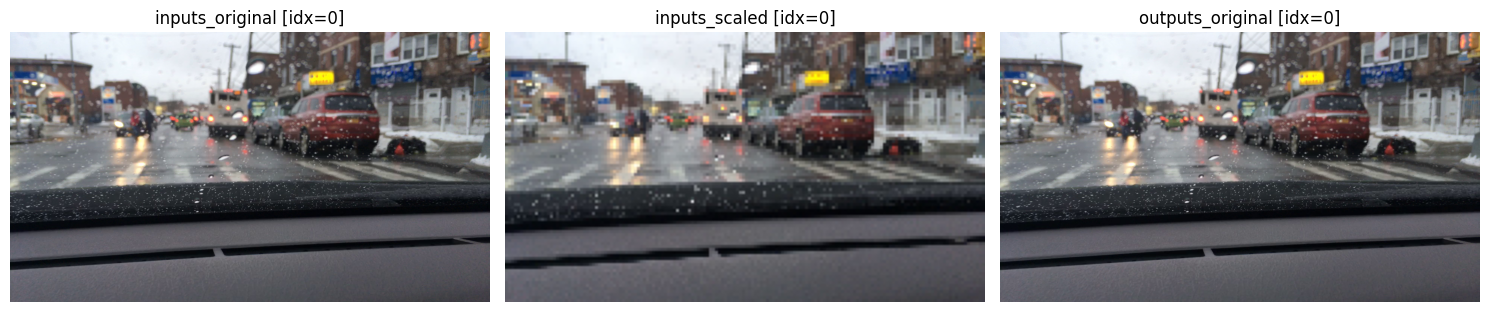

In [15]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

def visualize_three_datasets(h5_path, index=0):
    """
    Attempts to visualize three datasets for the same 'index':
      1) 'inputs_original'
      2) 'inputs_scaled'
      3) 'outputs_original'

    Each dataset is expected to be shaped (N, 3, H, W).
    If a dataset doesn't exist or is empty, we skip it.

    We apply a logic:
      1) If max pixel > 2.0, assume the data is [0,255] => divide by 255
      2) Otherwise, apply a min–max stretch to improve visibility
    """
    if not os.path.exists(h5_path):
        print(f"H5 file '{h5_path}' does not exist.")
        return

    datasets_to_show = [
        "inputs_original",
        "inputs_scaled",
        "outputs_original"
    ]

    with h5py.File(h5_path, 'r') as f:
        images_to_plot = []

        for ds_name in datasets_to_show:
            if ds_name not in f:
                print(f"[Warning] Dataset '{ds_name}' not found. Skipping.")
                continue

            ds = f[ds_name]
            if ds.shape[0] == 0:
                print(f"[Warning] Dataset '{ds_name}' is empty. Skipping.")
                continue

            if index >= ds.shape[0]:
                print(f"[Warning] Index {index} out of range for '{ds_name}' "
                      f"(has {ds.shape[0]} samples). Skipping.")
                continue

            # Retrieve the sample: shape=(3,H,W)
            sample = ds[index]

            # Transpose to (H,W,3) for matplotlib
            sample_rgb = np.transpose(sample, (1, 2, 0))

            # Step 1) Check if data is in [0,255] range
            pixel_min, pixel_max = sample_rgb.min(), sample_rgb.max()

            if pixel_max > 2.0:
                # Probably 0..255 => scale to 0..1
                sample_rgb = sample_rgb / 255.0
                # Recompute min, max after dividing
                pixel_min, pixel_max = sample_rgb.min(), sample_rgb.max()

            # Step 2) Now apply min–max auto-contrast if there's variation
            if pixel_max - pixel_min > 1e-8:
                sample_rgb = (sample_rgb - pixel_min) / (pixel_max - pixel_min)
            else:
                # If everything is the same value, the image is basically uniform
                sample_rgb = np.clip(sample_rgb, 0, 1)

            images_to_plot.append((ds_name, sample_rgb))

    if not images_to_plot:
        print("\nNo valid data found to visualize. Exiting.")
        return

    # Plot side by side
    num_plots = len(images_to_plot)
    plt.figure(figsize=(5 * num_plots, 4))

    for i, (ds_name, img) in enumerate(images_to_plot, start=1):
        plt.subplot(1, num_plots, i)
        plt.imshow(img)
        plt.title(f"{ds_name} [idx={index}]")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    h5_file = "frame_pairs.h5"
    visualize_three_datasets(h5_file, index=0)


## movs mov files

In [4]:
import os
import random
import shutil
import pandas as pd

def split_videos_into_folders(
    csv_train='train_data.csv',
    video_dir='bdd100k/videos',
    train_ratio=0.7,
    val_ratio=0.2,
    test_ratio=0.1,
    move_files=True
):
    """
    1) Reads CSV 'csv_train' for .mov filenames in 'video_dir'.
    2) Splits them (randomly) by train_ratio, val_ratio, test_ratio.
    3) Moves or copies each .mov into subfolders:
       video_dir/train, video_dir/val, video_dir/test
    4) Subfolders are created if they do not exist.

    Args:
        csv_train (str): Path to CSV containing a 'filename' column.
        video_dir (str): Directory where .mov files are found.
        train_ratio (float): fraction to go in train folder
        val_ratio   (float): fraction to go in val folder
        test_ratio  (float): fraction to go in test folder
        move_files  (bool): If True, use shutil.move; else shutil.copy2

    Example:
        split_videos_into_folders(
            csv_train='train_data.csv',
            video_dir='bdd100k/videos',
            train_ratio=0.7,
            val_ratio=0.2,
            test_ratio=0.1,
            move_files=True
        )
    """

    # Basic checks
    ratio_sum = train_ratio + val_ratio + test_ratio
    if abs(ratio_sum - 1.0) > 1e-6:
        raise ValueError("train_ratio + val_ratio + test_ratio must sum to 1.0")

    if not os.path.exists(csv_train):
        raise FileNotFoundError(f"CSV file '{csv_train}' not found.")

    # Read CSV and get filenames
    df = pd.read_csv(csv_train)
    if 'filename' not in df.columns:
        raise ValueError("CSV must contain a 'filename' column.")

    video_filenames = df['filename'].tolist()
    total_videos = len(video_filenames)
    print(f"[Info] Found {total_videos} .mov entries from CSV.")

    # Create subfolders
    train_dir = os.path.join(video_dir, 'train')
    val_dir   = os.path.join(video_dir, 'val')
    test_dir  = os.path.join(video_dir, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # For counting
    count_train = 0
    count_val   = 0
    count_test  = 0

    # Shuffle for randomness or just random pick for each file
    # We'll do a random pick per file
    for idx, fname in enumerate(video_filenames, start=1):
        mov_path = os.path.join(video_dir, fname)
        if not os.path.isfile(mov_path):
            print(f"[Warning] File not found: {mov_path}. Skipping.")
            continue
        # Randomly decide train, val, or test
        r = random.random()
        if r < train_ratio:
            subset_dir = train_dir
            count_train += 1
        elif r < train_ratio + val_ratio:
            subset_dir = val_dir
            count_val += 1
        else:
            subset_dir = test_dir
            count_test += 1

        dest_path = os.path.join(subset_dir, fname)

        # Move or copy
        if move_files:
            shutil.move(mov_path, dest_path)
        else:
            shutil.copy2(mov_path, dest_path)

    print(f"\n[Summary]")
    print(f"Train videos: {count_train}")
    print(f"Val   videos: {count_val}")
    print(f"Test  videos: {count_test}")
    print("[Info] Done splitting videos into train/val/test folders.")


if __name__ == "__main__":
    # Example usage
    split_videos_into_folders(
        csv_train='train_data.csv',
        video_dir='bdd100k/videos',
        train_ratio=0.7,
        val_ratio=0.2,
        test_ratio=0.1,
        move_files=True   # Set to False if you prefer copying
    )


[Info] Found 700 .mov entries from CSV.
[Warning] File not found: bdd100k/videos\01705c36-8993db9f.mov. Skipping.
[Warning] File not found: bdd100k/videos\012a9c41-cef5b320.mov. Skipping.
[Warning] File not found: bdd100k/videos\0145b233-ee9c5b63.mov. Skipping.
[Warning] File not found: bdd100k/videos\0124dfa6-30a430dc.mov. Skipping.
[Warning] File not found: bdd100k/videos\021df36f-9dc059b8.mov. Skipping.
[Warning] File not found: bdd100k/videos\029aad77-628b9c45.mov. Skipping.
[Warning] File not found: bdd100k/videos\00e100a8-9c852617.mov. Skipping.
[Warning] File not found: bdd100k/videos\019588c0-90390013.mov. Skipping.
[Warning] File not found: bdd100k/videos\028daae4-27c30b20.mov. Skipping.
[Warning] File not found: bdd100k/videos\018aca44-9a616a49.mov. Skipping.
[Warning] File not found: bdd100k/videos\019d2681-83c5bf22.mov. Skipping.
[Warning] File not found: bdd100k/videos\01688cf2-237fbd49.mov. Skipping.
[Warning] File not found: bdd100k/videos\01981fe5-b484769f.mov. Skipping

# Training Informer 

In [2]:
# ============================== train_informer_patches.py ==============================
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Info] Using device: {device}")

# Global Config & Paths
TRAIN_FOLDER   = "bdd100k/videos/train"
VAL_FOLDER     = "bdd100k/videos/val"
CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
MAX_TRAIN_VIDS = 3  # or None if you want all
MAX_VAL_VIDS   = 3  # or None if you want all
FRAME_1_SCALE  = 1/8
FRAME_2_SCALE  = 1/4
SIM_THRESHOLD  = 0.96
NUM_EPOCHS     = 10
BATCH_SIZE     = 8
LEARNING_RATE  = 1e-4

# Patch Configuration
PATCH_SIZE = 10  # Define the size of each patch (e.g., 10x10 pixels)

# Model hyperparams
EMBED_DIM     = 256
NUM_HEADS     = 8
NUM_LAYERS    = 10

# Original Frame Sizes
ORIG_INPUT_HEIGHT,  ORIG_INPUT_WIDTH  =  90, 160  # Input frames => (3, 90, 160)
ORIG_OUTPUT_HEIGHT, ORIG_OUTPUT_WIDTH = 180, 320  # Output frames => (3,180,320)

# Calculate Scaled Frame Sizes
SCALED_INPUT_HEIGHT  = int(ORIG_INPUT_HEIGHT * FRAME_1_SCALE)  # e.g., 11
SCALED_INPUT_WIDTH   = int(ORIG_INPUT_WIDTH * FRAME_1_SCALE)   # e.g., 20
SCALED_OUTPUT_HEIGHT = int(ORIG_OUTPUT_HEIGHT * FRAME_2_SCALE) # e.g., 45
SCALED_OUTPUT_WIDTH  = int(ORIG_OUTPUT_WIDTH * FRAME_2_SCALE)  # e.g., 80

# Calculate Number of Patches
NUM_PATCHES_INPUT_H = (SCALED_INPUT_HEIGHT + PATCH_SIZE - 1) // PATCH_SIZE
NUM_PATCHES_INPUT_W = (SCALED_INPUT_WIDTH + PATCH_SIZE - 1) // PATCH_SIZE
NUM_PATCHES_OUTPUT_H = (SCALED_OUTPUT_HEIGHT + PATCH_SIZE - 1) // PATCH_SIZE
NUM_PATCHES_OUTPUT_W = (SCALED_OUTPUT_WIDTH + PATCH_SIZE - 1) // PATCH_SIZE

NUM_PATCHES_INPUT = NUM_PATCHES_INPUT_H * NUM_PATCHES_INPUT_W
NUM_PATCHES_OUTPUT = NUM_PATCHES_OUTPUT_H * NUM_PATCHES_OUTPUT_W

# Define INPUT_SIZE and OUTPUT_SIZE based on patches
# Each patch has 3 channels and PATCH_SIZE x PATCH_SIZE pixels
PATCH_VECTOR_SIZE_INPUT = 3 * PATCH_SIZE * PATCH_SIZE + 2 * PATCH_SIZE * PATCH_SIZE  # Including positional encoding
PATCH_VECTOR_SIZE_OUTPUT = 3 * PATCH_SIZE * PATCH_SIZE + 2 * PATCH_SIZE * PATCH_SIZE

INPUT_SIZE = NUM_PATCHES_INPUT * PATCH_VECTOR_SIZE_INPUT    # Total input vector size
OUTPUT_SIZE = NUM_PATCHES_OUTPUT * PATCH_VECTOR_SIZE_OUTPUT # Total output vector size

print(f"[Info] Patch Size: {PATCH_SIZE}x{PATCH_SIZE}")
print(f"[Info] Scaled Input Frame Size: {SCALED_INPUT_HEIGHT}x{SCALED_INPUT_WIDTH}")
print(f"[Info] Scaled Output Frame Size: {SCALED_OUTPUT_HEIGHT}x{SCALED_OUTPUT_WIDTH}")
print(f"[Info] Number of Input Patches: {NUM_PATCHES_INPUT}")
print(f"[Info] Number of Output Patches: {NUM_PATCHES_OUTPUT}")
print(f"[Info] INPUT_SIZE: {INPUT_SIZE}")
print(f"[Info] OUTPUT_SIZE: {OUTPUT_SIZE}")

# Data pre
def frame_similarity(img1, img2):
    # Convert PyTorch tensors to NumPy if necessary
    if isinstance(img1, torch.Tensor):
        img1 = img1.cpu().numpy()
    if isinstance(img2, torch.Tensor):
        img2 = img2.cpu().numpy()

    # Ensure the images are in grayscale
    if len(img1.shape) == 3:
        img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    if len(img2.shape) == 3:
        img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    # Compute the absolute difference between the two images
    diff = cv2.absdiff(img1, img2)
    # Calculate the percentage similarity
    similarity = 100 - (np.sum(diff) / (img1.shape[0] * img1.shape[1] * 255) * 100)
    return similarity

def split_into_patches(tensor, patch_size):
    """
    Split a tensor into non-overlapping patches.
    tensor: (C, H, W)
    Returns:
        patches: (C, num_patches, patch_size, patch_size)
    """
    C, H, W = tensor.shape
    num_patches_h = (H + patch_size - 1) // patch_size
    num_patches_w = (W + patch_size - 1) // patch_size

    pad_h = num_patches_h * patch_size - H
    pad_w = num_patches_w * patch_size - W

    if pad_h > 0 or pad_w > 0:
        tensor = F.pad(tensor, (0, pad_w, 0, pad_h))  # Pad W and H
    C, H, W = tensor.shape
    patches = tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.contiguous().view(C, -1, patch_size, patch_size)  # (C, num_patches, patch_size, patch_size)
    return patches

def prepare_video_for_model(mov_path, threshold=0.95):
    device_local = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Retrieve all frames from the video
    cap = cv2.VideoCapture(mov_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()

    # 2) If the video has less than 2 frames, return empty list
    if len(frames) < 2:
        return []

    # 3) Build (input -> output) pairs
    pairs = []
    for i in range(len(frames) - 1):
        f1 = frames[i]
        f2 = frames[i + 1]

        # Convert to grayscale for similarity
        f1g = torch.from_numpy(cv2.cvtColor(f1, cv2.COLOR_RGB2GRAY)).float().unsqueeze(0).unsqueeze(0).to(device_local)
        f2g = torch.from_numpy(cv2.cvtColor(f2, cv2.COLOR_RGB2GRAY)).float().unsqueeze(0).unsqueeze(0).to(device_local)

        # 4) Check difference threshold
        if frame_similarity(f1g, f2g) < threshold:
            # keep => color
            f1c = torch.from_numpy(f1).permute(2, 0, 1).float().unsqueeze(0).to(device_local)  # (1, 3, H, W)
            f2c = torch.from_numpy(f2).permute(2, 0, 1).float().unsqueeze(0).to(device_local)  # (1, 3, H, W)

            # 5) Scale frames
            f1_in = F.interpolate(f1c, size=(SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH), mode='linear ', align_corners=False)
            f2_out = F.interpolate(f2c, size=(SCALED_OUTPUT_HEIGHT, SCALED_OUTPUT_WIDTH), mode='linear ', align_corners=False)

            # 6) Normalize from [0..255] => [0..1]
            f1_in  /= 255.
            f2_out /= 255.

            # ----------------------
            # ADD POSITIONAL ENCODING AND SPLIT INTO PATCHES
            # ----------------------
            # a) Create positional encoding
            pos_in  = create_2d_position_channels(SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH, PATCH_SIZE).unsqueeze(0).to(device_local)  # (1, 2, num_patches_h, num_patches_w)
            pos_out = create_2d_position_channels(SCALED_OUTPUT_HEIGHT, SCALED_OUTPUT_WIDTH, PATCH_SIZE).unsqueeze(0).to(device_local)

            # b) Split frames into patches
            f1_patches = split_into_patches(f1_in.squeeze(0), PATCH_SIZE)  # (C, num_patches, patch_size, patch_size)
            f2_patches = split_into_patches(f2_out.squeeze(0), PATCH_SIZE)

            # c) Add positional encoding to each patch
            # Reshape positional encoding to match patches
            pos_in = pos_in.view(2, -1)  # (2, num_patches)
            pos_out = pos_out.view(2, -1)

            # Expand positional encoding to match channels and patch size
            # For simplicity, we can concatenate positional encoding as additional channels
            # Alternatively, you can embed positional information differently
            # Here, we'll expand positional encoding to the patch size
            pos_in_expanded = pos_in.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, PATCH_SIZE, PATCH_SIZE)  # (2, num_patches, patch_size, patch_size)
            pos_out_expanded = pos_out.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, PATCH_SIZE, PATCH_SIZE)

            # Concatenate positional encoding with patch data
            # Instead of concatenation, store positional encoding separately
            f1_patches_flat = f1_patches.view(3, -1)  # Only image data
            f2_patches_flat = f2_patches.view(3, -1)

            pos_in_flat = pos_in.view(2, -1)  # Flatten positional encoding
            pos_out_flat = pos_out.view(2, -1)

            # Add positional encoding post-embedding
            f1_patches_flat += pos_in_flat
            f2_patches_flat += pos_out_flat
            
            # Flatten each patch
            f1_patches_flat = f1_patches.view(5, -1)  # (5, num_patches * patch_size * patch_size)
            f2_patches_flat = f2_patches.view(5, -1)

            # Transpose to have patches first
            f1_patches_flat = f1_patches_flat.permute(1, 0)  # (num_patches, 5 * patch_size * patch_size)
            f2_patches_flat = f2_patches_flat.permute(1, 0)  # (num_patches, 5 * patch_size * patch_size)

            # Convert to NumPy
            np_in  = f1_patches_flat.cpu().numpy()   # shape=(num_patches_input, patch_vector_size_input)
            np_out = f2_patches_flat.cpu().numpy()  # shape=(num_patches_output, patch_vector_size_output)
            pairs.append((np_in, np_out))

    return pairs

####### Informer Model => input=INPUT_SIZE, output=OUTPUT_SIZE
class InformerEncoder(nn.Module):
    def __init__(self, input_size, d_model, n_heads, d_ff, num_layers, dropout):
        super().__init__()
        self.input_projection = nn.Linear(input_size, d_model)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        src = self.input_projection(src)
        src = self.dropout(src)
        for layer in self.layers:
            src = layer(src)
        return src

class InformerDecoder(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, num_layers, dropout, output_size):
        super().__init__()
        self.target_projection = nn.Linear(output_size, d_model)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(d_model, output_size)

    def forward(self, tgt, memory):
        tgt = self.target_projection(tgt)
        for layer in self.layers:
            tgt = layer(tgt, memory)
        out = self.output_layer(tgt)
        return out

class Informer(nn.Module):
    def __init__(self, input_size, d_model, n_heads, d_ff, num_layers, dropout, output_size):
        super().__init__()
        self.encoder = InformerEncoder(input_size, d_model, n_heads, d_ff, num_layers, dropout)
        self.decoder = InformerDecoder(d_model, n_heads, d_ff, num_layers, dropout, output_size)

    def forward(self, src, tgt):
        memory = self.encoder(src)
        out    = self.decoder(tgt, memory)
        return out

# Define EncoderLayer and DecoderLayer (Assuming they are similar to Transformer layers)
# If not defined, you need to implement them or import from a library
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        src2, _ = self.self_attn(src, src, src)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, tgt, memory):
        tgt2, _ = self.self_attn(tgt, tgt, tgt)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2, _ = self.multihead_attn(tgt, memory, memory)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(F.relu(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

# Initialize the model
model = Informer(
    input_size=INPUT_SIZE,  # e.g., num_patches_input * patch_vector_size_input
    d_model=EMBED_DIM,
    n_heads=NUM_HEADS,
    d_ff=512,
    num_layers=NUM_LAYERS,
    dropout=0.1,
    output_size=OUTPUT_SIZE  # e.g., num_patches_output * patch_vector_size_output
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.MultiheadAttention):
        nn.init.xavier_uniform_(m.out_proj.weight)
        if m.out_proj.bias is not None:
            nn.init.zeros_(m.out_proj.bias)
model.apply(init_weights)

####### Custom Dataset for Patch Pairs
class PatchPairDataset(Dataset):
    def __init__(self, pairs):
        """
        pairs: List of tuples (input_patches, target_patches)
               input_patches: numpy array of shape (num_patches_input, patch_vector_size_input)
               target_patches: numpy array of shape (num_patches_output, patch_vector_size_output)
        """
        self.input_patches = []
        self.target_patches = []
        for inp, tgt in pairs:
            self.input_patches.append(inp)
            self.target_patches.append(tgt)

    def __len__(self):
        return len(self.input_patches)

    def __getitem__(self, idx):
        inp = self.input_patches[idx]
        tgt = self.target_patches[idx]
        return torch.tensor(inp, dtype=torch.float32), torch.tensor(tgt, dtype=torch.float32)

####### Training & Validation
def train_on_dataset(dataset):
    """
    Train on a dataset consisting of patch pairs.
    """
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    model.train()
    loss_sum = 0.0
    loss_count = 0

    for (in_batch, out_batch) in loader:
        # in_batch => shape=(B, num_patches_input, patch_vector_size_input)
        # out_batch=> shape=(B, num_patches_output, patch_vector_size_output)
        in_batch = in_batch.to(device)
        out_batch = out_batch.to(device)

        B = in_batch.size(0)
        # Flatten the patches for the model
        in_flat = in_batch.view(B, -1).unsqueeze(0)    # => (1, B, INPUT_SIZE)
        out_flat= out_batch.view(B, -1).unsqueeze(0)   # => (1, B, OUTPUT_SIZE)

        optimizer.zero_grad()
        pred = model(in_flat, out_flat)
        loss = criterion(pred, out_flat)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        loss_count += 1

    if loss_count == 0:
        return 0.0
    return loss_sum / loss_count

def val_on_dataset(dataset):
    """
    Validate on a dataset consisting of patch pairs.
    """
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    model.eval()
    loss_sum = 0.0
    loss_count = 0

    with torch.no_grad():
        for (vin, vout) in loader:
            vin  = vin.to(device)
            vout = vout.to(device)

            B = vin.size(0)
            vin_flat  = vin.view(B, -1).unsqueeze(0)  # => (1, B, INPUT_SIZE)
            vout_flat = vout.view(B, -1).unsqueeze(0) # => (1, B, OUTPUT_SIZE)

            pred = model(vin_flat, vout_flat)
            l    = criterion(pred, vout_flat)
            loss_sum += l.item()
            loss_count += 1

    if loss_count == 0:
        return 0.0
    return loss_sum / loss_count

def save_checkpoint(epoch):
    ckpt_path = os.path.join(CHECKPOINT_DIR, f"informer_patches_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, ckpt_path)

####### training
# Gathering Data for the mov Training and Validation
train_movs = [f for f in os.listdir(TRAIN_FOLDER) if f.lower().endswith('.mov')]
train_movs.sort()

val_movs = [f for f in os.listdir(VAL_FOLDER) if f.lower().endswith('.mov')]
val_movs.sort()

# Limit the number of videos for faster training
if MAX_TRAIN_VIDS is not None:
    train_movs = train_movs[:MAX_TRAIN_VIDS]

if MAX_VAL_VIDS is not None:
    val_movs = val_movs[:MAX_VAL_VIDS]

# Plotting Variables
train_losses = []
val_losses   = []

for epoch in range(1, NUM_EPOCHS + 1):
    start_t = time.time()

    # --- Training ---
    train_pairs = []
    with tqdm(train_movs, desc=f"Epoch [{epoch}/{NUM_EPOCHS}] - Training", unit="video") as train_pbar:
        for file_name in train_pbar:
            mov_path = os.path.join(TRAIN_FOLDER, file_name)
            frames_from_mov = prepare_video_for_model(mov_path, SIM_THRESHOLD)
            if len(frames_from_mov) == 0:
                continue
            train_pairs.extend(frames_from_mov)  # Collect all patch pairs from the video

    train_dataset = PatchPairDataset(train_pairs)
    avg_train_loss = train_on_dataset(train_dataset)

    # --- Validation ---
    val_pairs = []
    with tqdm(val_movs, desc=f"Epoch [{epoch}/{NUM_EPOCHS}] - Validation", unit="video") as val_pbar:
        for fname in val_pbar:
            mov_path = os.path.join(VAL_FOLDER, fname)
            ds = prepare_video_for_model(mov_path, SIM_THRESHOLD)
            if len(ds) == 0:
                continue
            val_pairs.extend(ds)

    val_dataset = PatchPairDataset(val_pairs)
    avg_val_loss = val_on_dataset(val_dataset)

    elapsed = time.time() - start_t
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch}/{NUM_EPOCHS}]"
            f" | Train Loss: {avg_train_loss:.6f}"
            f" | Val Loss: {avg_val_loss:.6f}"
            f" | Time: {elapsed:.2f}s")

    save_checkpoint(epoch)

# plot
e_range = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(8, 6))
plt.plot(e_range, train_losses, label='Train Loss', marker='o')
plt.plot(e_range, val_losses,   label='Val Loss',   marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Informer with Patch Sequences: input patches => output patches')
plt.legend()
plt.grid(True)
plt.show()


[Info] Using device: cuda
[Info] Patch Size: 10x10
[Info] Scaled Input Frame Size: 11x20
[Info] Scaled Output Frame Size: 45x80
[Info] Number of Input Patches: 4
[Info] Number of Output Patches: 40
[Info] INPUT_SIZE: 2000
[Info] OUTPUT_SIZE: 20000


Epoch [1/10] - Training:   0%|          | 0/3 [00:03<?, ?video/s]


ValueError: align_corners option can only be set with the interpolating modes: linear | bilinear | bicubic | trilinear

## Testing the Model of Informer Frame Predictor

In [5]:
# ============================== informer_inference_gui.py ==============================
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import ttk, messagebox
import random
import threading
from torchvision.transforms import ToPILImage

# Ensure you have the necessary imports from your training script
# If the training script is in the same directory, you can import classes and functions from it
# For simplicity, we'll assume the Informer model and related classes are defined here or imported appropriately

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Info] Using device: {device}")

# Global Config & Paths (should match your training script)
TRAIN_FOLDER   = "bdd100k/videos/train"
VAL_FOLDER     = "bdd100k/videos/val"
CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
MAX_TRAIN_VIDS = 3  # or None if you want all
MAX_VAL_VIDS   = 3  # or None if you want all
FRAME_1_SCALE  = 1/8
FRAME_2_SCALE  = 1/4
SIM_THRESHOLD  = 0.96
NUM_EPOCHS     = 10
BATCH_SIZE     = 8
LEARNING_RATE  = 1e-4

# Patch Configuration
PATCH_SIZE = 10  # Define the size of each patch (e.g., 10x10 pixels)

# Model hyperparams
EMBED_DIM     = 256
NUM_HEADS     = 8
NUM_LAYERS    = 10

# Original Frame Sizes
ORIG_INPUT_HEIGHT,  ORIG_INPUT_WIDTH  =  90, 160  # Input frames => (3, 90, 160)
ORIG_OUTPUT_HEIGHT, ORIG_OUTPUT_WIDTH = 180, 320  # Output frames => (3,180,320)

# Calculate Scaled Frame Sizes
SCALED_INPUT_HEIGHT  = int(ORIG_INPUT_HEIGHT * FRAME_1_SCALE)  # e.g., 11
SCALED_INPUT_WIDTH   = int(ORIG_INPUT_WIDTH * FRAME_1_SCALE)   # e.g., 20
SCALED_OUTPUT_HEIGHT = int(ORIG_OUTPUT_HEIGHT * FRAME_2_SCALE) # e.g., 45
SCALED_OUTPUT_WIDTH  = int(ORIG_OUTPUT_WIDTH * FRAME_2_SCALE)  # e.g., 80

# Calculate Number of Patches
NUM_PATCHES_INPUT_H = (SCALED_INPUT_HEIGHT + PATCH_SIZE - 1) // PATCH_SIZE
NUM_PATCHES_INPUT_W = (SCALED_INPUT_WIDTH + PATCH_SIZE - 1) // PATCH_SIZE
NUM_PATCHES_OUTPUT_H = (SCALED_OUTPUT_HEIGHT + PATCH_SIZE - 1) // PATCH_SIZE
NUM_PATCHES_OUTPUT_W = (SCALED_OUTPUT_WIDTH + PATCH_SIZE - 1) // PATCH_SIZE

NUM_PATCHES_INPUT = NUM_PATCHES_INPUT_H * NUM_PATCHES_INPUT_W
NUM_PATCHES_OUTPUT = NUM_PATCHES_OUTPUT_H * NUM_PATCHES_OUTPUT_W

# Define INPUT_SIZE and OUTPUT_SIZE based on patches
# Each patch has 3 channels and PATCH_SIZE x PATCH_SIZE pixels
PATCH_VECTOR_SIZE_INPUT = 3 * PATCH_SIZE * PATCH_SIZE + 2 * PATCH_SIZE * PATCH_SIZE  # Including positional encoding
PATCH_VECTOR_SIZE_OUTPUT = 3 * PATCH_SIZE * PATCH_SIZE + 2 * PATCH_SIZE * PATCH_SIZE

INPUT_SIZE = NUM_PATCHES_INPUT * PATCH_VECTOR_SIZE_INPUT    # Total input vector size
OUTPUT_SIZE = NUM_PATCHES_OUTPUT * PATCH_VECTOR_SIZE_OUTPUT # Total output vector size

print(f"[Info] Patch Size: {PATCH_SIZE}x{PATCH_SIZE}")
print(f"[Info] Scaled Input Frame Size: {SCALED_INPUT_HEIGHT}x{SCALED_INPUT_WIDTH}")
print(f"[Info] Scaled Output Frame Size: {SCALED_OUTPUT_HEIGHT}x{SCALED_OUTPUT_WIDTH}")
print(f"[Info] Number of Input Patches: {NUM_PATCHES_INPUT}")
print(f"[Info] Number of Output Patches: {NUM_PATCHES_OUTPUT}")
print(f"[Info] INPUT_SIZE: {INPUT_SIZE}")
print(f"[Info] OUTPUT_SIZE: {OUTPUT_SIZE}")

####### Define Informer Model Components
# You need to ensure that Informer, InformerEncoder, InformerDecoder, EncoderLayer, DecoderLayer are defined here
# For brevity, I'm assuming these classes are already defined or imported appropriately
# Make sure to include the same model architecture as used in training

# Example: Assuming Informer class is defined similarly to your training script
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        src2, _ = self.self_attn(src, src, src)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, tgt, memory):
        tgt2, _ = self.self_attn(tgt, tgt, tgt)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2, _ = self.multihead_attn(tgt, memory, memory)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(F.relu(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

class InformerEncoder(nn.Module):
    def __init__(self, input_size, d_model, n_heads, d_ff, num_layers, dropout):
        super().__init__()
        self.input_projection = nn.Linear(input_size, d_model)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        src = self.input_projection(src)
        src = self.dropout(src)
        for layer in self.layers:
            src = layer(src)
        return src

class InformerDecoder(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, num_layers, dropout, output_size):
        super().__init__()
        self.target_projection = nn.Linear(output_size, d_model)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(d_model, output_size)

    def forward(self, tgt, memory):
        tgt = self.target_projection(tgt)
        for layer in self.layers:
            tgt = layer(tgt, memory)
        out = self.output_layer(tgt)
        return out

class Informer(nn.Module):
    def __init__(self, input_size, d_model, n_heads, d_ff, num_layers, dropout, output_size):
        super().__init__()
        self.encoder = InformerEncoder(input_size, d_model, n_heads, d_ff, num_layers, dropout)
        self.decoder = InformerDecoder(d_model, n_heads, d_ff, num_layers, dropout, output_size)

    def forward(self, src, tgt):
        memory = self.encoder(src)
        out    = self.decoder(tgt, memory)
        return out

####### Positional Encoding Helpers (from training script)
def create_2d_position_channels(height, width, patch_size):
    """
    Create two extra channels for positional encoding based on patch positions.
    Each patch's position is normalized between 0 and 1.
    Resulting shape: (2, num_patches_h, num_patches_w)
    """
    num_patches_h = (height + patch_size - 1) // patch_size
    num_patches_w = (width + patch_size - 1) // patch_size

    pos_y = torch.linspace(0, 1, steps=num_patches_h).unsqueeze(1).repeat(1, num_patches_w)
    pos_x = torch.linspace(0, 1, steps=num_patches_w).unsqueeze(0).repeat(num_patches_h, 1)

    pos = torch.stack((pos_y, pos_x), dim=0)  # => shape (2, num_patches_h, num_patches_w)
    return pos

def split_into_patches(tensor, patch_size):
    """
    Split a tensor into non-overlapping patches, cropping to avoid excessive padding.
    """
    C, H, W = tensor.shape

    # Adjust height and width to nearest multiple of patch_size
    new_H = (H // patch_size) * patch_size
    new_W = (W // patch_size) * patch_size

    # Crop tensor instead of padding
    tensor = tensor[:, :new_H, :new_W]

    # Reshape to patches
    patches = tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.contiguous().view(C, -1, patch_size, patch_size)  # (C, num_patches, patch_size, patch_size)
    return patches


####### Helper Functions for Inference

def load_model(checkpoint_path):
    """
    Load the trained Informer model from a checkpoint.
    """
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")
    
    model = Informer(
        input_size=INPUT_SIZE,
        d_model=EMBED_DIM,
        n_heads=NUM_HEADS,
        d_ff=512,
        num_layers=NUM_LAYERS,
        dropout=0.1,
        output_size=OUTPUT_SIZE
    ).to(device)
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"[Info] Loaded model from {checkpoint_path}")
    return model

def random_mov_and_frame(val_folder):
    """
    Select a random .mov file from the validation folder and a random frame from it.
    Returns:
        frame_rgb: numpy array of the selected frame in RGB format
        all_frames: list of all frames in the video
        selected_idx: index of the selected frame
    """
    mov_files = [f for f in os.listdir(val_folder) if f.lower().endswith('.mov')]
    if not mov_files:
        return None, None, -1
    
    selected_mov = random.choice(mov_files)
    mov_path = os.path.join(val_folder, selected_mov)
    
    cap = cv2.VideoCapture(mov_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()
    
    if not frames:
        return None, frames, -1
    
    selected_idx = random.randint(0, len(frames) - 2)  # Ensure there's a next frame for prediction
    current_frame = frames[selected_idx]
    next_frame = frames[selected_idx + 1]
    
    return current_frame, frames, selected_idx

def preprocess_input(frame_rgb):
    """
    Preprocess the input frame to match the training pipeline.
    Args:
        frame_rgb: numpy array of shape (H, W, C)
    Returns:
        torch tensor of shape (1, INPUT_SIZE)
    """
    device_local = device

    # Convert to tensor and permute to (C, H, W)
    f1c = torch.from_numpy(frame_rgb).permute(2, 0, 1).float().unsqueeze(0).to(device_local)  # (1, 3, H, W)

    # Scale frames
    f1_in = F.interpolate(f1c, size=(SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH), mode='bilinear', align_corners=False)

    # Normalize from [0..255] => [0..1]
    f1_in /= 255.0

    # Add positional encoding and split into patches
    pos_in  = create_2d_position_channels(SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH, PATCH_SIZE).unsqueeze(0).to(device_local)  # (1, 2, num_patches_h, num_patches_w)
    f1_patches = split_into_patches(f1_in.squeeze(0), PATCH_SIZE)  # (C, num_patches, patch_size, patch_size)

    # Add positional encoding to each patch
    pos_in = pos_in.view(2, -1)  # (2, num_patches)
    pos_in_expanded = pos_in.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, PATCH_SIZE, PATCH_SIZE)  # (2, num_patches, patch_size, patch_size)
    f1_patches = torch.cat([f1_patches, pos_in_expanded], dim=0)  # (5, num_patches, patch_size, patch_size)

    # Flatten each patch
    f1_patches_flat = f1_patches.view(5, -1)  # (5, num_patches * patch_size * patch_size)
    f1_patches_flat = f1_patches_flat.permute(1, 0)  # (num_patches, 5 * patch_size * patch_size)

    # Convert to NumPy
    np_in  = f1_patches_flat.cpu().numpy()   # shape=(num_patches_input, patch_vector_size_input)

    # Convert to Torch tensor
    tin = torch.tensor(np_in, dtype=torch.float32).reshape(1, -1).to(device_local)  # shape=(1, INPUT_SIZE)

    return tin

def preprocess_input_from_image(t_in):
    """
    Preprocess the output image to be used as input for recursive predictions.
    Args:
        t_in: torch tensor of the output frame, shape=(C, H, W)
    Returns:
        torch tensor of shape (1, INPUT_SIZE)
    """
    device_local = device

    # Scale frames
    f1_in = F.interpolate(t_in.unsqueeze(0), size=(SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH), mode='bilinear', align_corners=False)

    # Normalize from [0..1] => [0..1] (already normalized)
    # If needed, ensure it's in [0..1]

    # Add positional encoding and split into patches
    pos_in  = create_2d_position_channels(SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH, PATCH_SIZE).unsqueeze(0).to(device_local)  # (1, 2, num_patches_h, num_patches_w)
    f1_patches = split_into_patches(f1_in.squeeze(0), PATCH_SIZE)  # (C, num_patches, patch_size, patch_size)

    # Add positional encoding to each patch
    pos_in = pos_in.view(2, -1)  # (2, num_patches)
    pos_in_expanded = pos_in.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, PATCH_SIZE, PATCH_SIZE)  # (2, num_patches, patch_size, patch_size)
    f1_patches = torch.cat([f1_patches, pos_in_expanded], dim=0)  # (5, num_patches, patch_size, patch_size)

    # Flatten each patch
    f1_patches_flat = f1_patches.view(5, -1)  # (5, num_patches * patch_size * patch_size)
    f1_patches_flat = f1_patches_flat.permute(1, 0)  # (num_patches, 5 * patch_size * patch_size)

    # Convert to NumPy
    np_in  = f1_patches_flat.cpu().numpy()   # shape=(num_patches_input, patch_vector_size_input)

    # Convert to Torch tensor
    tin = torch.tensor(np_in, dtype=torch.float32).view(1, -1).to(device_local)  # shape=(1, INPUT_SIZE)

    return tin

def postprocess_output(out_tensor):
    """
    Postprocess the model's output tensor to convert it back to a PIL image.
    Args:
        out_tensor: torch tensor of shape (1, OUTPUT_SIZE)
    Returns:
        PIL Image of the output frame
    """
    device_local = device

    # Remove batch dimension
    out_flat = out_tensor.squeeze(0)  # shape=(OUTPUT_SIZE,)

    # Convert to NumPy
    np_out = out_flat.cpu().numpy()  # shape=(num_patches_output, patch_vector_size_output)

    # Reshape to (num_patches_output, 5, patch_size, patch_size)
    np_out = np_out.reshape(NUM_PATCHES_OUTPUT, 5, PATCH_SIZE, PATCH_SIZE)  # (num_patches_output, 5, 10, 10)

    # Extract RGB channels
    rgb_patches = np_out[:, :3, :, :]  # (num_patches_output, 3, 10, 10)

    # Reconstruct the output frame from patches
    num_patches_h = NUM_PATCHES_OUTPUT_H
    num_patches_w = NUM_PATCHES_OUTPUT_W

    # Initialize empty frame
    reconstructed = np.zeros((3, num_patches_h * PATCH_SIZE, num_patches_w * PATCH_SIZE), dtype=np.float32)  # (3,45,80)

    patch_idx = 0
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            if patch_idx >= rgb_patches.shape[0]:
                break
            patch = rgb_patches[patch_idx]
            h_start = i * PATCH_SIZE
            w_start = j * PATCH_SIZE
            h_end = h_start + PATCH_SIZE
            w_end = w_start + PATCH_SIZE
            reconstructed[:, h_start:h_end, w_start:w_end] = patch
            patch_idx += 1

    # Crop to original scaled size
    reconstructed = reconstructed[:, :SCALED_OUTPUT_HEIGHT, :SCALED_OUTPUT_WIDTH]  # (3,45,80)

    # Clamp and convert to [0,255]
    reconstructed = np.clip(reconstructed, 0, 1)
    reconstructed = (reconstructed * 255.0).astype(np.uint8)

    # Reorder to (H, W, C)
    reconstructed = np.transpose(reconstructed, (1, 2, 0))  # => shape=(45,80,3)

    # Convert to PIL Image
    out_pil = Image.fromarray(reconstructed)

    return out_pil

class InformerGUI:
    def __init__(self, master, checkpoint_path, val_folder):
        self.master = master
        self.master.title("Informer Inference GUI: Input => Output")
        self.master.geometry("1000x600")

        self.model = load_model(checkpoint_path)
        self.val_folder = val_folder
        self.frames = []
        self.idx = -1
        self.current_input = None
        self.current_output = None

        self.create_widgets()
        self.select_random_frame()

    def create_widgets(self):
        top = ttk.Frame(self.master)
        top.pack(pady=10)

        self.rand_btn = ttk.Button(top, text="Select Random Frame", command=self.select_random_frame)
        self.rand_btn.pack(side=tk.LEFT, padx=5)

        self.pred_btn = ttk.Button(top, text="Predict Next Frame", command=self.predict_next_frame)
        self.pred_btn.pack(side=tk.LEFT, padx=5)
        self.pred_btn.config(state=tk.DISABLED)

        self.rec_btn = ttk.Button(top, text="Reconstruct", command=self.reconstruct_frame)
        self.rec_btn.pack(side=tk.LEFT, padx=5)
        self.rec_btn.config(state=tk.DISABLED)

        images_frame = ttk.Frame(self.master)
        images_frame.pack(pady=10)

        # Input Frame
        lbl_in = ttk.Label(images_frame, text=f"Input: scale={FRAME_1_SCALE} => [0..1]")
        lbl_in.grid(row=0, column=0, padx=10, pady=5)
        self.input_canvas = tk.Canvas(images_frame, width=SCALED_INPUT_WIDTH*10, height=SCALED_INPUT_HEIGHT*10)
        self.input_canvas.grid(row=1, column=0, padx=10, pady=5)

        # Output Frame
        lbl_out = ttk.Label(images_frame, text=f"Output: scale={FRAME_2_SCALE} => [0..1 -> x255]")
        lbl_out.grid(row=0, column=1, padx=10, pady=5)
        self.output_canvas = tk.Canvas(images_frame, width=SCALED_OUTPUT_WIDTH*5, height=SCALED_OUTPUT_HEIGHT*5)
        self.output_canvas.grid(row=1, column=1, padx=10, pady=5)

        self.status_var = tk.StringVar()
        self.status_var.set("Ready")
        self.status_bar = ttk.Label(self.master, textvariable=self.status_var, anchor=tk.W, relief=tk.SUNKEN)
        self.status_bar.pack(fill=tk.X, side=tk.BOTTOM, ipady=2)

    def select_random_frame(self):
        self.status_var.set("Selecting random .mov + random frame..")
        self.master.update_idletasks()
        frame_rgb, all_frames, idx = random_mov_and_frame(self.val_folder)
        if frame_rgb is None or idx < 0:
            self.status_var.set("No valid .mov found in validation folder.")
            return
        self.frames = all_frames
        self.idx = idx

        tin = preprocess_input(frame_rgb)  # => shape=(1, INPUT_SIZE)
        self.current_input = tin
        self.current_output = None  # Reset output
        self.pred_btn.config(state=tk.NORMAL)  # Enable predict button
        self.rec_btn.config(state=tk.DISABLED)  # Disable reconstruct until prediction is done
        self.display_input(frame_rgb)
        self.output_canvas.delete("all")
        self.status_var.set("Random frame selected. Ready for prediction.")

    def predict_next_frame(self):
        if self.current_input is None:
            messagebox.showwarning("No Input", "Please select a random frame first.")
            return
        try:
            self.pred_btn.config(state=tk.DISABLED)
            self.rec_btn.config(state=tk.DISABLED)
            self.status_var.set("Predicting next frame...")
            self.master.update_idletasks()
            threading.Thread(target=self.run_prediction).start()
        except Exception as e:
            messagebox.showerror("Predict Error", f"{e}")
            self.pred_btn.config(state=tk.NORMAL)
            self.status_var.set("Prediction failed.")

    def reconstruct_frame(self):
        if self.current_output is None:
            messagebox.showwarning("No Output", "Please run prediction first.")
            return
        try:
            self.rec_btn.config(state=tk.DISABLED)
            self.pred_btn.config(state=tk.DISABLED)
            self.status_var.set("Reconstructing frame...")
            self.master.update_idletasks()
            threading.Thread(target=self.run_reconstruction).start()
        except Exception as e:
            messagebox.showerror("Reconstruct Error", f"{e}")
            self.rec_btn.config(state=tk.NORMAL)
            self.status_var.set("Reconstruction failed.")

    def run_prediction(self):
        try:
            # tin => shape=(1, INPUT_SIZE)
            src = self.current_input.unsqueeze(0)  # => shape=(1, 1, INPUT_SIZE)
            tgt = torch.zeros(1, 1, OUTPUT_SIZE, device=device)  # Initialize target with zeros

            with torch.no_grad():
                out = self.model(src, tgt)  # => shape=(1, OUTPUT_SIZE)

            self.current_output = out.squeeze(0)  # shape=(OUTPUT_SIZE,)
            out_pil = postprocess_output(self.current_output.unsqueeze(0))    # => PIL Image

            self.display_output(out_pil)
            self.status_var.set("Prediction done.")
            self.rec_btn.config(state=tk.NORMAL)
        except Exception as e:
            messagebox.showerror("Prediction Error", f"{e}")
            self.status_var.set("Prediction failed.")
        finally:
            self.pred_btn.config(state=tk.NORMAL)

    def run_reconstruction(self):
        try:
            # out => shape=(1, OUTPUT_SIZE)
            out_tensor = self.current_output.unsqueeze(0)  # => shape=(1, OUTPUT_SIZE)
            out_pil = postprocess_output(out_tensor)    # => PIL Image

            # Preprocess output to be input
            t_in = preprocess_input_from_image(torch.from_numpy(np.array(out_pil)).permute(2,0,1).float().to(device))  # shape=(1, INPUT_SIZE)

            self.current_input = t_in
            self.current_output = None  # Reset output

            # Display the reconstructed input
            self.display_input(np.array(out_pil.resize((ORIG_OUTPUT_WIDTH, ORIG_OUTPUT_HEIGHT), Image.ANTIALIAS)))

            self.output_canvas.delete("all")
            self.status_var.set("Reconstruction done. Ready for next prediction.")
            self.pred_btn.config(state=tk.NORMAL)
        except Exception as e:
            messagebox.showerror("Reconstruction Error", f"{e}")
            self.status_var.set("Reconstruction failed.")
        finally:
            self.rec_btn.config(state=tk.NORMAL)

    def display_input(self, frame_rgb):
        """
        Display the input frame on the input canvas.
        Args:
            frame_rgb: numpy array of shape (H, W, C)
        """
        # Resize for better visibility
        img = Image.fromarray(frame_rgb)
        img = img.resize((SCALED_INPUT_WIDTH*10, SCALED_INPUT_HEIGHT*10), Image.NEAREST)
        self.input_image = ImageTk.PhotoImage(img)
        self.input_canvas.create_image(0, 0, anchor=tk.NW, image=self.input_image)

    def display_output(self, out_pil):
        """
        Display the output frame on the output canvas.
        Args:
            out_pil: PIL Image
        """
        # Resize for better visibility
        img = out_pil.resize((SCALED_OUTPUT_WIDTH*5, SCALED_OUTPUT_HEIGHT*5), Image.NEAREST)
        self.output_image = ImageTk.PhotoImage(img)
        self.output_canvas.create_image(0, 0, anchor=tk.NW, image=self.output_image)

checkpoint_path = 'checkpoints/informer_patches_epoch_10.pth'  # Update with your checkpoint path
val_folder = 'bdd100k/videos/val'  # Update if your validation folder is different

root = tk.Tk()
gui = InformerGUI(root, checkpoint_path, val_folder)
root.mainloop()

[Info] Using device: cuda
[Info] Patch Size: 10x10
[Info] Scaled Input Frame Size: 11x20
[Info] Scaled Output Frame Size: 45x80
[Info] Number of Input Patches: 4
[Info] Number of Output Patches: 40
[Info] INPUT_SIZE: 2000
[Info] OUTPUT_SIZE: 20000


FileNotFoundError: Checkpoint file not found: checkpoints/informer_patches_epoch_10.pth